In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
import sys
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/home/mondzi259/Apna_Assignment/src/ml_auto/')

In [4]:
from custom_estimator import Estimator, scoring_metric
from encoding import FreqeuncyEncoding,TargetEncoding
from hyperopt_model_selection import HyperOptModelSelection,hp
from custom_fold_generator import KFold,GroupKFold,CustomFolds
from lightgbm import LGBMRegressor

In [5]:
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
DATA_DIR = '/home/mondzi259/Apna_Assignment/data/'

In [8]:
df = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=0)
df.shape

(30000, 19)

In [9]:
df.drop('feebackgiven',axis=1,inplace=True)

In [10]:
data_dic = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=1,header=None)

In [11]:
data_dic

,0,1,2,3
0,lead,A candidate who has interacted with HR on the ...,NaN,NaN
1,shift,night/ day,"0 - day, 1 - night",NaN
2,gender,f/m/all,"0 - male jobs, 1 - female , 2 - all",NaN
3,education,10th to PG,"ordinally placed, 10th being lowest and PG the...",NaN
4,created_on,job created date,Days since a fixed reference data,"For ex: if reference data was 1 Jan 2020,\njob..."
5,employer_type,key-account/ smb/ enterprise/ consultant/ NA,"most jobs are smb, followed by Key accounts, e...",NaN
6,applicant_location,candidate distance from job,"lower the value, lower the distance requirement",NaN
7,city,city,is masked,NaN
8,area,area,is masked,NaN
9,organization,company name,is masked,NaN


In [12]:
df.head()

,shift,gender,education,created_on,dow,employer_type,applicant_location,city,area,organization,deposit,category,english,num_openings,max_salary,min_salary,is_part_time,leads_per_opening
0,0.0,0.0,3.0,413.0,3.0,0.0,0.0,1.0,4119.0,31278.0,0.0,55.0,2.0,22.0,21000.0,NaN,0.0,0.090909
1,0.0,0.0,3.0,529.0,0.0,4.0,0.0,2.0,2017.0,32006.0,0.0,54.0,2.0,2.0,80000.0,NaN,0.0,31.500000
2,0.0,0.0,0.0,457.0,0.0,4.0,0.0,3.0,1500.0,32029.0,0.0,42.0,3.0,1.0,3500.0,NaN,1.0,9.000000
3,0.0,0.0,4.0,450.0,3.0,4.0,0.0,5.0,638.0,9925.0,0.0,60.0,4.0,4.0,11500.0,NaN,0.0,0.000000
4,0.0,0.0,0.0,480.0,0.0,1.0,0.0,2.0,4115.0,8400.0,0.0,16.0,3.0,25.0,25000.0,NaN,0.0,1.400000


### Target vs created_on

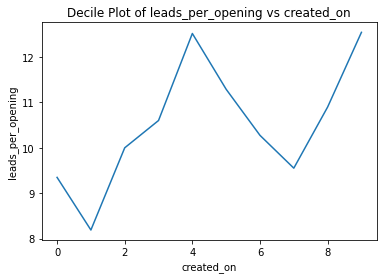

In [13]:
df.groupby(pd.qcut(df['created_on'],10,
                   duplicates='drop',labels=False))['leads_per_opening'].mean().plot()
plt.ylabel('leads_per_opening')
plt.title('Decile Plot of leads_per_opening vs created_on');

### 

In [14]:
num_cols = ['leads_per_opening','max_salary','min_salary','deposit','num_openings','created_on']
cat_cols = [i for i in df.columns.tolist() if i not in num_cols]
cat_ordinal_cols = ['applicant_location','english','education']
cat_non_ord_cols = [i for i in cat_cols if i not in cat_ordinal_cols]

In [15]:
cat_non_ord_cols,cat_ordinal_cols

(['shift',
  'gender',
  'dow',
  'employer_type',
  'city',
  'area',
  'organization',
  'category',
  'is_part_time'],
 ['applicant_location', 'english', 'education'])

In [16]:
df[cat_cols].nunique()

shift                     2
gender                    3
education                 6
dow                       7
employer_type             5
applicant_location        4
city                      7
area                   2740
organization          14886
category                 67
english                   4
is_part_time              2
dtype: int64

In [17]:
class FreqEnc:
    def __init__(self,cat_freq_cols):
        self.cat_freq_cols = cat_freq_cols
    def fit(self,df):
        self.freq_encoding_dict = {
                x: df[x].value_counts(1).to_dict() for x in self.cat_freq_cols
            }
    def transform(self,df):
        for col in self.cat_freq_cols:
            df[col+"_fe"] = df[col].map(self.freq_encoding_dict[col]).fillna(0)
        return df
    def fit_transform(self,df):
        self.fit(df)
        return self.transform(df)

In [18]:
df=df.sort_values('created_on',).reset_index(drop=True)

In [19]:
df.shape

(30000, 18)

In [20]:
df['target'] = np.log1p(df.leads_per_opening)

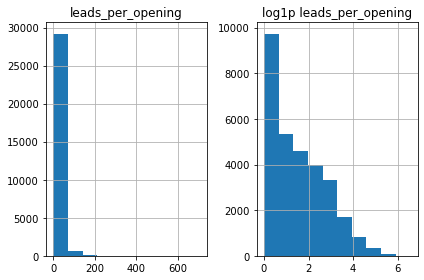

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
df.leads_per_opening.hist(ax=axes[0])
axes[0].set_title('leads_per_opening')
df.target.hist(ax=axes[1])
axes[1].set_title('log1p leads_per_opening')
plt.tight_layout()

In [22]:
df.target.describe()

count    30000.000000
mean         1.507317
std          1.264234
min          0.000000
25%          0.385158
50%          1.299283
75%          2.397895
max          6.559615
Name: target, dtype: float64

In [23]:
folds =[
    (df[(df.created_on<=df.created_on.quantile(0.7))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.7))&\
      (df.created_on<=df.created_on.quantile(0.8))].index.tolist()),
    
    (df[(df.created_on>=df.created_on.quantile(0.1))&\
      (df.created_on<=df.created_on.quantile(0.8))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.8))&\
      (df.created_on<=df.created_on.quantile(0.9))].index.tolist()),
    
    (df[(df.created_on>=df.created_on.quantile(0.2))&\
      (df.created_on<=df.created_on.quantile(0.9))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.9))&\
      (df.created_on<=df.created_on.quantile(1))].index.tolist())
]

In [24]:
[(df.iloc[i].shape[0]/df.shape[0],df.iloc[j].shape[0]/df.shape[0]) for i,j in folds]

[(0.7045666666666667, 0.10103333333333334),
 (0.7063666666666667, 0.0955),
 (0.7024333333333334, 0.0989)]

In [25]:
fe = FreqEnc(cat_freq_cols=cat_non_ord_cols)

In [26]:
df = fe.fit_transform(df)

In [27]:
target = df.target.values

In [28]:
df.shape

(30000, 28)

In [29]:
remove_cols = cat_non_ord_cols + ['target','leads_per_opening']

In [30]:
use_cols = [i for i in df.columns if i not in remove_cols]

In [31]:
use_cols

['education',
 'created_on',
 'applicant_location',
 'deposit',
 'english',
 'num_openings',
 'max_salary',
 'min_salary',
 'shift_fe',
 'gender_fe',
 'dow_fe',
 'employer_type_fe',
 'city_fe',
 'area_fe',
 'organization_fe',
 'category_fe',
 'is_part_time_fe']

In [34]:
lgbm_space = {
#    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.025),
    'n_estimators': 10000,
#     'early_stopping_rounds': 100,
    'num_leaves':  hp.quniform('num_leaves', 16, 80, 16),
#     'min_child_weight': hp.quniform('min_child_weight', 1, 40, 5),
    'min_child_samples': hp.quniform('min_child_samples', 1, 240, 40),
    'subsample': hp.quniform('subsample', 0.2, 1, 0.2),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.2, 1, 0.2),
    'subsample_freq': hp.choice('subsample_freq',[5,10]),
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'n_jobs': -1
}

In [35]:
hyp = HyperOptModelSelection(Estimator(model=LGBMRegressor(),
                                       early_stopping_rounds=100,
                                       validation_scheme=folds,
                                       shuffle=True),
                             space= lgbm_space,
                             max_evals=200,is_maximize=False,random_seed=100,
                             params_mapping = {'n_estimators':int, 'num_leaves':int, 
                                               'max_depth':int,'min_child_samples':int},          
                             log_file_path="hyperopt_log.txt")

In [36]:
hyp.fit(df[use_cols].values,target)

Starting HyperOpt 200 Evals with Dataset of Shape ((30000, 17),(30000,))



  0%|                                                                   | 0/200 [00:00<?, ?trial/s, best loss=?]


Iteration: 1, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.925616	valid_0's l2: 0.856765	valid_1's rmse: 0.74841	valid_1's l2: 0.560118            
[100]	valid_0's rmse: 0.860898	valid_0's l2: 0.741145	valid_1's rmse: 0.75356	valid_1's l2: 0.567852            
[200]	valid_0's rmse: 0.86522	valid_0's l2: 0.748606	valid_1's rmse: 0.673992	valid_1's l2: 0.454265            
[100]	valid_0's rmse: 0.893651	valid_0's l2: 0.798611	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[200]	valid_0's rmse: 0.901929	valid_0's l2: 0.813476	valid_1's rmse: 0.666584	valid_1's l2: 0.444335           
  0%|                                                                   | 0/200 [00:01<?, ?trial/s, best loss=?]

Score - 0.8913026575462172, Std - 0.027332270756328943, Eval Score - 0.8913026575462172
Score across folds - [0.9241338611842391, 0.8572189039335136, 0.8925552075208989].



  0%|▏                                        | 1/200 [00:01<05:19,  1.60s/trial, best loss: 0.8913026575462172]


Iteration: 2, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.922262	valid_0's l2: 0.850567	valid_1's rmse: 0.846526	valid_1's l2: 0.716606           
[200]	valid_0's rmse: 0.922517	valid_0's l2: 0.851038	valid_1's rmse: 0.815444	valid_1's l2: 0.664948           
[100]	valid_0's rmse: 0.866532	valid_0's l2: 0.750878	valid_1's rmse: 0.850477	valid_1's l2: 0.723312           
[200]	valid_0's rmse: 0.863475	valid_0's l2: 0.745589	valid_1's rmse: 0.818999	valid_1's l2: 0.670759           
[100]	valid_0's rmse: 0.889033	valid_0's l2: 0.790379	valid_1's rmse: 0.845173	valid_1's l2: 0.714318           
[200]	valid_0's rmse: 0.885384	valid_0's l2: 0.783904	valid_1's rmse: 0.813869	valid_1's l2: 0.662382           
  0%|▏                                        | 1/200 [00:03<05:19,  1.60s/trial, best loss: 0.8913026575462172]

Score - 0.8888194603419141, Std - 0.023921394608001148, Eval Score - 0.8888194603419141
Score across folds - [0.9205149446446627, 0.8627298001036665, 0.8832136362774128].



  1%|▍                                        | 2/200 [00:03<05:44,  1.74s/trial, best loss: 0.8888194603419141]


Iteration: 3, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.918912	valid_0's l2: 0.844399	valid_1's rmse: 0.844702	valid_1's l2: 0.713521           
[200]	valid_0's rmse: 0.913113	valid_0's l2: 0.833775	valid_1's rmse: 0.807747	valid_1's l2: 0.652454           
[100]	valid_0's rmse: 0.860707	valid_0's l2: 0.740817	valid_1's rmse: 0.845912	valid_1's l2: 0.715566           
[200]	valid_0's rmse: 0.848091	valid_0's l2: 0.719259	valid_1's rmse: 0.809845	valid_1's l2: 0.655849           
[300]	valid_0's rmse: 0.842542	valid_0's l2: 0.709877	valid_1's rmse: 0.785601	valid_1's l2: 0.617169           
[100]	valid_0's rmse: 0.890102	valid_0's l2: 0.792282	valid_1's rmse: 0.839853	valid_1's l2: 0.705354           
[200]	valid_0's rmse: 0.879083	valid_0's l2: 0.772787	valid_1's rmse: 0.805041	valid_1's l2: 0.648092           
[300]	valid_0's rmse: 0.876438	valid_0's l2: 0.768144	valid_1's rmse: 0.780782	valid_1's l2: 0.609621           
  1%|▍                                        | 2/200 [00:05<05:44,  1.74s/trial, best loss: 0.8

Score - 0.8767746607279255, Std - 0.028689009992602967, Eval Score - 0.8767746607279255
Score across folds - [0.9122522022938978, 0.8419889848047228, 0.8760827950851561].



  2%|▌                                        | 3/200 [00:05<06:41,  2.04s/trial, best loss: 0.8767746607279255]


Iteration: 4, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.2, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.93504	valid_0's l2: 0.8743	valid_1's rmse: 0.842103	valid_1's l2: 0.709138              
[200]	valid_0's rmse: 0.939201	valid_0's l2: 0.882099	valid_1's rmse: 0.810509	valid_1's l2: 0.656925           
[100]	valid_0's rmse: 0.884093	valid_0's l2: 0.78162	valid_1's rmse: 0.84708	valid_1's l2: 0.717544             
[200]	valid_0's rmse: 0.891022	valid_0's l2: 0.793921	valid_1's rmse: 0.813382	valid_1's l2: 0.661591           
[100]	valid_0's rmse: 0.904545	valid_0's l2: 0.818201	valid_1's rmse: 0.842554	valid_1's l2: 0.709897           
[200]	valid_0's rmse: 0.91082	valid_0's l2: 0.829593	valid_1's rmse: 0.807898	valid_1's l2: 0.652698            
  2%|▌                                        | 3/200 [00:07<06:41,  2.04s/trial, best loss: 0.8767746607279255]

Score - 0.9035596386830239, Std - 0.02106280078701856, Eval Score - 0.9035596386830239
Score across folds - [0.9299781934529555, 0.8784336781021542, 0.9022670444939622].



  2%|▊                                        | 4/200 [00:07<05:54,  1.81s/trial, best loss: 0.8767746607279255]


Iteration: 5, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.949118	valid_0's l2: 0.900825	valid_1's rmse: 0.904004	valid_1's l2: 0.817224           
[200]	valid_0's rmse: 0.928463	valid_0's l2: 0.862043	valid_1's rmse: 0.868192	valid_1's l2: 0.753757           
[300]	valid_0's rmse: 0.918417	valid_0's l2: 0.84349	valid_1's rmse: 0.849049	valid_1's l2: 0.720884            
[400]	valid_0's rmse: 0.914959	valid_0's l2: 0.83715	valid_1's rmse: 0.836067	valid_1's l2: 0.699009            
[500]	valid_0's rmse: 0.913664	valid_0's l2: 0.834782	valid_1's rmse: 0.826818	valid_1's l2: 0.683628           
[600]	valid_0's rmse: 0.914285	valid_0's l2: 0.835917	valid_1's rmse: 0.817874	valid_1's l2: 0.668918           
[700]	valid_0's rmse: 0.912394	valid_0's l2: 0.832462	valid_1's rmse: 0.811094	valid_1's l2: 0.657874           
[100]	valid_0's rmse: 0.911633	valid_0's l2: 0.831075	valid_1's rmse: 0.905995	valid_1's l2: 0.820827           
[200]	valid_0's rmse: 0.884081	valid_0's l2: 0.7816	valid_1's rmse: 0.869448	valid_1's l2: 0.755

Score - 0.8853714146003769, Std - 0.020098444259925876, Eval Score - 0.8853714146003769
Score across folds - [0.9110496970283305, 0.8619781011703185, 0.8830864456024822].



  2%|█                                        | 5/200 [00:10<08:01,  2.47s/trial, best loss: 0.8767746607279255]


Iteration: 6, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.915681	valid_0's l2: 0.838471	valid_1's rmse: 0.826173	valid_1's l2: 0.682562           
[200]	valid_0's rmse: 0.912409	valid_0's l2: 0.83249	valid_1's rmse: 0.782171	valid_1's l2: 0.611792            
[100]	valid_0's rmse: 0.853611	valid_0's l2: 0.728652	valid_1's rmse: 0.819379	valid_1's l2: 0.671383           
[200]	valid_0's rmse: 0.840157	valid_0's l2: 0.705863	valid_1's rmse: 0.771495	valid_1's l2: 0.595205           
[300]	valid_0's rmse: 0.842668	valid_0's l2: 0.710089	valid_1's rmse: 0.740824	valid_1's l2: 0.54882            
[100]	valid_0's rmse: 0.878855	valid_0's l2: 0.772386	valid_1's rmse: 0.815011	valid_1's l2: 0.664243           
[200]	valid_0's rmse: 0.878532	valid_0's l2: 0.771818	valid_1's rmse: 0.766868	valid_1's l2: 0.588086           
  2%|█                                        | 5/200 [00:12<08:01,  2.47s/trial, best loss: 0.8767746607279255]

Score - 0.8742537413213181, Std - 0.029647088118615366, Eval Score - 0.8742537413213181
Score across folds - [0.9108743890011063, 0.8382623294633174, 0.8736245054995305].



  3%|█▏                                       | 6/200 [00:12<07:15,  2.25s/trial, best loss: 0.8742537413213181]


Iteration: 7, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.92138	valid_0's l2: 0.848941	valid_1's rmse: 0.801815	valid_1's l2: 0.642907            
[100]	valid_0's rmse: 0.85654	valid_0's l2: 0.733661	valid_1's rmse: 0.804553	valid_1's l2: 0.647305            
[200]	valid_0's rmse: 0.85601	valid_0's l2: 0.732754	valid_1's rmse: 0.755482	valid_1's l2: 0.570753            
[300]	valid_0's rmse: 0.854253	valid_0's l2: 0.729749	valid_1's rmse: 0.720563	valid_1's l2: 0.519211           
[100]	valid_0's rmse: 0.881944	valid_0's l2: 0.777826	valid_1's rmse: 0.801833	valid_1's l2: 0.642937           
[200]	valid_0's rmse: 0.880648	valid_0's l2: 0.77554	valid_1's rmse: 0.753822	valid_1's l2: 0.568247            
  3%|█▏                                       | 6/200 [00:14<07:15,  2.25s/trial, best loss: 0.8742537413213181]

Score - 0.8828525577725598, Std - 0.028647364187609044, Eval Score - 0.8828525577725598
Score across folds - [0.9194100352976687, 0.849451969252217, 0.8796956687677934].



  4%|█▍                                       | 7/200 [00:15<07:39,  2.38s/trial, best loss: 0.8742537413213181]


Iteration: 8, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.941642	valid_0's l2: 0.88669	valid_1's rmse: 0.885306	valid_1's l2: 0.783766            
[200]	valid_0's rmse: 0.925076	valid_0's l2: 0.855765	valid_1's rmse: 0.843565	valid_1's l2: 0.711602           
[300]	valid_0's rmse: 0.918717	valid_0's l2: 0.844041	valid_1's rmse: 0.821335	valid_1's l2: 0.67459            
[400]	valid_0's rmse: 0.915147	valid_0's l2: 0.837495	valid_1's rmse: 0.805718	valid_1's l2: 0.649182           
[500]	valid_0's rmse: 0.91398	valid_0's l2: 0.83536	valid_1's rmse: 0.793761	valid_1's l2: 0.630056             
[600]	valid_0's rmse: 0.917201	valid_0's l2: 0.841258	valid_1's rmse: 0.78209	valid_1's l2: 0.611665            
[100]	valid_0's rmse: 0.896324	valid_0's l2: 0.803396	valid_1's rmse: 0.888449	valid_1's l2: 0.789342           
[200]	valid_0's rmse: 0.870525	valid_0's l2: 0.757813	valid_1's rmse: 0.845732	valid_1's l2: 0.715262           
[300]	valid_0's rmse: 0.856603	valid_0's l2: 0.733768	valid_1's rmse: 0.823095	valid_1's l2: 0.6

Score - 0.8826750754586739, Std - 0.02503153598325204, Eval Score - 0.8826750754586739
Score across folds - [0.9137142625752049, 0.852414608863848, 0.8818963549369686].



  4%|█▋                                       | 8/200 [00:19<08:51,  2.77s/trial, best loss: 0.8742537413213181]


Iteration: 9, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.919569	valid_0's l2: 0.845606	valid_1's rmse: 0.79472	valid_1's l2: 0.631579            
[200]	valid_0's rmse: 0.926656	valid_0's l2: 0.858692	valid_1's rmse: 0.744766	valid_1's l2: 0.554676           
[100]	valid_0's rmse: 0.852557	valid_0's l2: 0.726853	valid_1's rmse: 0.797425	valid_1's l2: 0.635887           
[200]	valid_0's rmse: 0.846249	valid_0's l2: 0.716137	valid_1's rmse: 0.748205	valid_1's l2: 0.559811           
[300]	valid_0's rmse: 0.846686	valid_0's l2: 0.716877	valid_1's rmse: 0.71129	valid_1's l2: 0.505934            
[100]	valid_0's rmse: 0.878345	valid_0's l2: 0.771489	valid_1's rmse: 0.792967	valid_1's l2: 0.628796           
[200]	valid_0's rmse: 0.882931	valid_0's l2: 0.779567	valid_1's rmse: 0.743143	valid_1's l2: 0.552261           
  4%|█▋                                       | 8/200 [00:21<08:51,  2.77s/trial, best loss: 0.8742537413213181]

Score - 0.8791113994909535, Std - 0.03134170313533451, Eval Score - 0.8791113994909535
Score across folds - [0.9184219289862294, 0.8417229670557326, 0.8771893024308983].



  4%|█▊                                       | 9/200 [00:21<08:25,  2.65s/trial, best loss: 0.8742537413213181]


Iteration: 10, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 80, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.932118	valid_0's l2: 0.868844	valid_1's rmse: 0.707999	valid_1's l2: 0.501262           
[100]	valid_0's rmse: 0.84198	valid_0's l2: 0.70893	valid_1's rmse: 0.710437	valid_1's l2: 0.504721             
[200]	valid_0's rmse: 0.847418	valid_0's l2: 0.718118	valid_1's rmse: 0.621302	valid_1's l2: 0.386016           
[100]	valid_0's rmse: 0.885078	valid_0's l2: 0.783364	valid_1's rmse: 0.706699	valid_1's l2: 0.499423           
  4%|█▊                                       | 9/200 [00:23<08:25,  2.65s/trial, best loss: 0.8742537413213181]

Score - 0.8850821988324137, Std - 0.03565472886804262, Eval Score - 0.8850821988324137
Score across folds - [0.9288355076208606, 0.8415001185375645, 0.8849109703388158].



  5%|██                                      | 10/200 [00:23<07:57,  2.51s/trial, best loss: 0.8742537413213181]


Iteration: 11, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.922773	valid_0's l2: 0.851511	valid_1's rmse: 0.844957	valid_1's l2: 0.713952           
[200]	valid_0's rmse: 0.916675	valid_0's l2: 0.840293	valid_1's rmse: 0.807294	valid_1's l2: 0.651723           
[300]	valid_0's rmse: 0.917721	valid_0's l2: 0.842211	valid_1's rmse: 0.782153	valid_1's l2: 0.611764           
[100]	valid_0's rmse: 0.861149	valid_0's l2: 0.741577	valid_1's rmse: 0.845439	valid_1's l2: 0.714766           
[200]	valid_0's rmse: 0.852048	valid_0's l2: 0.725986	valid_1's rmse: 0.807762	valid_1's l2: 0.65248            
[300]	valid_0's rmse: 0.84917	valid_0's l2: 0.72109	valid_1's rmse: 0.782082	valid_1's l2: 0.611652             
[100]	valid_0's rmse: 0.887587	valid_0's l2: 0.787811	valid_1's rmse: 0.839881	valid_1's l2: 0.7054             
[200]	valid_0's rmse: 0.878888	valid_0's l2: 0.772444	valid_1's rmse: 0.80413	valid_1's l2: 0.646625            
[300]	valid_0's rmse: 0.877089	valid_0's l2: 0.769285	valid_1's rmse: 0.778812	valid_1's l2: 0.6

Score - 0.8795871335337808, Std - 0.027138897819020038, Eval Score - 0.8795871335337808
Score across folds - [0.9143446760922523, 0.8481117460393377, 0.8763049784697525].



  6%|██▏                                     | 11/200 [00:26<08:29,  2.69s/trial, best loss: 0.8742537413213181]


Iteration: 12, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.941642	valid_0's l2: 0.88669	valid_1's rmse: 0.885306	valid_1's l2: 0.783766            
[200]	valid_0's rmse: 0.925076	valid_0's l2: 0.855765	valid_1's rmse: 0.843565	valid_1's l2: 0.711602           
[300]	valid_0's rmse: 0.918717	valid_0's l2: 0.844041	valid_1's rmse: 0.821335	valid_1's l2: 0.67459            
[400]	valid_0's rmse: 0.915147	valid_0's l2: 0.837495	valid_1's rmse: 0.805718	valid_1's l2: 0.649182           
[500]	valid_0's rmse: 0.91398	valid_0's l2: 0.83536	valid_1's rmse: 0.793761	valid_1's l2: 0.630056             
[600]	valid_0's rmse: 0.917201	valid_0's l2: 0.841258	valid_1's rmse: 0.78209	valid_1's l2: 0.611665            
[100]	valid_0's rmse: 0.896324	valid_0's l2: 0.803396	valid_1's rmse: 0.888449	valid_1's l2: 0.789342           
[200]	valid_0's rmse: 0.870525	valid_0's l2: 0.757813	valid_1's rmse: 0.845732	valid_1's l2: 0.715262           
[300]	valid_0's rmse: 0.856603	valid_0's l2: 0.733768	valid_1's rmse: 0.823095	valid_1's l2: 0.6

Score - 0.8826750754586739, Std - 0.02503153598325204, Eval Score - 0.8826750754586739
Score across folds - [0.9137142625752049, 0.852414608863848, 0.8818963549369686].



  6%|██▍                                     | 12/200 [00:30<09:16,  2.96s/trial, best loss: 0.8742537413213181]


Iteration: 13, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.921095	valid_0's l2: 0.848416	valid_1's rmse: 0.859479	valid_1's l2: 0.738704           
[200]	valid_0's rmse: 0.912902	valid_0's l2: 0.83339	valid_1's rmse: 0.822348	valid_1's l2: 0.676257            
[300]	valid_0's rmse: 0.912664	valid_0's l2: 0.832956	valid_1's rmse: 0.799836	valid_1's l2: 0.639738           
[400]	valid_0's rmse: 0.913445	valid_0's l2: 0.834382	valid_1's rmse: 0.782148	valid_1's l2: 0.611755           
[100]	valid_0's rmse: 0.861172	valid_0's l2: 0.741618	valid_1's rmse: 0.854879	valid_1's l2: 0.730818           
[200]	valid_0's rmse: 0.844062	valid_0's l2: 0.712441	valid_1's rmse: 0.818413	valid_1's l2: 0.669799           
[300]	valid_0's rmse: 0.840319	valid_0's l2: 0.706136	valid_1's rmse: 0.796966	valid_1's l2: 0.635155           
[400]	valid_0's rmse: 0.838241	valid_0's l2: 0.702648	valid_1's rmse: 0.77883	valid_1's l2: 0.606576            
[500]	valid_0's rmse: 0.837888	valid_0's l2: 0.702056	valid_1's rmse: 0.762697	valid_1's l2: 0.5

Score - 0.8745981216527271, Std - 0.030731965742251663, Eval Score - 0.8745981216527271
Score across folds - [0.911755958780998, 0.8364960903107567, 0.8755423158664264].



  6%|██▌                                     | 13/200 [00:32<08:23,  2.69s/trial, best loss: 0.8742537413213181]


Iteration: 14, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916361	valid_0's l2: 0.839718	valid_1's rmse: 0.79612	valid_1's l2: 0.633807            
[100]	valid_0's rmse: 0.853195	valid_0's l2: 0.727941	valid_1's rmse: 0.799134	valid_1's l2: 0.638614           
[200]	valid_0's rmse: 0.84477	valid_0's l2: 0.713636	valid_1's rmse: 0.750187	valid_1's l2: 0.562781            
[300]	valid_0's rmse: 0.848305	valid_0's l2: 0.719622	valid_1's rmse: 0.714047	valid_1's l2: 0.509863           
[100]	valid_0's rmse: 0.876777	valid_0's l2: 0.768738	valid_1's rmse: 0.795311	valid_1's l2: 0.632519           
[200]	valid_0's rmse: 0.87612	valid_0's l2: 0.767587	valid_1's rmse: 0.745888	valid_1's l2: 0.556348            
  6%|██▌                                     | 13/200 [00:34<08:23,  2.69s/trial, best loss: 0.8742537413213181]

Score - 0.8770845713691208, Std - 0.029091283267249923, Eval Score - 0.8770845713691208
Score across folds - [0.913859885746972, 0.8427239265914339, 0.8746699017689563].



  7%|██▊                                     | 14/200 [00:34<07:54,  2.55s/trial, best loss: 0.8742537413213181]


Iteration: 15, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.915435	valid_0's l2: 0.838021	valid_1's rmse: 0.815779	valid_1's l2: 0.665495           
[200]	valid_0's rmse: 0.911117	valid_0's l2: 0.830135	valid_1's rmse: 0.767838	valid_1's l2: 0.589576           
[100]	valid_0's rmse: 0.855106	valid_0's l2: 0.731206	valid_1's rmse: 0.819029	valid_1's l2: 0.670808           
[200]	valid_0's rmse: 0.848185	valid_0's l2: 0.719418	valid_1's rmse: 0.771965	valid_1's l2: 0.59593            
[300]	valid_0's rmse: 0.845372	valid_0's l2: 0.714654	valid_1's rmse: 0.736981	valid_1's l2: 0.543141           
[400]	valid_0's rmse: 0.849038	valid_0's l2: 0.720866	valid_1's rmse: 0.710198	valid_1's l2: 0.504381           
[100]	valid_0's rmse: 0.88706	valid_0's l2: 0.786875	valid_1's rmse: 0.814763	valid_1's l2: 0.663839            
[200]	valid_0's rmse: 0.880671	valid_0's l2: 0.775581	valid_1's rmse: 0.766649	valid_1's l2: 0.587751           
[300]	valid_0's rmse: 0.88365	valid_0's l2: 0.780837	valid_1's rmse: 0.731649	valid_1's l2: 0.53

Score - 0.8782828530431805, Std - 0.02662247984627177, Eval Score - 0.8782828530431805
Score across folds - [0.9099348257345783, 0.8448004480825706, 0.8801132853123927].



  8%|███                                     | 15/200 [00:37<08:19,  2.70s/trial, best loss: 0.8742537413213181]


Iteration: 16, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.919758	valid_0's l2: 0.845955	valid_1's rmse: 0.83738	valid_1's l2: 0.701205            
[200]	valid_0's rmse: 0.918198	valid_0's l2: 0.843087	valid_1's rmse: 0.801152	valid_1's l2: 0.641845           
[100]	valid_0's rmse: 0.858661	valid_0's l2: 0.737298	valid_1's rmse: 0.840292	valid_1's l2: 0.70609            
[200]	valid_0's rmse: 0.84851	valid_0's l2: 0.71997	valid_1's rmse: 0.804631	valid_1's l2: 0.647432             
[300]	valid_0's rmse: 0.840925	valid_0's l2: 0.707155	valid_1's rmse: 0.779481	valid_1's l2: 0.607591           
[400]	valid_0's rmse: 0.843241	valid_0's l2: 0.711056	valid_1's rmse: 0.760517	valid_1's l2: 0.578386           
[100]	valid_0's rmse: 0.896182	valid_0's l2: 0.803143	valid_1's rmse: 0.836527	valid_1's l2: 0.699778           
[200]	valid_0's rmse: 0.881888	valid_0's l2: 0.777726	valid_1's rmse: 0.799043	valid_1's l2: 0.63847            
[300]	valid_0's rmse: 0.883596	valid_0's l2: 0.780743	valid_1's rmse: 0.773964	valid_1's l2: 0.5

Score - 0.8795768242717128, Std - 0.031110887934048228, Eval Score - 0.8795768242717128
Score across folds - [0.917106274846554, 0.840925262213949, 0.8806989357546354].



  8%|███▏                                    | 16/200 [00:39<07:42,  2.52s/trial, best loss: 0.8742537413213181]


Iteration: 17, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 240, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 80, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.925252	valid_0's l2: 0.856092	valid_1's rmse: 0.853542	valid_1's l2: 0.728534           
[200]	valid_0's rmse: 0.916274	valid_0's l2: 0.839559	valid_1's rmse: 0.81962	valid_1's l2: 0.671777            
[300]	valid_0's rmse: 0.917052	valid_0's l2: 0.840984	valid_1's rmse: 0.797256	valid_1's l2: 0.635617           
[100]	valid_0's rmse: 0.865137	valid_0's l2: 0.748461	valid_1's rmse: 0.855948	valid_1's l2: 0.732646           
[200]	valid_0's rmse: 0.853701	valid_0's l2: 0.728806	valid_1's rmse: 0.821815	valid_1's l2: 0.67538            
[300]	valid_0's rmse: 0.852241	valid_0's l2: 0.726315	valid_1's rmse: 0.799766	valid_1's l2: 0.639626           
[100]	valid_0's rmse: 0.89167	valid_0's l2: 0.795075	valid_1's rmse: 0.850971	valid_1's l2: 0.724152            
[200]	valid_0's rmse: 0.881385	valid_0's l2: 0.776839	valid_1's rmse: 0.818497	valid_1's l2: 0.669937           
[300]	valid_0's rmse: 0.878966	valid_0's l2: 0.772581	valid_1's rmse: 0.796035	valid_1's l2: 0.6

Score - 0.8813647354985367, Std - 0.02594197292096072, Eval Score - 0.8813647354985367
Score across folds - [0.9146763890853572, 0.8513961614292431, 0.8780216559810092].



  8%|███▍                                    | 17/200 [00:42<07:54,  2.59s/trial, best loss: 0.8742537413213181]


Iteration: 18, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.920628	valid_0's l2: 0.847556	valid_1's rmse: 0.786459	valid_1's l2: 0.618517           
[200]	valid_0's rmse: 0.923482	valid_0's l2: 0.852819	valid_1's rmse: 0.728428	valid_1's l2: 0.530607           
[100]	valid_0's rmse: 0.852831	valid_0's l2: 0.727321	valid_1's rmse: 0.774695	valid_1's l2: 0.600153           
[200]	valid_0's rmse: 0.849578	valid_0's l2: 0.721783	valid_1's rmse: 0.708704	valid_1's l2: 0.502262           
[100]	valid_0's rmse: 0.88913	valid_0's l2: 0.790553	valid_1's rmse: 0.771888	valid_1's l2: 0.595811            
[200]	valid_0's rmse: 0.883222	valid_0's l2: 0.780081	valid_1's rmse: 0.70451	valid_1's l2: 0.496335            
  8%|███▍                                    | 17/200 [00:44<07:54,  2.59s/trial, best loss: 0.8742537413213181]

Score - 0.8817225895185737, Std - 0.02963733505710184, Eval Score - 0.8817225895185737
Score across folds - [0.9188464488799238, 0.8463106822854092, 0.8800106373903881].



  9%|███▌                                    | 18/200 [00:44<07:40,  2.53s/trial, best loss: 0.8742537413213181]


Iteration: 19, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 0.2, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.932745	valid_0's l2: 0.870013	valid_1's rmse: 0.837175	valid_1's l2: 0.700862           
[200]	valid_0's rmse: 0.932933	valid_0's l2: 0.870364	valid_1's rmse: 0.804621	valid_1's l2: 0.647414           
[100]	valid_0's rmse: 0.878652	valid_0's l2: 0.772029	valid_1's rmse: 0.839553	valid_1's l2: 0.704849           
[200]	valid_0's rmse: 0.868495	valid_0's l2: 0.754283	valid_1's rmse: 0.804021	valid_1's l2: 0.64645            
[100]	valid_0's rmse: 0.897441	valid_0's l2: 0.8054	valid_1's rmse: 0.836668	valid_1's l2: 0.700014             
[200]	valid_0's rmse: 0.897287	valid_0's l2: 0.805124	valid_1's rmse: 0.803632	valid_1's l2: 0.645824           
  9%|███▌                                    | 18/200 [00:46<07:40,  2.53s/trial, best loss: 0.8742537413213181]

Score - 0.894155003710568, Std - 0.02707183529004853, Eval Score - 0.894155003710568
Score across folds - [0.9281695739749378, 0.8619298620849422, 0.8923655750718245].



 10%|███▊                                    | 19/200 [00:46<07:02,  2.33s/trial, best loss: 0.8742537413213181]


Iteration: 20, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 240, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916827	valid_0's l2: 0.840572	valid_1's rmse: 0.82751	valid_1's l2: 0.684772            
[200]	valid_0's rmse: 0.911328	valid_0's l2: 0.830519	valid_1's rmse: 0.786413	valid_1's l2: 0.618446           
[300]	valid_0's rmse: 0.912122	valid_0's l2: 0.831966	valid_1's rmse: 0.757764	valid_1's l2: 0.574207           
[100]	valid_0's rmse: 0.855161	valid_0's l2: 0.7313	valid_1's rmse: 0.8296	valid_1's l2: 0.688235               
[200]	valid_0's rmse: 0.844549	valid_0's l2: 0.713263	valid_1's rmse: 0.789028	valid_1's l2: 0.622565           
[300]	valid_0's rmse: 0.84335	valid_0's l2: 0.711239	valid_1's rmse: 0.760813	valid_1's l2: 0.578837            
[100]	valid_0's rmse: 0.884251	valid_0's l2: 0.781899	valid_1's rmse: 0.825509	valid_1's l2: 0.681465           
[200]	valid_0's rmse: 0.876034	valid_0's l2: 0.767435	valid_1's rmse: 0.784204	valid_1's l2: 0.614976           
[300]	valid_0's rmse: 0.875711	valid_0's l2: 0.766869	valid_1's rmse: 0.756049	valid_1's l2: 0.5

Score - 0.8760780289129134, Std - 0.028206212090032427, Eval Score - 0.8760780289129134
Score across folds - [0.9112585198185073, 0.8422048047574064, 0.8747707621628265].



 10%|████                                    | 20/200 [00:49<07:22,  2.46s/trial, best loss: 0.8742537413213181]


Iteration: 21, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.946728	valid_0's l2: 0.896293	valid_1's rmse: 0.896608	valid_1's l2: 0.803905           
[200]	valid_0's rmse: 0.921437	valid_0's l2: 0.849046	valid_1's rmse: 0.849385	valid_1's l2: 0.721455           
[300]	valid_0's rmse: 0.913709	valid_0's l2: 0.834865	valid_1's rmse: 0.825406	valid_1's l2: 0.681294           
[400]	valid_0's rmse: 0.91146	valid_0's l2: 0.830759	valid_1's rmse: 0.805778	valid_1's l2: 0.649278            
[500]	valid_0's rmse: 0.910104	valid_0's l2: 0.828289	valid_1's rmse: 0.791049	valid_1's l2: 0.625759           
[600]	valid_0's rmse: 0.909641	valid_0's l2: 0.827447	valid_1's rmse: 0.778603	valid_1's l2: 0.606223           
[100]	valid_0's rmse: 0.902345	valid_0's l2: 0.814226	valid_1's rmse: 0.899013	valid_1's l2: 0.808225           
[200]	valid_0's rmse: 0.866184	valid_0's l2: 0.750275	valid_1's rmse: 0.852268	valid_1's l2: 0.72636            
[300]	valid_0's rmse: 0.858397	valid_0's l2: 0.736846	valid_1's rmse: 0.828702	valid_1's l2: 0.6

Score - 0.8766109835782375, Std - 0.026561724813202146, Eval Score - 0.8766109835782375
Score across folds - [0.9085959138612472, 0.8435594735141212, 0.8776775633593442].



 10%|████▏                                   | 21/200 [00:52<08:03,  2.70s/trial, best loss: 0.8742537413213181]


Iteration: 22, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.940217	valid_0's l2: 0.884009	valid_1's rmse: 0.891661	valid_1's l2: 0.79506            
[200]	valid_0's rmse: 0.919937	valid_0's l2: 0.846285	valid_1's rmse: 0.850228	valid_1's l2: 0.722888           
[300]	valid_0's rmse: 0.914941	valid_0's l2: 0.837118	valid_1's rmse: 0.827918	valid_1's l2: 0.685449           
[400]	valid_0's rmse: 0.911129	valid_0's l2: 0.830157	valid_1's rmse: 0.812366	valid_1's l2: 0.659939           
[100]	valid_0's rmse: 0.905408	valid_0's l2: 0.819764	valid_1's rmse: 0.901414	valid_1's l2: 0.812548           
[200]	valid_0's rmse: 0.867988	valid_0's l2: 0.753402	valid_1's rmse: 0.857232	valid_1's l2: 0.734847           
[300]	valid_0's rmse: 0.854317	valid_0's l2: 0.729857	valid_1's rmse: 0.83565	valid_1's l2: 0.698312            
[400]	valid_0's rmse: 0.845421	valid_0's l2: 0.714736	valid_1's rmse: 0.818466	valid_1's l2: 0.669886           
[500]	valid_0's rmse: 0.842903	valid_0's l2: 0.710485	valid_1's rmse: 0.806721	valid_1's l2: 0.6

Score - 0.8759630463185403, Std - 0.02953732812918, Eval Score - 0.8759630463185403
Score across folds - [0.9109591634582792, 0.8387131658485897, 0.8782168096487524].



 11%|████▍                                   | 22/200 [00:55<07:59,  2.69s/trial, best loss: 0.8742537413213181]


Iteration: 23, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.913177	valid_0's l2: 0.833892	valid_1's rmse: 0.836778	valid_1's l2: 0.700197           
[200]	valid_0's rmse: 0.912965	valid_0's l2: 0.833505	valid_1's rmse: 0.795118	valid_1's l2: 0.632213           
[100]	valid_0's rmse: 0.856184	valid_0's l2: 0.733051	valid_1's rmse: 0.840651	valid_1's l2: 0.706694           
[200]	valid_0's rmse: 0.849281	valid_0's l2: 0.721279	valid_1's rmse: 0.796964	valid_1's l2: 0.635152           
[300]	valid_0's rmse: 0.846634	valid_0's l2: 0.71679	valid_1's rmse: 0.765776	valid_1's l2: 0.586413            
[400]	valid_0's rmse: 0.85086	valid_0's l2: 0.723962	valid_1's rmse: 0.740424	valid_1's l2: 0.548228            
[100]	valid_0's rmse: 0.889853	valid_0's l2: 0.791839	valid_1's rmse: 0.836482	valid_1's l2: 0.699702           
[200]	valid_0's rmse: 0.887419	valid_0's l2: 0.787513	valid_1's rmse: 0.792921	valid_1's l2: 0.628723           
 11%|████▍                                   | 22/200 [00:56<07:59,  2.69s/trial, best loss: 0.8

Score - 0.8808113934837413, Std - 0.026847546215549023, Eval Score - 0.8808113934837413
Score across folds - [0.9110435437151431, 0.8458031358335992, 0.8855875009024815].



 12%|████▌                                   | 23/200 [00:56<06:41,  2.27s/trial, best loss: 0.8742537413213181]


Iteration: 24, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.921095	valid_0's l2: 0.848416	valid_1's rmse: 0.859479	valid_1's l2: 0.738704           
[200]	valid_0's rmse: 0.912902	valid_0's l2: 0.83339	valid_1's rmse: 0.822348	valid_1's l2: 0.676257            
[300]	valid_0's rmse: 0.912664	valid_0's l2: 0.832956	valid_1's rmse: 0.799836	valid_1's l2: 0.639738           
[400]	valid_0's rmse: 0.913445	valid_0's l2: 0.834382	valid_1's rmse: 0.782148	valid_1's l2: 0.611755           
[100]	valid_0's rmse: 0.861172	valid_0's l2: 0.741618	valid_1's rmse: 0.854879	valid_1's l2: 0.730818           
[200]	valid_0's rmse: 0.844062	valid_0's l2: 0.712441	valid_1's rmse: 0.818413	valid_1's l2: 0.669799           
[300]	valid_0's rmse: 0.840319	valid_0's l2: 0.706136	valid_1's rmse: 0.796966	valid_1's l2: 0.635155           
[400]	valid_0's rmse: 0.838241	valid_0's l2: 0.702648	valid_1's rmse: 0.77883	valid_1's l2: 0.606576            
[500]	valid_0's rmse: 0.837888	valid_0's l2: 0.702056	valid_1's rmse: 0.762697	valid_1's l2: 0.5

Score - 0.8745981216527271, Std - 0.030731965742251663, Eval Score - 0.8745981216527271
Score across folds - [0.911755958780998, 0.8364960903107567, 0.8755423158664264].



 12%|████▊                                   | 24/200 [00:58<06:28,  2.20s/trial, best loss: 0.8742537413213181]


Iteration: 25, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.940406	valid_0's l2: 0.884364	valid_1's rmse: 0.893683	valid_1's l2: 0.798669           
[200]	valid_0's rmse: 0.919406	valid_0's l2: 0.845307	valid_1's rmse: 0.852884	valid_1's l2: 0.727412           
[300]	valid_0's rmse: 0.913631	valid_0's l2: 0.834722	valid_1's rmse: 0.831597	valid_1's l2: 0.691553           
[400]	valid_0's rmse: 0.911234	valid_0's l2: 0.830347	valid_1's rmse: 0.818401	valid_1's l2: 0.66978            
[100]	valid_0's rmse: 0.89593	valid_0's l2: 0.802691	valid_1's rmse: 0.896132	valid_1's l2: 0.803052            
[200]	valid_0's rmse: 0.86248	valid_0's l2: 0.743873	valid_1's rmse: 0.855112	valid_1's l2: 0.731217            
[300]	valid_0's rmse: 0.851103	valid_0's l2: 0.724377	valid_1's rmse: 0.833805	valid_1's l2: 0.69523            
[400]	valid_0's rmse: 0.845169	valid_0's l2: 0.714311	valid_1's rmse: 0.820022	valid_1's l2: 0.672436           
[500]	valid_0's rmse: 0.842588	valid_0's l2: 0.709954	valid_1's rmse: 0.810606	valid_1's l2: 0.6

Score - 0.8761137985459605, Std - 0.0293009155866915, Eval Score - 0.8761137985459605
Score across folds - [0.9104758831308082, 0.8388765642279935, 0.87898894827908].



 12%|█████                                   | 25/200 [01:01<06:54,  2.37s/trial, best loss: 0.8742537413213181]


Iteration: 26, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.915888	valid_0's l2: 0.838851	valid_1's rmse: 0.79318	valid_1's l2: 0.629135            
[100]	valid_0's rmse: 0.854731	valid_0's l2: 0.730565	valid_1's rmse: 0.796238	valid_1's l2: 0.633994           
[200]	valid_0's rmse: 0.850693	valid_0's l2: 0.723678	valid_1's rmse: 0.734877	valid_1's l2: 0.540044           
[300]	valid_0's rmse: 0.850245	valid_0's l2: 0.722916	valid_1's rmse: 0.690445	valid_1's l2: 0.476715           
[100]	valid_0's rmse: 0.888745	valid_0's l2: 0.789868	valid_1's rmse: 0.790023	valid_1's l2: 0.624136           
[200]	valid_0's rmse: 0.889156	valid_0's l2: 0.790599	valid_1's rmse: 0.729094	valid_1's l2: 0.531579           
 12%|█████                                   | 25/200 [01:03<06:54,  2.37s/trial, best loss: 0.8742537413213181]

Score - 0.8833543897830866, Std - 0.02723129193917353, Eval Score - 0.8833543897830866
Score across folds - [0.9150291074206014, 0.84854734230182, 0.8864867196268382].



 13%|█████▏                                  | 26/200 [01:03<06:15,  2.16s/trial, best loss: 0.8742537413213181]


Iteration: 27, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.919107	valid_0's l2: 0.844757	valid_1's rmse: 0.8594	valid_1's l2: 0.738569             
[200]	valid_0's rmse: 0.908883	valid_0's l2: 0.826068	valid_1's rmse: 0.822666	valid_1's l2: 0.676779           
[300]	valid_0's rmse: 0.908268	valid_0's l2: 0.824951	valid_1's rmse: 0.799167	valid_1's l2: 0.638668           
[100]	valid_0's rmse: 0.862619	valid_0's l2: 0.744111	valid_1's rmse: 0.855122	valid_1's l2: 0.731234           
[200]	valid_0's rmse: 0.843966	valid_0's l2: 0.712279	valid_1's rmse: 0.818456	valid_1's l2: 0.669871           
[300]	valid_0's rmse: 0.840804	valid_0's l2: 0.706952	valid_1's rmse: 0.796693	valid_1's l2: 0.63472            
[100]	valid_0's rmse: 0.888503	valid_0's l2: 0.789438	valid_1's rmse: 0.850636	valid_1's l2: 0.723581           
[200]	valid_0's rmse: 0.876466	valid_0's l2: 0.768192	valid_1's rmse: 0.814647	valid_1's l2: 0.663649           
[300]	valid_0's rmse: 0.875432	valid_0's l2: 0.766381	valid_1's rmse: 0.792736	valid_1's l2: 0.6

Score - 0.873264361755271, Std - 0.02736171826078459, Eval Score - 0.873264361755271
Score across folds - [0.9065594743252128, 0.839541324554964, 0.8736922863856363].



 14%|█████▌                                   | 27/200 [01:04<05:53,  2.04s/trial, best loss: 0.873264361755271]


Iteration: 28, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.936484	valid_0's l2: 0.877002	valid_1's rmse: 0.871883	valid_1's l2: 0.76018            
[200]	valid_0's rmse: 0.917334	valid_0's l2: 0.841501	valid_1's rmse: 0.824161	valid_1's l2: 0.679242           
[300]	valid_0's rmse: 0.913909	valid_0's l2: 0.835229	valid_1's rmse: 0.798224	valid_1's l2: 0.637161           
[400]	valid_0's rmse: 0.912988	valid_0's l2: 0.833546	valid_1's rmse: 0.78054	valid_1's l2: 0.609243            
[100]	valid_0's rmse: 0.88517	valid_0's l2: 0.783526	valid_1's rmse: 0.874802	valid_1's l2: 0.765279            
[200]	valid_0's rmse: 0.858821	valid_0's l2: 0.737573	valid_1's rmse: 0.826566	valid_1's l2: 0.683211           
[300]	valid_0's rmse: 0.847956	valid_0's l2: 0.719029	valid_1's rmse: 0.800293	valid_1's l2: 0.640469           
[400]	valid_0's rmse: 0.842751	valid_0's l2: 0.71023	valid_1's rmse: 0.782092	valid_1's l2: 0.611668            
[500]	valid_0's rmse: 0.841659	valid_0's l2: 0.70839	valid_1's rmse: 0.768999	valid_1's l2: 0.59

Score - 0.8766060972263016, Std - 0.029173866179410594, Eval Score - 0.8766060972263016
Score across folds - [0.9122255368102227, 0.8407654777181099, 0.8768272771505724].



 14%|█████▋                                   | 28/200 [01:07<06:41,  2.34s/trial, best loss: 0.873264361755271]


Iteration: 29, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.918226	valid_0's l2: 0.843139	valid_1's rmse: 0.841332	valid_1's l2: 0.70784            
[200]	valid_0's rmse: 0.910563	valid_0's l2: 0.829125	valid_1's rmse: 0.79996	valid_1's l2: 0.639936            
[100]	valid_0's rmse: 0.861095	valid_0's l2: 0.741485	valid_1's rmse: 0.844557	valid_1's l2: 0.713277           
[200]	valid_0's rmse: 0.849645	valid_0's l2: 0.721896	valid_1's rmse: 0.802854	valid_1's l2: 0.644574           
[300]	valid_0's rmse: 0.8554	valid_0's l2: 0.731709	valid_1's rmse: 0.773242	valid_1's l2: 0.597903             
[100]	valid_0's rmse: 0.88641	valid_0's l2: 0.785723	valid_1's rmse: 0.841856	valid_1's l2: 0.708721            
[200]	valid_0's rmse: 0.879909	valid_0's l2: 0.77424	valid_1's rmse: 0.800866	valid_1's l2: 0.641387            
[300]	valid_0's rmse: 0.885807	valid_0's l2: 0.784654	valid_1's rmse: 0.77103	valid_1's l2: 0.594487            
 14%|█████▋                                   | 28/200 [01:09<06:41,  2.34s/trial, best loss: 0.

Score - 0.8785746218359286, Std - 0.025437761925182933, Eval Score - 0.8785746218359286
Score across folds - [0.9101467436243492, 0.8478546919863443, 0.8777224298970925].



 14%|█████▉                                   | 29/200 [01:09<05:57,  2.09s/trial, best loss: 0.873264361755271]


Iteration: 30, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.920654	valid_0's l2: 0.847604	valid_1's rmse: 0.784077	valid_1's l2: 0.614777           
[200]	valid_0's rmse: 0.923955	valid_0's l2: 0.853692	valid_1's rmse: 0.721078	valid_1's l2: 0.519953           
[100]	valid_0's rmse: 0.854792	valid_0's l2: 0.73067	valid_1's rmse: 0.787422	valid_1's l2: 0.620034            
[200]	valid_0's rmse: 0.852536	valid_0's l2: 0.726817	valid_1's rmse: 0.727205	valid_1's l2: 0.528827           
[300]	valid_0's rmse: 0.853529	valid_0's l2: 0.728511	valid_1's rmse: 0.680653	valid_1's l2: 0.463289           
[100]	valid_0's rmse: 0.88442	valid_0's l2: 0.782199	valid_1's rmse: 0.784479	valid_1's l2: 0.615407            
 14%|█████▉                                   | 29/200 [01:10<05:57,  2.09s/trial, best loss: 0.873264361755271]

Score - 0.8829999434265859, Std - 0.027393759264254223, Eval Score - 0.8829999434265859
Score across folds - [0.9171847490277523, 0.8501222192973215, 0.881692861954684].



 15%|██████▏                                  | 30/200 [01:10<05:15,  1.86s/trial, best loss: 0.873264361755271]


Iteration: 31, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.919107	valid_0's l2: 0.844757	valid_1's rmse: 0.8594	valid_1's l2: 0.738569             
[200]	valid_0's rmse: 0.908883	valid_0's l2: 0.826068	valid_1's rmse: 0.822666	valid_1's l2: 0.676779           
[300]	valid_0's rmse: 0.908268	valid_0's l2: 0.824951	valid_1's rmse: 0.799167	valid_1's l2: 0.638668           
[100]	valid_0's rmse: 0.862619	valid_0's l2: 0.744111	valid_1's rmse: 0.855122	valid_1's l2: 0.731234           
[200]	valid_0's rmse: 0.843966	valid_0's l2: 0.712279	valid_1's rmse: 0.818456	valid_1's l2: 0.669871           
[300]	valid_0's rmse: 0.840804	valid_0's l2: 0.706952	valid_1's rmse: 0.796693	valid_1's l2: 0.63472            
[100]	valid_0's rmse: 0.888503	valid_0's l2: 0.789438	valid_1's rmse: 0.850636	valid_1's l2: 0.723581           
[200]	valid_0's rmse: 0.876466	valid_0's l2: 0.768192	valid_1's rmse: 0.814647	valid_1's l2: 0.663649           
[300]	valid_0's rmse: 0.875432	valid_0's l2: 0.766381	valid_1's rmse: 0.792736	valid_1's l2: 0.6

Score - 0.873264361755271, Std - 0.02736171826078459, Eval Score - 0.873264361755271
Score across folds - [0.9065594743252128, 0.839541324554964, 0.8736922863856363].



 16%|██████▎                                  | 31/200 [01:12<05:10,  1.83s/trial, best loss: 0.873264361755271]


Iteration: 32, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.945379	valid_0's l2: 0.893741	valid_1's rmse: 0.897455	valid_1's l2: 0.805426           
[200]	valid_0's rmse: 0.922313	valid_0's l2: 0.850661	valid_1's rmse: 0.857821	valid_1's l2: 0.735857           
[300]	valid_0's rmse: 0.916625	valid_0's l2: 0.840201	valid_1's rmse: 0.838249	valid_1's l2: 0.702661           
[400]	valid_0's rmse: 0.913158	valid_0's l2: 0.833857	valid_1's rmse: 0.825657	valid_1's l2: 0.681709           
[500]	valid_0's rmse: 0.912446	valid_0's l2: 0.832558	valid_1's rmse: 0.816557	valid_1's l2: 0.666766           
[600]	valid_0's rmse: 0.909798	valid_0's l2: 0.827733	valid_1's rmse: 0.808224	valid_1's l2: 0.653226           
[700]	valid_0's rmse: 0.911109	valid_0's l2: 0.830119	valid_1's rmse: 0.801694	valid_1's l2: 0.642713           
[100]	valid_0's rmse: 0.897685	valid_0's l2: 0.805838	valid_1's rmse: 0.899807	valid_1's l2: 0.809653           
[200]	valid_0's rmse: 0.867667	valid_0's l2: 0.752846	valid_1's rmse: 0.861711	valid_1's l2: 0.7

Score - 0.8769581179196534, Std - 0.02667853049727047, Eval Score - 0.8769581179196534
Score across folds - [0.9091395582377674, 0.8438121299957844, 0.8779226655254084].



 16%|██████▌                                  | 32/200 [01:16<06:32,  2.34s/trial, best loss: 0.873264361755271]


Iteration: 33, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.915266	valid_0's l2: 0.837711	valid_1's rmse: 0.843857	valid_1's l2: 0.712095           
[200]	valid_0's rmse: 0.911989	valid_0's l2: 0.831724	valid_1's rmse: 0.809979	valid_1's l2: 0.656066           
[300]	valid_0's rmse: 0.916349	valid_0's l2: 0.839695	valid_1's rmse: 0.789532	valid_1's l2: 0.623361           
[100]	valid_0's rmse: 0.85699	valid_0's l2: 0.734431	valid_1's rmse: 0.846778	valid_1's l2: 0.717033            
[200]	valid_0's rmse: 0.845113	valid_0's l2: 0.714215	valid_1's rmse: 0.813372	valid_1's l2: 0.661574           
[300]	valid_0's rmse: 0.83949	valid_0's l2: 0.704744	valid_1's rmse: 0.792219	valid_1's l2: 0.627611            
[400]	valid_0's rmse: 0.839461	valid_0's l2: 0.704694	valid_1's rmse: 0.774059	valid_1's l2: 0.599167           
[100]	valid_0's rmse: 0.882648	valid_0's l2: 0.779067	valid_1's rmse: 0.842625	valid_1's l2: 0.710017           
[200]	valid_0's rmse: 0.874626	valid_0's l2: 0.76497	valid_1's rmse: 0.809785	valid_1's l2: 0.65

Score - 0.8743753649463745, Std - 0.029596868571151905, Eval Score - 0.8743753649463745
Score across folds - [0.9117292373523915, 0.8393436708413575, 0.8720531866453741].



 16%|██████▊                                  | 33/200 [01:17<05:56,  2.13s/trial, best loss: 0.873264361755271]


Iteration: 34, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.920978	valid_0's l2: 0.8482	valid_1's rmse: 0.805707	valid_1's l2: 0.649164             
[200]	valid_0's rmse: 0.922872	valid_0's l2: 0.851693	valid_1's rmse: 0.747307	valid_1's l2: 0.558468           
[100]	valid_0's rmse: 0.857614	valid_0's l2: 0.735501	valid_1's rmse: 0.809627	valid_1's l2: 0.655495           
[200]	valid_0's rmse: 0.844262	valid_0's l2: 0.712779	valid_1's rmse: 0.75341	valid_1's l2: 0.567627            
[300]	valid_0's rmse: 0.844241	valid_0's l2: 0.712743	valid_1's rmse: 0.711292	valid_1's l2: 0.505936           
[100]	valid_0's rmse: 0.881093	valid_0's l2: 0.776325	valid_1's rmse: 0.805676	valid_1's l2: 0.649114           
[200]	valid_0's rmse: 0.878088	valid_0's l2: 0.771039	valid_1's rmse: 0.74613	valid_1's l2: 0.55671             
 16%|██████▊                                  | 33/200 [01:19<05:56,  2.13s/trial, best loss: 0.873264361755271]

Score - 0.8790608723583592, Std - 0.0312751483590668, Eval Score - 0.8790608723583592
Score across folds - [0.9193132534237032, 0.8430598047789126, 0.8748095588724616].



 17%|██████▉                                  | 34/200 [01:19<05:32,  2.00s/trial, best loss: 0.873264361755271]


Iteration: 35, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.915694	valid_0's l2: 0.838496	valid_1's rmse: 0.840955	valid_1's l2: 0.707206           
[200]	valid_0's rmse: 0.911245	valid_0's l2: 0.830367	valid_1's rmse: 0.805692	valid_1's l2: 0.649139           
[300]	valid_0's rmse: 0.914198	valid_0's l2: 0.835759	valid_1's rmse: 0.780792	valid_1's l2: 0.609636           
[100]	valid_0's rmse: 0.860451	valid_0's l2: 0.740375	valid_1's rmse: 0.845593	valid_1's l2: 0.715027           
[200]	valid_0's rmse: 0.848063	valid_0's l2: 0.719211	valid_1's rmse: 0.809161	valid_1's l2: 0.654742           
[300]	valid_0's rmse: 0.843374	valid_0's l2: 0.711279	valid_1's rmse: 0.786003	valid_1's l2: 0.617801           
[400]	valid_0's rmse: 0.842279	valid_0's l2: 0.709435	valid_1's rmse: 0.766333	valid_1's l2: 0.587266           
[500]	valid_0's rmse: 0.842876	valid_0's l2: 0.71044	valid_1's rmse: 0.749563	valid_1's l2: 0.561845            
[100]	valid_0's rmse: 0.886485	valid_0's l2: 0.785856	valid_1's rmse: 0.841728	valid_1's l2: 0.7

Score - 0.8766584748072095, Std - 0.028504597418338884, Eval Score - 0.8766584748072095
Score across folds - [0.9111715521713009, 0.8413629857921333, 0.8774408864581942].



 18%|███████▏                                 | 35/200 [01:21<05:09,  1.87s/trial, best loss: 0.873264361755271]


Iteration: 36, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916459	valid_0's l2: 0.839897	valid_1's rmse: 0.829125	valid_1's l2: 0.687448           
[200]	valid_0's rmse: 0.915018	valid_0's l2: 0.837259	valid_1's rmse: 0.78735	valid_1's l2: 0.619921            
[100]	valid_0's rmse: 0.853413	valid_0's l2: 0.728314	valid_1's rmse: 0.832709	valid_1's l2: 0.693404           
[200]	valid_0's rmse: 0.841861	valid_0's l2: 0.708729	valid_1's rmse: 0.790485	valid_1's l2: 0.624866           
[300]	valid_0's rmse: 0.836768	valid_0's l2: 0.700181	valid_1's rmse: 0.761391	valid_1's l2: 0.579716           
[400]	valid_0's rmse: 0.839422	valid_0's l2: 0.704629	valid_1's rmse: 0.73942	valid_1's l2: 0.546741            
[100]	valid_0's rmse: 0.881022	valid_0's l2: 0.776199	valid_1's rmse: 0.826386	valid_1's l2: 0.682914           
[200]	valid_0's rmse: 0.872074	valid_0's l2: 0.760513	valid_1's rmse: 0.78532	valid_1's l2: 0.616727            
[300]	valid_0's rmse: 0.875892	valid_0's l2: 0.767186	valid_1's rmse: 0.75592	valid_1's l2: 0.57

Score - 0.8741283910450193, Std - 0.03188135350122011, Eval Score - 0.8741283910450193
Score across folds - [0.9141617016501965, 0.8361497875436218, 0.8720736839412394].



 18%|███████▍                                 | 36/200 [01:23<05:26,  1.99s/trial, best loss: 0.873264361755271]


Iteration: 37, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.933319	valid_0's l2: 0.871085	valid_1's rmse: 0.866881	valid_1's l2: 0.751482           
[200]	valid_0's rmse: 0.916396	valid_0's l2: 0.839782	valid_1's rmse: 0.817372	valid_1's l2: 0.668097           
[300]	valid_0's rmse: 0.910833	valid_0's l2: 0.829616	valid_1's rmse: 0.789061	valid_1's l2: 0.622618           
[400]	valid_0's rmse: 0.909702	valid_0's l2: 0.827558	valid_1's rmse: 0.769815	valid_1's l2: 0.592616           
[100]	valid_0's rmse: 0.894426	valid_0's l2: 0.799999	valid_1's rmse: 0.877092	valid_1's l2: 0.769291           
[200]	valid_0's rmse: 0.860054	valid_0's l2: 0.739693	valid_1's rmse: 0.824481	valid_1's l2: 0.679769           
[300]	valid_0's rmse: 0.851261	valid_0's l2: 0.724645	valid_1's rmse: 0.797807	valid_1's l2: 0.636496           
[400]	valid_0's rmse: 0.847788	valid_0's l2: 0.718745	valid_1's rmse: 0.775837	valid_1's l2: 0.601923           
[100]	valid_0's rmse: 0.921674	valid_0's l2: 0.849482	valid_1's rmse: 0.873638	valid_1's l2: 0.7

Score - 0.8771805884160987, Std - 0.025534027857713776, Eval Score - 0.8771805884160987
Score across folds - [0.9091709048178108, 0.8466787210658002, 0.8756921393646853].



 18%|███████▌                                 | 37/200 [01:25<05:54,  2.18s/trial, best loss: 0.873264361755271]


Iteration: 38, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.921602	valid_0's l2: 0.84935	valid_1's rmse: 0.743506	valid_1's l2: 0.552801            
[200]	valid_0's rmse: 0.925276	valid_0's l2: 0.856136	valid_1's rmse: 0.659426	valid_1's l2: 0.434843           
[100]	valid_0's rmse: 0.863348	valid_0's l2: 0.745369	valid_1's rmse: 0.745195	valid_1's l2: 0.555315           
[200]	valid_0's rmse: 0.85826	valid_0's l2: 0.736611	valid_1's rmse: 0.661061	valid_1's l2: 0.437002            
[100]	valid_0's rmse: 0.891622	valid_0's l2: 0.79499	valid_1's rmse: 0.741313	valid_1's l2: 0.549545            
[200]	valid_0's rmse: 0.891151	valid_0's l2: 0.79415	valid_1's rmse: 0.658236	valid_1's l2: 0.433275            
 18%|███████▌                                 | 37/200 [01:28<05:54,  2.18s/trial, best loss: 0.873264361755271]

Score - 0.8881472626788199, Std - 0.025648759230645003, Eval Score - 0.8881472626788199
Score across folds - [0.920043279341188, 0.8572402648793312, 0.8871582438159403].



 19%|███████▊                                 | 38/200 [01:28<06:05,  2.26s/trial, best loss: 0.873264361755271]


Iteration: 39, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917115	valid_0's l2: 0.841099	valid_1's rmse: 0.844193	valid_1's l2: 0.712663           
[200]	valid_0's rmse: 0.913592	valid_0's l2: 0.834651	valid_1's rmse: 0.812322	valid_1's l2: 0.659867           
[300]	valid_0's rmse: 0.91467	valid_0's l2: 0.836621	valid_1's rmse: 0.793718	valid_1's l2: 0.629989            
[100]	valid_0's rmse: 0.855078	valid_0's l2: 0.731158	valid_1's rmse: 0.847318	valid_1's l2: 0.717948           
[200]	valid_0's rmse: 0.842095	valid_0's l2: 0.709125	valid_1's rmse: 0.816686	valid_1's l2: 0.666976           
[300]	valid_0's rmse: 0.838449	valid_0's l2: 0.702996	valid_1's rmse: 0.797025	valid_1's l2: 0.63525            
[400]	valid_0's rmse: 0.837074	valid_0's l2: 0.700694	valid_1's rmse: 0.782228	valid_1's l2: 0.611881           
[500]	valid_0's rmse: 0.837105	valid_0's l2: 0.700744	valid_1's rmse: 0.768998	valid_1's l2: 0.591358           
[100]	valid_0's rmse: 0.879874	valid_0's l2: 0.774179	valid_1's rmse: 0.842517	valid_1's l2: 0.7

Score - 0.8726936548579755, Std - 0.03154146545988049, Eval Score - 0.8726936548579755
Score across folds - [0.9127151257961247, 0.8356239785368019, 0.869741860241].



 20%|███████▊                                | 39/200 [01:30<05:40,  2.11s/trial, best loss: 0.8726936548579755]


Iteration: 40, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917979	valid_0's l2: 0.842686	valid_1's rmse: 0.806029	valid_1's l2: 0.649683           
[100]	valid_0's rmse: 0.847889	valid_0's l2: 0.718916	valid_1's rmse: 0.80799	valid_1's l2: 0.652848            
[200]	valid_0's rmse: 0.840823	valid_0's l2: 0.706983	valid_1's rmse: 0.768684	valid_1's l2: 0.590875           
[300]	valid_0's rmse: 0.839888	valid_0's l2: 0.705412	valid_1's rmse: 0.739822	valid_1's l2: 0.547337           
[100]	valid_0's rmse: 0.881754	valid_0's l2: 0.77749	valid_1's rmse: 0.80444	valid_1's l2: 0.647123             
[200]	valid_0's rmse: 0.879635	valid_0's l2: 0.773758	valid_1's rmse: 0.762751	valid_1's l2: 0.581789           
 20%|███████▊                                | 39/200 [01:31<05:40,  2.11s/trial, best loss: 0.8726936548579755]

Score - 0.8783851011541013, Std - 0.03154114723713183, Eval Score - 0.8783851011541013
Score across folds - [0.9167291721677987, 0.8394756616354774, 0.8789504696590277].



 20%|████████                                | 40/200 [01:31<05:20,  2.00s/trial, best loss: 0.8726936548579755]


Iteration: 41, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.91664	valid_0's l2: 0.840229	valid_1's rmse: 0.846491	valid_1's l2: 0.716547            
[200]	valid_0's rmse: 0.912589	valid_0's l2: 0.832818	valid_1's rmse: 0.816314	valid_1's l2: 0.666369           
[300]	valid_0's rmse: 0.913349	valid_0's l2: 0.834206	valid_1's rmse: 0.797835	valid_1's l2: 0.63654            
[100]	valid_0's rmse: 0.854518	valid_0's l2: 0.730201	valid_1's rmse: 0.847883	valid_1's l2: 0.718906           
[200]	valid_0's rmse: 0.842258	valid_0's l2: 0.709399	valid_1's rmse: 0.818631	valid_1's l2: 0.670157           
[300]	valid_0's rmse: 0.839918	valid_0's l2: 0.705462	valid_1's rmse: 0.80188	valid_1's l2: 0.643012            
[400]	valid_0's rmse: 0.838073	valid_0's l2: 0.702366	valid_1's rmse: 0.788481	valid_1's l2: 0.621703           
[500]	valid_0's rmse: 0.837295	valid_0's l2: 0.701062	valid_1's rmse: 0.778117	valid_1's l2: 0.605466           
[100]	valid_0's rmse: 0.880129	valid_0's l2: 0.774627	valid_1's rmse: 0.843327	valid_1's l2: 0.7

Score - 0.8727322838250232, Std - 0.030765774877321062, Eval Score - 0.8727322838250232
Score across folds - [0.9119034554769417, 0.8367450566401953, 0.869548339357933].



 20%|████████▏                               | 41/200 [01:33<05:22,  2.03s/trial, best loss: 0.8726936548579755]


Iteration: 42, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.926962	valid_0's l2: 0.859258	valid_1's rmse: 0.843653	valid_1's l2: 0.71175            
[200]	valid_0's rmse: 0.930167	valid_0's l2: 0.86521	valid_1's rmse: 0.810417	valid_1's l2: 0.656776            
[100]	valid_0's rmse: 0.867151	valid_0's l2: 0.751951	valid_1's rmse: 0.846413	valid_1's l2: 0.716415           
[200]	valid_0's rmse: 0.861674	valid_0's l2: 0.742482	valid_1's rmse: 0.814671	valid_1's l2: 0.663688           
[300]	valid_0's rmse: 0.861304	valid_0's l2: 0.741844	valid_1's rmse: 0.792787	valid_1's l2: 0.628511           
[100]	valid_0's rmse: 0.89522	valid_0's l2: 0.80142	valid_1's rmse: 0.841908	valid_1's l2: 0.708808             
[200]	valid_0's rmse: 0.891033	valid_0's l2: 0.793939	valid_1's rmse: 0.810305	valid_1's l2: 0.656593           
 20%|████████▏                               | 41/200 [01:35<05:22,  2.03s/trial, best loss: 0.8726936548579755]

Score - 0.8901549466485209, Std - 0.028175579455658198, Eval Score - 0.8901549466485209
Score across folds - [0.9253556941758349, 0.8563843704547183, 0.8887247753150099].



 21%|████████▍                               | 42/200 [01:35<05:16,  2.01s/trial, best loss: 0.8726936548579755]


Iteration: 43, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 80, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.922774	valid_0's l2: 0.851512	valid_1's rmse: 0.762993	valid_1's l2: 0.582158           
[100]	valid_0's rmse: 0.846128	valid_0's l2: 0.715933	valid_1's rmse: 0.766814	valid_1's l2: 0.588004           
[200]	valid_0's rmse: 0.843823	valid_0's l2: 0.712036	valid_1's rmse: 0.702717	valid_1's l2: 0.493812           
[100]	valid_0's rmse: 0.881632	valid_0's l2: 0.777275	valid_1's rmse: 0.763634	valid_1's l2: 0.583136           
[200]	valid_0's rmse: 0.883633	valid_0's l2: 0.780807	valid_1's rmse: 0.700614	valid_1's l2: 0.49086            
 21%|████████▍                               | 42/200 [01:38<05:16,  2.01s/trial, best loss: 0.8726936548579755]

Score - 0.8806118292982449, Std - 0.03140049774662756, Eval Score - 0.8806118292982449
Score across folds - [0.9189557195023151, 0.8420415221231481, 0.8808382462692715].



 22%|████████▌                               | 43/200 [01:38<05:44,  2.20s/trial, best loss: 0.8726936548579755]


Iteration: 44, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.2, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.942946	valid_0's l2: 0.889148	valid_1's rmse: 0.882826	valid_1's l2: 0.779382           
[200]	valid_0's rmse: 0.940883	valid_0's l2: 0.88526	valid_1's rmse: 0.862481	valid_1's l2: 0.743873            
[300]	valid_0's rmse: 0.937235	valid_0's l2: 0.87841	valid_1's rmse: 0.850349	valid_1's l2: 0.723094            
[400]	valid_0's rmse: 0.940937	valid_0's l2: 0.885362	valid_1's rmse: 0.841578	valid_1's l2: 0.708254           
[100]	valid_0's rmse: 0.886556	valid_0's l2: 0.785981	valid_1's rmse: 0.887949	valid_1's l2: 0.788454           
[200]	valid_0's rmse: 0.879792	valid_0's l2: 0.774035	valid_1's rmse: 0.865242	valid_1's l2: 0.748643           
[300]	valid_0's rmse: 0.871923	valid_0's l2: 0.76025	valid_1's rmse: 0.853763	valid_1's l2: 0.728911            
[400]	valid_0's rmse: 0.869503	valid_0's l2: 0.756035	valid_1's rmse: 0.842552	valid_1's l2: 0.709893           
[100]	valid_0's rmse: 0.919588	valid_0's l2: 0.845643	valid_1's rmse: 0.882289	valid_1's l2: 0.7

Score - 0.9005947422707812, Std - 0.02865358753871856, Eval Score - 0.9005947422707812
Score across folds - [0.9352606613887787, 0.8650890653300354, 0.9014345000935292].



 22%|████████▊                               | 44/200 [01:40<05:23,  2.07s/trial, best loss: 0.8726936548579755]


Iteration: 45, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.918939	valid_0's l2: 0.84445	valid_1's rmse: 0.760428	valid_1's l2: 0.578251            
[100]	valid_0's rmse: 0.845914	valid_0's l2: 0.715571	valid_1's rmse: 0.765114	valid_1's l2: 0.5854             
[200]	valid_0's rmse: 0.84358	valid_0's l2: 0.711627	valid_1's rmse: 0.704487	valid_1's l2: 0.496302            
[100]	valid_0's rmse: 0.877749	valid_0's l2: 0.770444	valid_1's rmse: 0.760265	valid_1's l2: 0.578003           
 22%|████████▊                               | 44/200 [01:42<05:23,  2.07s/trial, best loss: 0.8726936548579755]

Score - 0.8793841474120447, Std - 0.031042783717596174, Eval Score - 0.8793841474120447
Score across folds - [0.9182808451886398, 0.8423072192286551, 0.8775643778188392].



 22%|█████████                               | 45/200 [01:42<05:27,  2.11s/trial, best loss: 0.8726936548579755]


Iteration: 46, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 240, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917041	valid_0's l2: 0.840965	valid_1's rmse: 0.7954	valid_1's l2: 0.632661             
[100]	valid_0's rmse: 0.848464	valid_0's l2: 0.719891	valid_1's rmse: 0.798505	valid_1's l2: 0.63761            
[200]	valid_0's rmse: 0.844789	valid_0's l2: 0.713668	valid_1's rmse: 0.752268	valid_1's l2: 0.565908           
[300]	valid_0's rmse: 0.845167	valid_0's l2: 0.714307	valid_1's rmse: 0.718329	valid_1's l2: 0.515997           
[100]	valid_0's rmse: 0.873824	valid_0's l2: 0.763568	valid_1's rmse: 0.793254	valid_1's l2: 0.629252           
[200]	valid_0's rmse: 0.87314	valid_0's l2: 0.762373	valid_1's rmse: 0.747566	valid_1's l2: 0.558855            
 22%|█████████                               | 45/200 [01:44<05:27,  2.11s/trial, best loss: 0.8726936548579755]

Score - 0.877282360163287, Std - 0.02955747145367317, Eval Score - 0.877282360163287
Score across folds - [0.9155461194206945, 0.8435772268237461, 0.8727237342454205].



 23%|█████████▏                              | 46/200 [01:44<05:39,  2.21s/trial, best loss: 0.8726936548579755]


Iteration: 47, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.920808	valid_0's l2: 0.847888	valid_1's rmse: 0.834128	valid_1's l2: 0.695769           
[200]	valid_0's rmse: 0.924752	valid_0's l2: 0.855166	valid_1's rmse: 0.798519	valid_1's l2: 0.637633           
[100]	valid_0's rmse: 0.861782	valid_0's l2: 0.742668	valid_1's rmse: 0.83608	valid_1's l2: 0.69903             
[200]	valid_0's rmse: 0.857722	valid_0's l2: 0.735687	valid_1's rmse: 0.801735	valid_1's l2: 0.642779           
[100]	valid_0's rmse: 0.893158	valid_0's l2: 0.797732	valid_1's rmse: 0.832358	valid_1's l2: 0.69282            
[200]	valid_0's rmse: 0.893432	valid_0's l2: 0.798221	valid_1's rmse: 0.79778	valid_1's l2: 0.636453            
 23%|█████████▏                              | 46/200 [01:46<05:39,  2.21s/trial, best loss: 0.8726936548579755]

Score - 0.8879192334025846, Std - 0.025646966065646988, Eval Score - 0.8879192334025846
Score across folds - [0.9188072429394843, 0.8560101609848669, 0.8889402962834025].



 24%|█████████▍                              | 47/200 [01:46<05:14,  2.05s/trial, best loss: 0.8726936548579755]


Iteration: 48, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 240, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.2, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.945372	valid_0's l2: 0.893728	valid_1's rmse: 0.890623	valid_1's l2: 0.79321            
[200]	valid_0's rmse: 0.945644	valid_0's l2: 0.894242	valid_1's rmse: 0.871048	valid_1's l2: 0.758725           
[100]	valid_0's rmse: 0.894634	valid_0's l2: 0.80037	valid_1's rmse: 0.895587	valid_1's l2: 0.802076            
[200]	valid_0's rmse: 0.887616	valid_0's l2: 0.787862	valid_1's rmse: 0.873034	valid_1's l2: 0.762189           
[300]	valid_0's rmse: 0.883622	valid_0's l2: 0.780788	valid_1's rmse: 0.863873	valid_1's l2: 0.746277           
[400]	valid_0's rmse: 0.878541	valid_0's l2: 0.771834	valid_1's rmse: 0.854347	valid_1's l2: 0.729909           
[100]	valid_0's rmse: 0.929526	valid_0's l2: 0.864018	valid_1's rmse: 0.892746	valid_1's l2: 0.796996           
[200]	valid_0's rmse: 0.9113	valid_0's l2: 0.830467	valid_1's rmse: 0.868388	valid_1's l2: 0.754097             
[300]	valid_0's rmse: 0.910516	valid_0's l2: 0.829039	valid_1's rmse: 0.856296	valid_1's l2: 0.7

Score - 0.9069296478605794, Std - 0.02774030258083683, Eval Score - 0.9069296478605794
Score across folds - [0.9411852025455437, 0.8732427548764442, 0.9063609861597502].



 24%|█████████▌                              | 48/200 [01:48<04:48,  1.90s/trial, best loss: 0.8726936548579755]


Iteration: 49, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.915566	valid_0's l2: 0.838261	valid_1's rmse: 0.810799	valid_1's l2: 0.657395           
[200]	valid_0's rmse: 0.91756	valid_0's l2: 0.841916	valid_1's rmse: 0.772385	valid_1's l2: 0.596579            
[100]	valid_0's rmse: 0.849165	valid_0's l2: 0.721081	valid_1's rmse: 0.813881	valid_1's l2: 0.662402           
[200]	valid_0's rmse: 0.840631	valid_0's l2: 0.706661	valid_1's rmse: 0.776956	valid_1's l2: 0.603661           
[300]	valid_0's rmse: 0.840438	valid_0's l2: 0.706335	valid_1's rmse: 0.751862	valid_1's l2: 0.565296           
[100]	valid_0's rmse: 0.874517	valid_0's l2: 0.764779	valid_1's rmse: 0.809662	valid_1's l2: 0.655553           
[200]	valid_0's rmse: 0.873358	valid_0's l2: 0.762753	valid_1's rmse: 0.772982	valid_1's l2: 0.597501           
 24%|█████████▌                              | 48/200 [01:49<04:48,  1.90s/trial, best loss: 0.8726936548579755]

Score - 0.8756411855086514, Std - 0.03062149580214302, Eval Score - 0.8756411855086514
Score across folds - [0.9146037257622376, 0.8397906041415601, 0.8725292266221566].



 24%|█████████▊                              | 49/200 [01:50<04:46,  1.89s/trial, best loss: 0.8726936548579755]


Iteration: 50, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.922386	valid_0's l2: 0.850795	valid_1's rmse: 0.797396	valid_1's l2: 0.63584            
[200]	valid_0's rmse: 0.926298	valid_0's l2: 0.858028	valid_1's rmse: 0.748344	valid_1's l2: 0.560019           
[100]	valid_0's rmse: 0.856406	valid_0's l2: 0.73343	valid_1's rmse: 0.80103	valid_1's l2: 0.641649             
[200]	valid_0's rmse: 0.852338	valid_0's l2: 0.72648	valid_1's rmse: 0.750939	valid_1's l2: 0.56391             
[100]	valid_0's rmse: 0.876974	valid_0's l2: 0.769083	valid_1's rmse: 0.797173	valid_1's l2: 0.635484           
 24%|█████████▊                              | 49/200 [01:51<04:46,  1.89s/trial, best loss: 0.8726936548579755]

Score - 0.8819214682891102, Std - 0.02943512160613895, Eval Score - 0.8819214682891102
Score across folds - [0.9204158473383969, 0.8489528844417437, 0.8763956730871899].



 25%|██████████                              | 50/200 [01:52<04:52,  1.95s/trial, best loss: 0.8726936548579755]


Iteration: 51, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.91433	valid_0's l2: 0.836	valid_1's rmse: 0.842608	valid_1's l2: 0.709988               
[200]	valid_0's rmse: 0.910203	valid_0's l2: 0.828469	valid_1's rmse: 0.811032	valid_1's l2: 0.657774           
[300]	valid_0's rmse: 0.913668	valid_0's l2: 0.83479	valid_1's rmse: 0.789852	valid_1's l2: 0.623865            
[100]	valid_0's rmse: 0.856363	valid_0's l2: 0.733358	valid_1's rmse: 0.846537	valid_1's l2: 0.716624           
[200]	valid_0's rmse: 0.842304	valid_0's l2: 0.709477	valid_1's rmse: 0.814114	valid_1's l2: 0.662781           
[300]	valid_0's rmse: 0.83939	valid_0's l2: 0.704576	valid_1's rmse: 0.793653	valid_1's l2: 0.629885            
[400]	valid_0's rmse: 0.836565	valid_0's l2: 0.699841	valid_1's rmse: 0.776157	valid_1's l2: 0.60242            
[500]	valid_0's rmse: 0.837116	valid_0's l2: 0.700763	valid_1's rmse: 0.762072	valid_1's l2: 0.580754           
[100]	valid_0's rmse: 0.880524	valid_0's l2: 0.775323	valid_1's rmse: 0.840529	valid_1's l2: 0.7

Score - 0.8728706157581096, Std - 0.030459116744569102, Eval Score - 0.8728706157581096
Score across folds - [0.9099137658745747, 0.8353098584334112, 0.873388222966343].



 26%|██████████▏                             | 51/200 [01:53<04:33,  1.84s/trial, best loss: 0.8726936548579755]


Iteration: 52, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 240, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.928015	valid_0's l2: 0.861213	valid_1's rmse: 0.849498	valid_1's l2: 0.721647           
[200]	valid_0's rmse: 0.929014	valid_0's l2: 0.863067	valid_1's rmse: 0.820035	valid_1's l2: 0.672457           
[300]	valid_0's rmse: 0.923337	valid_0's l2: 0.852551	valid_1's rmse: 0.800367	valid_1's l2: 0.640587           
[100]	valid_0's rmse: 0.869804	valid_0's l2: 0.756559	valid_1's rmse: 0.853516	valid_1's l2: 0.728489           
[200]	valid_0's rmse: 0.856675	valid_0's l2: 0.733892	valid_1's rmse: 0.82385	valid_1's l2: 0.678729            
[300]	valid_0's rmse: 0.85476	valid_0's l2: 0.730615	valid_1's rmse: 0.803098	valid_1's l2: 0.644966            
[100]	valid_0's rmse: 0.897954	valid_0's l2: 0.806322	valid_1's rmse: 0.8472	valid_1's l2: 0.717748             
[200]	valid_0's rmse: 0.891119	valid_0's l2: 0.794093	valid_1's rmse: 0.818109	valid_1's l2: 0.669303           
[300]	valid_0's rmse: 0.890983	valid_0's l2: 0.793851	valid_1's rmse: 0.798879	valid_1's l2: 0.6

Score - 0.8883823133771404, Std - 0.027858536674556338, Eval Score - 0.8883823133771404
Score across folds - [0.9214672969327089, 0.853314568677541, 0.8903650745211714].



 26%|██████████▍                             | 52/200 [01:55<04:48,  1.95s/trial, best loss: 0.8726936548579755]


Iteration: 53, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 80, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.922083	valid_0's l2: 0.850236	valid_1's rmse: 0.815297	valid_1's l2: 0.664709           
[200]	valid_0's rmse: 0.922014	valid_0's l2: 0.850109	valid_1's rmse: 0.769935	valid_1's l2: 0.5928             
[100]	valid_0's rmse: 0.859431	valid_0's l2: 0.738622	valid_1's rmse: 0.818835	valid_1's l2: 0.670491           
[200]	valid_0's rmse: 0.855325	valid_0's l2: 0.731581	valid_1's rmse: 0.771861	valid_1's l2: 0.59577            
[100]	valid_0's rmse: 0.879775	valid_0's l2: 0.774003	valid_1's rmse: 0.814399	valid_1's l2: 0.663246           
[200]	valid_0's rmse: 0.879168	valid_0's l2: 0.772936	valid_1's rmse: 0.769984	valid_1's l2: 0.592876           
[300]	valid_0's rmse: 0.877786	valid_0's l2: 0.770508	valid_1's rmse: 0.738666	valid_1's l2: 0.545627           
 26%|██████████▍                             | 52/200 [01:58<04:48,  1.95s/trial, best loss: 0.8726936548579755]

Score - 0.8823993655427914, Std - 0.02814834423072154, Eval Score - 0.8823993655427914
Score across folds - [0.9189530973518343, 0.8504710366206584, 0.8777739626558815].



 26%|██████████▌                             | 53/200 [01:58<05:17,  2.16s/trial, best loss: 0.8726936548579755]


Iteration: 54, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.918939	valid_0's l2: 0.84445	valid_1's rmse: 0.760428	valid_1's l2: 0.578251            
[100]	valid_0's rmse: 0.845914	valid_0's l2: 0.715571	valid_1's rmse: 0.765114	valid_1's l2: 0.5854             
[200]	valid_0's rmse: 0.84358	valid_0's l2: 0.711627	valid_1's rmse: 0.704487	valid_1's l2: 0.496302            
[100]	valid_0's rmse: 0.877749	valid_0's l2: 0.770444	valid_1's rmse: 0.760265	valid_1's l2: 0.578003           
 26%|██████████▌                             | 53/200 [02:00<05:17,  2.16s/trial, best loss: 0.8726936548579755]

Score - 0.8793841474120447, Std - 0.031042783717596174, Eval Score - 0.8793841474120447
Score across folds - [0.9182808451886398, 0.8423072192286551, 0.8775643778188392].



 27%|██████████▊                             | 54/200 [02:00<05:19,  2.19s/trial, best loss: 0.8726936548579755]


Iteration: 55, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.91588	valid_0's l2: 0.838836	valid_1's rmse: 0.844225	valid_1's l2: 0.712715            
[200]	valid_0's rmse: 0.91669	valid_0's l2: 0.840321	valid_1's rmse: 0.811553	valid_1's l2: 0.658618            
[100]	valid_0's rmse: 0.857598	valid_0's l2: 0.735474	valid_1's rmse: 0.846313	valid_1's l2: 0.716246           
[200]	valid_0's rmse: 0.844872	valid_0's l2: 0.713809	valid_1's rmse: 0.814338	valid_1's l2: 0.663146           
[300]	valid_0's rmse: 0.841525	valid_0's l2: 0.708165	valid_1's rmse: 0.793629	valid_1's l2: 0.629847           
[100]	valid_0's rmse: 0.882833	valid_0's l2: 0.779393	valid_1's rmse: 0.842844	valid_1's l2: 0.710386           
[200]	valid_0's rmse: 0.87383	valid_0's l2: 0.763579	valid_1's rmse: 0.80925	valid_1's l2: 0.654885             
 27%|██████████▊                             | 54/200 [02:02<05:19,  2.19s/trial, best loss: 0.8726936548579755]

Score - 0.8753260352573671, Std - 0.029523893949250722, Eval Score - 0.8753260352573671
Score across folds - [0.9126289663209524, 0.8404308333500062, 0.8729183061011424].



 28%|███████████                             | 55/200 [02:02<04:47,  1.99s/trial, best loss: 0.8726936548579755]


Iteration: 56, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 240, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.2, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.947857	valid_0's l2: 0.898433	valid_1's rmse: 0.895646	valid_1's l2: 0.802181           
[200]	valid_0's rmse: 0.943052	valid_0's l2: 0.889346	valid_1's rmse: 0.87509	valid_1's l2: 0.765782            
[300]	valid_0's rmse: 0.93753	valid_0's l2: 0.878962	valid_1's rmse: 0.863835	valid_1's l2: 0.74621             
[400]	valid_0's rmse: 0.937832	valid_0's l2: 0.87953	valid_1's rmse: 0.856743	valid_1's l2: 0.734009            
[500]	valid_0's rmse: 0.933385	valid_0's l2: 0.871208	valid_1's rmse: 0.847929	valid_1's l2: 0.718983           
[600]	valid_0's rmse: 0.935519	valid_0's l2: 0.875195	valid_1's rmse: 0.841588	valid_1's l2: 0.708271           
[100]	valid_0's rmse: 0.895783	valid_0's l2: 0.802426	valid_1's rmse: 0.899142	valid_1's l2: 0.808457           
[200]	valid_0's rmse: 0.885337	valid_0's l2: 0.783822	valid_1's rmse: 0.87598	valid_1's l2: 0.767342            
[300]	valid_0's rmse: 0.876162	valid_0's l2: 0.76766	valid_1's rmse: 0.864902	valid_1's l2: 0.74

Score - 0.9035264524850325, Std - 0.025368564595542563, Eval Score - 0.9035264524850325
Score across folds - [0.9322423179087593, 0.8705433913391923, 0.9077936482071463].



 28%|███████████▏                            | 56/200 [02:04<04:45,  1.98s/trial, best loss: 0.8726936548579755]


Iteration: 57, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.919896	valid_0's l2: 0.846209	valid_1's rmse: 0.85172	valid_1's l2: 0.725426            
[200]	valid_0's rmse: 0.914894	valid_0's l2: 0.837031	valid_1's rmse: 0.824117	valid_1's l2: 0.679168           
[300]	valid_0's rmse: 0.917558	valid_0's l2: 0.841912	valid_1's rmse: 0.806756	valid_1's l2: 0.650855           
[100]	valid_0's rmse: 0.8621	valid_0's l2: 0.743216	valid_1's rmse: 0.85497	valid_1's l2: 0.730974              
[200]	valid_0's rmse: 0.856632	valid_0's l2: 0.733818	valid_1's rmse: 0.824769	valid_1's l2: 0.680244           
[300]	valid_0's rmse: 0.851369	valid_0's l2: 0.72483	valid_1's rmse: 0.807424	valid_1's l2: 0.651934            
[100]	valid_0's rmse: 0.882488	valid_0's l2: 0.778784	valid_1's rmse: 0.849515	valid_1's l2: 0.721675           
[200]	valid_0's rmse: 0.874436	valid_0's l2: 0.764638	valid_1's rmse: 0.821274	valid_1's l2: 0.674491           
[300]	valid_0's rmse: 0.873179	valid_0's l2: 0.762441	valid_1's rmse: 0.804585	valid_1's l2: 0.6

Score - 0.8780728485110442, Std - 0.025932662379669364, Eval Score - 0.8780728485110442
Score across folds - [0.9123473239157454, 0.8496351807750055, 0.8722360408423816].



 28%|███████████▍                            | 57/200 [02:06<04:43,  1.98s/trial, best loss: 0.8726936548579755]


Iteration: 58, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.914521	valid_0's l2: 0.836348	valid_1's rmse: 0.800654	valid_1's l2: 0.641046           
[200]	valid_0's rmse: 0.917995	valid_0's l2: 0.842715	valid_1's rmse: 0.7578	valid_1's l2: 0.574261             
[100]	valid_0's rmse: 0.847124	valid_0's l2: 0.71762	valid_1's rmse: 0.804254	valid_1's l2: 0.646824            
[200]	valid_0's rmse: 0.83907	valid_0's l2: 0.704039	valid_1's rmse: 0.762082	valid_1's l2: 0.580769            
[300]	valid_0's rmse: 0.836677	valid_0's l2: 0.700028	valid_1's rmse: 0.730895	valid_1's l2: 0.534208           
[100]	valid_0's rmse: 0.87877	valid_0's l2: 0.772237	valid_1's rmse: 0.799867	valid_1's l2: 0.639788            
[200]	valid_0's rmse: 0.877025	valid_0's l2: 0.769172	valid_1's rmse: 0.75754	valid_1's l2: 0.573867            
 28%|███████████▍                            | 57/200 [02:08<04:43,  1.98s/trial, best loss: 0.8726936548579755]

Score - 0.875602786717313, Std - 0.031663205027874036, Eval Score - 0.875602786717313
Score across folds - [0.9138516017263846, 0.8363138325588813, 0.8766429258666731].



 29%|███████████▌                            | 58/200 [02:08<04:36,  1.94s/trial, best loss: 0.8726936548579755]


Iteration: 59, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.91995	valid_0's l2: 0.846308	valid_1's rmse: 0.847063	valid_1's l2: 0.717515            
[200]	valid_0's rmse: 0.915909	valid_0's l2: 0.838889	valid_1's rmse: 0.815419	valid_1's l2: 0.664908           
[300]	valid_0's rmse: 0.919851	valid_0's l2: 0.846126	valid_1's rmse: 0.79586	valid_1's l2: 0.633393            
[100]	valid_0's rmse: 0.854599	valid_0's l2: 0.730339	valid_1's rmse: 0.848569	valid_1's l2: 0.720069           
[200]	valid_0's rmse: 0.848409	valid_0's l2: 0.719798	valid_1's rmse: 0.818313	valid_1's l2: 0.669637           
[300]	valid_0's rmse: 0.844913	valid_0's l2: 0.713877	valid_1's rmse: 0.798415	valid_1's l2: 0.637466           
[400]	valid_0's rmse: 0.845205	valid_0's l2: 0.714371	valid_1's rmse: 0.782557	valid_1's l2: 0.612395           
[500]	valid_0's rmse: 0.844624	valid_0's l2: 0.713389	valid_1's rmse: 0.769592	valid_1's l2: 0.592272           
[100]	valid_0's rmse: 0.88287	valid_0's l2: 0.77946	valid_1's rmse: 0.843608	valid_1's l2: 0.711

Score - 0.8761123134970402, Std - 0.02898764728730659, Eval Score - 0.8761123134970402
Score across folds - [0.912811042254611, 0.8419411912019035, 0.8735847070346063].



 30%|███████████▊                            | 59/200 [02:10<04:40,  1.99s/trial, best loss: 0.8726936548579755]


Iteration: 60, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.910591	valid_0's l2: 0.829176	valid_1's rmse: 0.788356	valid_1's l2: 0.621505           
[200]	valid_0's rmse: 0.91592	valid_0's l2: 0.838909	valid_1's rmse: 0.74105	valid_1's l2: 0.549156             
[100]	valid_0's rmse: 0.849989	valid_0's l2: 0.722482	valid_1's rmse: 0.791523	valid_1's l2: 0.626509           
[200]	valid_0's rmse: 0.841557	valid_0's l2: 0.708219	valid_1's rmse: 0.743588	valid_1's l2: 0.552923           
[100]	valid_0's rmse: 0.877237	valid_0's l2: 0.769545	valid_1's rmse: 0.786772	valid_1's l2: 0.61901            
[200]	valid_0's rmse: 0.876958	valid_0's l2: 0.769055	valid_1's rmse: 0.739715	valid_1's l2: 0.547178           
 30%|███████████▊                            | 59/200 [02:12<04:40,  1.99s/trial, best loss: 0.8726936548579755]

Score - 0.8756160515402525, Std - 0.028319303560683923, Eval Score - 0.8756160515402525
Score across folds - [0.9103793027380178, 0.841012007241778, 0.8754568446409613].



 30%|████████████                            | 60/200 [02:12<04:42,  2.01s/trial, best loss: 0.8726936548579755]


Iteration: 61, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 240, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.915564	valid_0's l2: 0.838257	valid_1's rmse: 0.820523	valid_1's l2: 0.673258           
[200]	valid_0's rmse: 0.916132	valid_0's l2: 0.839298	valid_1's rmse: 0.781734	valid_1's l2: 0.611108           
[100]	valid_0's rmse: 0.854946	valid_0's l2: 0.730932	valid_1's rmse: 0.821587	valid_1's l2: 0.675006           
[200]	valid_0's rmse: 0.84849	valid_0's l2: 0.719936	valid_1's rmse: 0.784152	valid_1's l2: 0.614895            
[300]	valid_0's rmse: 0.844757	valid_0's l2: 0.713615	valid_1's rmse: 0.756942	valid_1's l2: 0.572962           
[100]	valid_0's rmse: 0.877645	valid_0's l2: 0.77026	valid_1's rmse: 0.81761	valid_1's l2: 0.668486             
[200]	valid_0's rmse: 0.87725	valid_0's l2: 0.769567	valid_1's rmse: 0.779588	valid_1's l2: 0.607757            
 30%|████████████                            | 60/200 [02:14<04:42,  2.01s/trial, best loss: 0.8726936548579755]

Score - 0.8776658789403452, Std - 0.028105055583006584, Eval Score - 0.8776658789403452
Score across folds - [0.9131409935202651, 0.8444048423966226, 0.8754518009041476].



 30%|████████████▏                           | 61/200 [02:14<04:49,  2.09s/trial, best loss: 0.8726936548579755]


Iteration: 62, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916815	valid_0's l2: 0.84055	valid_1's rmse: 0.799316	valid_1's l2: 0.638907            
[100]	valid_0's rmse: 0.854801	valid_0's l2: 0.730684	valid_1's rmse: 0.805151	valid_1's l2: 0.648269           
[200]	valid_0's rmse: 0.854076	valid_0's l2: 0.729446	valid_1's rmse: 0.755056	valid_1's l2: 0.57011            
[100]	valid_0's rmse: 0.878529	valid_0's l2: 0.771813	valid_1's rmse: 0.801147	valid_1's l2: 0.641836           
[200]	valid_0's rmse: 0.880242	valid_0's l2: 0.774826	valid_1's rmse: 0.75343	valid_1's l2: 0.567657            
 30%|████████████▏                           | 61/200 [02:16<04:49,  2.09s/trial, best loss: 0.8726936548579755]

Score - 0.8808087503640687, Std - 0.026672714767374015, Eval Score - 0.8808087503640687
Score across folds - [0.9149915543007379, 0.8499042203697234, 0.8775304764217449].



 31%|████████████▍                           | 62/200 [02:16<04:52,  2.12s/trial, best loss: 0.8726936548579755]


Iteration: 63, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.925254	valid_0's l2: 0.856095	valid_1's rmse: 0.860715	valid_1's l2: 0.74083            
[200]	valid_0's rmse: 0.921556	valid_0's l2: 0.849266	valid_1's rmse: 0.834626	valid_1's l2: 0.696601           
[100]	valid_0's rmse: 0.87106	valid_0's l2: 0.758746	valid_1's rmse: 0.864704	valid_1's l2: 0.747713            
[200]	valid_0's rmse: 0.861413	valid_0's l2: 0.742033	valid_1's rmse: 0.838814	valid_1's l2: 0.703609           
[300]	valid_0's rmse: 0.858086	valid_0's l2: 0.736312	valid_1's rmse: 0.822868	valid_1's l2: 0.677112           
[400]	valid_0's rmse: 0.856356	valid_0's l2: 0.733346	valid_1's rmse: 0.809576	valid_1's l2: 0.655414           
[500]	valid_0's rmse: 0.857383	valid_0's l2: 0.735105	valid_1's rmse: 0.797812	valid_1's l2: 0.636504           
[100]	valid_0's rmse: 0.896937	valid_0's l2: 0.804496	valid_1's rmse: 0.85816	valid_1's l2: 0.736438            
[200]	valid_0's rmse: 0.890055	valid_0's l2: 0.792198	valid_1's rmse: 0.833058	valid_1's l2: 0.6

Score - 0.8877029321138729, Std - 0.026309698768030947, Eval Score - 0.8877029321138729
Score across folds - [0.9200233195367319, 0.8555788794853765, 0.8875065973195105].



 32%|████████████▌                           | 63/200 [02:18<04:38,  2.03s/trial, best loss: 0.8726936548579755]


Iteration: 64, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 80, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.925589	valid_0's l2: 0.856715	valid_1's rmse: 0.733813	valid_1's l2: 0.538482           
[100]	valid_0's rmse: 0.844464	valid_0's l2: 0.71312	valid_1's rmse: 0.737643	valid_1's l2: 0.544117            
[200]	valid_0's rmse: 0.845807	valid_0's l2: 0.71539	valid_1's rmse: 0.665384	valid_1's l2: 0.442736            
[100]	valid_0's rmse: 0.881098	valid_0's l2: 0.776334	valid_1's rmse: 0.732569	valid_1's l2: 0.536657           
 32%|████████████▌                           | 63/200 [02:20<04:38,  2.03s/trial, best loss: 0.8726936548579755]

Score - 0.8814245033929108, Std - 0.03224075046615071, Eval Score - 0.8814245033929108
Score across folds - [0.9210921553720691, 0.8421212905158054, 0.8810600642908576].



 32%|████████████▊                           | 64/200 [02:20<04:46,  2.11s/trial, best loss: 0.8726936548579755]


Iteration: 65, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.918085	valid_0's l2: 0.842881	valid_1's rmse: 0.848355	valid_1's l2: 0.719705           
[200]	valid_0's rmse: 0.913166	valid_0's l2: 0.833872	valid_1's rmse: 0.816724	valid_1's l2: 0.667037           
[100]	valid_0's rmse: 0.856635	valid_0's l2: 0.733824	valid_1's rmse: 0.851126	valid_1's l2: 0.724416           
[200]	valid_0's rmse: 0.841612	valid_0's l2: 0.708311	valid_1's rmse: 0.821124	valid_1's l2: 0.674244           
[300]	valid_0's rmse: 0.839305	valid_0's l2: 0.704433	valid_1's rmse: 0.802552	valid_1's l2: 0.64409            
[400]	valid_0's rmse: 0.83987	valid_0's l2: 0.705381	valid_1's rmse: 0.787097	valid_1's l2: 0.619522            
[100]	valid_0's rmse: 0.884138	valid_0's l2: 0.781701	valid_1's rmse: 0.846325	valid_1's l2: 0.716266           
[200]	valid_0's rmse: 0.873484	valid_0's l2: 0.762975	valid_1's rmse: 0.816208	valid_1's l2: 0.666196           
 32%|████████████▊                           | 64/200 [02:22<04:46,  2.11s/trial, best loss: 0.8

Score - 0.8740428273297552, Std - 0.0301840213687761, Eval Score - 0.8740428273297552
Score across folds - [0.9117880115423492, 0.837904994983192, 0.8724354754637246].



 32%|█████████████                           | 65/200 [02:22<04:31,  2.01s/trial, best loss: 0.8726936548579755]


Iteration: 66, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.91433	valid_0's l2: 0.836	valid_1's rmse: 0.842608	valid_1's l2: 0.709988               
[200]	valid_0's rmse: 0.910203	valid_0's l2: 0.828469	valid_1's rmse: 0.811032	valid_1's l2: 0.657774           
[300]	valid_0's rmse: 0.913668	valid_0's l2: 0.83479	valid_1's rmse: 0.789852	valid_1's l2: 0.623865            
[100]	valid_0's rmse: 0.856363	valid_0's l2: 0.733358	valid_1's rmse: 0.846537	valid_1's l2: 0.716624           
[200]	valid_0's rmse: 0.842304	valid_0's l2: 0.709477	valid_1's rmse: 0.814114	valid_1's l2: 0.662781           
[300]	valid_0's rmse: 0.83939	valid_0's l2: 0.704576	valid_1's rmse: 0.793653	valid_1's l2: 0.629885            
[400]	valid_0's rmse: 0.836565	valid_0's l2: 0.699841	valid_1's rmse: 0.776157	valid_1's l2: 0.60242            
[500]	valid_0's rmse: 0.837116	valid_0's l2: 0.700763	valid_1's rmse: 0.762072	valid_1's l2: 0.580754           
[100]	valid_0's rmse: 0.880524	valid_0's l2: 0.775323	valid_1's rmse: 0.840529	valid_1's l2: 0.7

Score - 0.8728706157581096, Std - 0.030459116744569102, Eval Score - 0.8728706157581096
Score across folds - [0.9099137658745747, 0.8353098584334112, 0.873388222966343].



 33%|█████████████▏                          | 66/200 [02:24<04:11,  1.88s/trial, best loss: 0.8726936548579755]


Iteration: 67, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.91433	valid_0's l2: 0.836	valid_1's rmse: 0.842608	valid_1's l2: 0.709988               
[200]	valid_0's rmse: 0.910203	valid_0's l2: 0.828469	valid_1's rmse: 0.811032	valid_1's l2: 0.657774           
[300]	valid_0's rmse: 0.913668	valid_0's l2: 0.83479	valid_1's rmse: 0.789852	valid_1's l2: 0.623865            
[100]	valid_0's rmse: 0.856363	valid_0's l2: 0.733358	valid_1's rmse: 0.846537	valid_1's l2: 0.716624           
[200]	valid_0's rmse: 0.842304	valid_0's l2: 0.709477	valid_1's rmse: 0.814114	valid_1's l2: 0.662781           
[300]	valid_0's rmse: 0.83939	valid_0's l2: 0.704576	valid_1's rmse: 0.793653	valid_1's l2: 0.629885            
[400]	valid_0's rmse: 0.836565	valid_0's l2: 0.699841	valid_1's rmse: 0.776157	valid_1's l2: 0.60242            
[500]	valid_0's rmse: 0.837116	valid_0's l2: 0.700763	valid_1's rmse: 0.762072	valid_1's l2: 0.580754           
[100]	valid_0's rmse: 0.880524	valid_0's l2: 0.775323	valid_1's rmse: 0.840529	valid_1's l2: 0.7

Score - 0.8728706157581096, Std - 0.030459116744569102, Eval Score - 0.8728706157581096
Score across folds - [0.9099137658745747, 0.8353098584334112, 0.873388222966343].



 34%|█████████████▍                          | 67/200 [02:25<03:58,  1.79s/trial, best loss: 0.8726936548579755]


Iteration: 68, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.91433	valid_0's l2: 0.836	valid_1's rmse: 0.842608	valid_1's l2: 0.709988               
[200]	valid_0's rmse: 0.910203	valid_0's l2: 0.828469	valid_1's rmse: 0.811032	valid_1's l2: 0.657774           
[300]	valid_0's rmse: 0.913668	valid_0's l2: 0.83479	valid_1's rmse: 0.789852	valid_1's l2: 0.623865            
[100]	valid_0's rmse: 0.856363	valid_0's l2: 0.733358	valid_1's rmse: 0.846537	valid_1's l2: 0.716624           
[200]	valid_0's rmse: 0.842304	valid_0's l2: 0.709477	valid_1's rmse: 0.814114	valid_1's l2: 0.662781           
[300]	valid_0's rmse: 0.83939	valid_0's l2: 0.704576	valid_1's rmse: 0.793653	valid_1's l2: 0.629885            
[400]	valid_0's rmse: 0.836565	valid_0's l2: 0.699841	valid_1's rmse: 0.776157	valid_1's l2: 0.60242            
[500]	valid_0's rmse: 0.837116	valid_0's l2: 0.700763	valid_1's rmse: 0.762072	valid_1's l2: 0.580754           
[100]	valid_0's rmse: 0.880524	valid_0's l2: 0.775323	valid_1's rmse: 0.840529	valid_1's l2: 0.7

Score - 0.8728706157581096, Std - 0.030459116744569102, Eval Score - 0.8728706157581096
Score across folds - [0.9099137658745747, 0.8353098584334112, 0.873388222966343].



 34%|█████████████▌                          | 68/200 [02:27<03:48,  1.73s/trial, best loss: 0.8726936548579755]


Iteration: 69, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917115	valid_0's l2: 0.841099	valid_1's rmse: 0.844193	valid_1's l2: 0.712663           
[200]	valid_0's rmse: 0.913592	valid_0's l2: 0.834651	valid_1's rmse: 0.812322	valid_1's l2: 0.659867           
[300]	valid_0's rmse: 0.91467	valid_0's l2: 0.836621	valid_1's rmse: 0.793718	valid_1's l2: 0.629989            
[100]	valid_0's rmse: 0.855078	valid_0's l2: 0.731158	valid_1's rmse: 0.847318	valid_1's l2: 0.717948           
[200]	valid_0's rmse: 0.842095	valid_0's l2: 0.709125	valid_1's rmse: 0.816686	valid_1's l2: 0.666976           
[300]	valid_0's rmse: 0.838449	valid_0's l2: 0.702996	valid_1's rmse: 0.797025	valid_1's l2: 0.63525            
[400]	valid_0's rmse: 0.837074	valid_0's l2: 0.700694	valid_1's rmse: 0.782228	valid_1's l2: 0.611881           
[500]	valid_0's rmse: 0.837105	valid_0's l2: 0.700744	valid_1's rmse: 0.768998	valid_1's l2: 0.591358           
[100]	valid_0's rmse: 0.879874	valid_0's l2: 0.774179	valid_1's rmse: 0.842517	valid_1's l2: 0.7

Score - 0.8726936548579755, Std - 0.03154146545988049, Eval Score - 0.8726936548579755
Score across folds - [0.9127151257961247, 0.8356239785368019, 0.869741860241].



 34%|█████████████▊                          | 69/200 [02:29<03:48,  1.74s/trial, best loss: 0.8726936548579755]


Iteration: 70, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917115	valid_0's l2: 0.841099	valid_1's rmse: 0.844193	valid_1's l2: 0.712663           
[200]	valid_0's rmse: 0.913592	valid_0's l2: 0.834651	valid_1's rmse: 0.812322	valid_1's l2: 0.659867           
[300]	valid_0's rmse: 0.91467	valid_0's l2: 0.836621	valid_1's rmse: 0.793718	valid_1's l2: 0.629989            
[100]	valid_0's rmse: 0.855078	valid_0's l2: 0.731158	valid_1's rmse: 0.847318	valid_1's l2: 0.717948           
[200]	valid_0's rmse: 0.842095	valid_0's l2: 0.709125	valid_1's rmse: 0.816686	valid_1's l2: 0.666976           
[300]	valid_0's rmse: 0.838449	valid_0's l2: 0.702996	valid_1's rmse: 0.797025	valid_1's l2: 0.63525            
[400]	valid_0's rmse: 0.837074	valid_0's l2: 0.700694	valid_1's rmse: 0.782228	valid_1's l2: 0.611881           
[500]	valid_0's rmse: 0.837105	valid_0's l2: 0.700744	valid_1's rmse: 0.768998	valid_1's l2: 0.591358           
[100]	valid_0's rmse: 0.879874	valid_0's l2: 0.774179	valid_1's rmse: 0.842517	valid_1's l2: 0.7

Score - 0.8726936548579755, Std - 0.03154146545988049, Eval Score - 0.8726936548579755
Score across folds - [0.9127151257961247, 0.8356239785368019, 0.869741860241].



 35%|██████████████                          | 70/200 [02:30<03:48,  1.76s/trial, best loss: 0.8726936548579755]


Iteration: 71, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.912025	valid_0's l2: 0.83179	valid_1's rmse: 0.813879	valid_1's l2: 0.662398            
[200]	valid_0's rmse: 0.915582	valid_0's l2: 0.83829	valid_1's rmse: 0.774588	valid_1's l2: 0.599986            
[100]	valid_0's rmse: 0.851815	valid_0's l2: 0.725589	valid_1's rmse: 0.817763	valid_1's l2: 0.668737           
[200]	valid_0's rmse: 0.841533	valid_0's l2: 0.708178	valid_1's rmse: 0.778354	valid_1's l2: 0.605836           
[300]	valid_0's rmse: 0.839746	valid_0's l2: 0.705173	valid_1's rmse: 0.750542	valid_1's l2: 0.563314           
[400]	valid_0's rmse: 0.842372	valid_0's l2: 0.709591	valid_1's rmse: 0.726877	valid_1's l2: 0.528349           
[100]	valid_0's rmse: 0.876192	valid_0's l2: 0.767713	valid_1's rmse: 0.813428	valid_1's l2: 0.661665           
[200]	valid_0's rmse: 0.876095	valid_0's l2: 0.767543	valid_1's rmse: 0.774369	valid_1's l2: 0.599648           
 35%|██████████████                          | 70/200 [02:33<03:48,  1.76s/trial, best loss: 0.8

Score - 0.874264114898038, Std - 0.030147364788497007, Eval Score - 0.874264114898038
Score across folds - [0.9120252050058042, 0.8382409194965297, 0.8725262201917802].



 36%|██████████████▏                         | 71/200 [02:33<04:30,  2.10s/trial, best loss: 0.8726936548579755]


Iteration: 72, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917688	valid_0's l2: 0.842151	valid_1's rmse: 0.842682	valid_1's l2: 0.710114           
[200]	valid_0's rmse: 0.91391	valid_0's l2: 0.835232	valid_1's rmse: 0.811141	valid_1's l2: 0.65795             
[100]	valid_0's rmse: 0.853488	valid_0's l2: 0.728441	valid_1's rmse: 0.846334	valid_1's l2: 0.716281           
[200]	valid_0's rmse: 0.839398	valid_0's l2: 0.704589	valid_1's rmse: 0.814651	valid_1's l2: 0.663657           
[300]	valid_0's rmse: 0.837368	valid_0's l2: 0.701186	valid_1's rmse: 0.795745	valid_1's l2: 0.633209           
[400]	valid_0's rmse: 0.835518	valid_0's l2: 0.69809	valid_1's rmse: 0.781722	valid_1's l2: 0.611089            
[100]	valid_0's rmse: 0.881298	valid_0's l2: 0.776687	valid_1's rmse: 0.840639	valid_1's l2: 0.706674           
[200]	valid_0's rmse: 0.872826	valid_0's l2: 0.761825	valid_1's rmse: 0.809885	valid_1's l2: 0.655913           
[300]	valid_0's rmse: 0.872124	valid_0's l2: 0.7606	valid_1's rmse: 0.790033	valid_1's l2: 0.624

Score - 0.8725154993765815, Std - 0.03162061224875319, Eval Score - 0.8725154993765815
Score across folds - [0.9122597201044806, 0.8348925476937529, 0.8703942303315106].



 36%|██████████████▍                         | 72/200 [02:35<04:06,  1.93s/trial, best loss: 0.8725154993765815]


Iteration: 73, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917803	valid_0's l2: 0.842363	valid_1's rmse: 0.796283	valid_1's l2: 0.634067           
[100]	valid_0's rmse: 0.843947	valid_0's l2: 0.712247	valid_1's rmse: 0.800291	valid_1's l2: 0.640465           
[200]	valid_0's rmse: 0.836146	valid_0's l2: 0.699139	valid_1's rmse: 0.754009	valid_1's l2: 0.568529           
[100]	valid_0's rmse: 0.878151	valid_0's l2: 0.771149	valid_1's rmse: 0.796858	valid_1's l2: 0.634983           
[200]	valid_0's rmse: 0.879073	valid_0's l2: 0.772769	valid_1's rmse: 0.75018	valid_1's l2: 0.56277             
 36%|██████████████▍                         | 72/200 [02:36<04:06,  1.93s/trial, best loss: 0.8725154993765815]

Score - 0.8757882975223721, Std - 0.03300457470347433, Eval Score - 0.8757882975223721
Score across folds - [0.9157590852703922, 0.8349293552643936, 0.8766764520323305].



 36%|██████████████▌                         | 73/200 [02:36<03:48,  1.80s/trial, best loss: 0.8725154993765815]


Iteration: 74, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.920207	valid_0's l2: 0.846781	valid_1's rmse: 0.84433	valid_1's l2: 0.712894            
[200]	valid_0's rmse: 0.917047	valid_0's l2: 0.840976	valid_1's rmse: 0.811635	valid_1's l2: 0.658751           
[100]	valid_0's rmse: 0.855122	valid_0's l2: 0.731234	valid_1's rmse: 0.846842	valid_1's l2: 0.717141           
[200]	valid_0's rmse: 0.841304	valid_0's l2: 0.707792	valid_1's rmse: 0.814875	valid_1's l2: 0.664022           
[300]	valid_0's rmse: 0.839489	valid_0's l2: 0.704741	valid_1's rmse: 0.794737	valid_1's l2: 0.631607           
[100]	valid_0's rmse: 0.879685	valid_0's l2: 0.773845	valid_1's rmse: 0.841654	valid_1's l2: 0.708381           
[200]	valid_0's rmse: 0.875018	valid_0's l2: 0.765657	valid_1's rmse: 0.809931	valid_1's l2: 0.655989           
[300]	valid_0's rmse: 0.874831	valid_0's l2: 0.76533	valid_1's rmse: 0.790126	valid_1's l2: 0.624299            
 36%|██████████████▌                         | 73/200 [02:38<03:48,  1.80s/trial, best loss: 0.8

Score - 0.8757953033638749, Std - 0.031367098530970514, Eval Score - 0.8757953033638749
Score across folds - [0.9155978114769284, 0.8389334312080526, 0.8728546674066436].



 37%|██████████████▊                         | 74/200 [02:38<03:41,  1.76s/trial, best loss: 0.8725154993765815]


Iteration: 75, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916501	valid_0's l2: 0.839975	valid_1's rmse: 0.842285	valid_1's l2: 0.709443           
[200]	valid_0's rmse: 0.910929	valid_0's l2: 0.829792	valid_1's rmse: 0.80785	valid_1's l2: 0.652621            
[100]	valid_0's rmse: 0.853214	valid_0's l2: 0.727975	valid_1's rmse: 0.844632	valid_1's l2: 0.713404           
[200]	valid_0's rmse: 0.842164	valid_0's l2: 0.70924	valid_1's rmse: 0.812701	valid_1's l2: 0.660482            
[300]	valid_0's rmse: 0.841847	valid_0's l2: 0.708707	valid_1's rmse: 0.790875	valid_1's l2: 0.625484           
[400]	valid_0's rmse: 0.840053	valid_0's l2: 0.705689	valid_1's rmse: 0.774368	valid_1's l2: 0.599646           
[100]	valid_0's rmse: 0.878914	valid_0's l2: 0.77249	valid_1's rmse: 0.838718	valid_1's l2: 0.703448            
[200]	valid_0's rmse: 0.870489	valid_0's l2: 0.757751	valid_1's rmse: 0.806781	valid_1's l2: 0.650896           
 37%|██████████████▊                         | 74/200 [02:39<03:41,  1.76s/trial, best loss: 0.8

Score - 0.8733385363684721, Std - 0.02891876827508036, Eval Score - 0.8733385363684721
Score across folds - [0.9101907745269867, 0.839554124908459, 0.8702707096699702].



 38%|███████████████                         | 75/200 [02:40<03:29,  1.67s/trial, best loss: 0.8725154993765815]


Iteration: 76, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.920207	valid_0's l2: 0.846781	valid_1's rmse: 0.84433	valid_1's l2: 0.712894            
[200]	valid_0's rmse: 0.917047	valid_0's l2: 0.840976	valid_1's rmse: 0.811635	valid_1's l2: 0.658751           
[100]	valid_0's rmse: 0.855122	valid_0's l2: 0.731234	valid_1's rmse: 0.846842	valid_1's l2: 0.717141           
[200]	valid_0's rmse: 0.841304	valid_0's l2: 0.707792	valid_1's rmse: 0.814875	valid_1's l2: 0.664022           
[300]	valid_0's rmse: 0.839489	valid_0's l2: 0.704741	valid_1's rmse: 0.794737	valid_1's l2: 0.631607           
[100]	valid_0's rmse: 0.879685	valid_0's l2: 0.773845	valid_1's rmse: 0.841654	valid_1's l2: 0.708381           
[200]	valid_0's rmse: 0.875018	valid_0's l2: 0.765657	valid_1's rmse: 0.809931	valid_1's l2: 0.655989           
[300]	valid_0's rmse: 0.874831	valid_0's l2: 0.76533	valid_1's rmse: 0.790126	valid_1's l2: 0.624299            
 38%|███████████████                         | 75/200 [02:41<03:29,  1.67s/trial, best loss: 0.8

Score - 0.8757953033638749, Std - 0.031367098530970514, Eval Score - 0.8757953033638749
Score across folds - [0.9155978114769284, 0.8389334312080526, 0.8728546674066436].



 38%|███████████████▏                        | 76/200 [02:41<03:26,  1.67s/trial, best loss: 0.8725154993765815]


Iteration: 77, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917979	valid_0's l2: 0.842686	valid_1's rmse: 0.806029	valid_1's l2: 0.649683           
[100]	valid_0's rmse: 0.847889	valid_0's l2: 0.718916	valid_1's rmse: 0.80799	valid_1's l2: 0.652848            
[200]	valid_0's rmse: 0.840823	valid_0's l2: 0.706983	valid_1's rmse: 0.768684	valid_1's l2: 0.590875           
[300]	valid_0's rmse: 0.839888	valid_0's l2: 0.705412	valid_1's rmse: 0.739822	valid_1's l2: 0.547337           
[100]	valid_0's rmse: 0.881754	valid_0's l2: 0.77749	valid_1's rmse: 0.80444	valid_1's l2: 0.647123             
[200]	valid_0's rmse: 0.879635	valid_0's l2: 0.773758	valid_1's rmse: 0.762751	valid_1's l2: 0.581789           
 38%|███████████████▏                        | 76/200 [02:43<03:26,  1.67s/trial, best loss: 0.8725154993765815]

Score - 0.8783851011541013, Std - 0.03154114723713183, Eval Score - 0.8783851011541013
Score across folds - [0.9167291721677987, 0.8394756616354774, 0.8789504696590277].



 38%|███████████████▍                        | 77/200 [02:43<03:28,  1.69s/trial, best loss: 0.8725154993765815]


Iteration: 78, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916069	valid_0's l2: 0.839183	valid_1's rmse: 0.848251	valid_1's l2: 0.719529           
[200]	valid_0's rmse: 0.910151	valid_0's l2: 0.828375	valid_1's rmse: 0.818165	valid_1's l2: 0.669394           
[100]	valid_0's rmse: 0.862592	valid_0's l2: 0.744065	valid_1's rmse: 0.851365	valid_1's l2: 0.724822           
[200]	valid_0's rmse: 0.847898	valid_0's l2: 0.718931	valid_1's rmse: 0.821732	valid_1's l2: 0.675244           
[300]	valid_0's rmse: 0.840733	valid_0's l2: 0.706831	valid_1's rmse: 0.805303	valid_1's l2: 0.648513           
[400]	valid_0's rmse: 0.83924	valid_0's l2: 0.704324	valid_1's rmse: 0.792697	valid_1's l2: 0.628369            
[500]	valid_0's rmse: 0.838555	valid_0's l2: 0.703175	valid_1's rmse: 0.782054	valid_1's l2: 0.611608           
[100]	valid_0's rmse: 0.881235	valid_0's l2: 0.776576	valid_1's rmse: 0.84663	valid_1's l2: 0.716783            
[200]	valid_0's rmse: 0.873493	valid_0's l2: 0.76299	valid_1's rmse: 0.817279	valid_1's l2: 0.66

Score - 0.8727453553087692, Std - 0.029137868087192938, Eval Score - 0.8727453553087692
Score across folds - [0.9093618320637303, 0.8380679918007257, 0.8708062420618516].



 39%|███████████████▌                        | 78/200 [02:45<03:31,  1.73s/trial, best loss: 0.8725154993765815]


Iteration: 79, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.91995	valid_0's l2: 0.846308	valid_1's rmse: 0.847063	valid_1's l2: 0.717515            
[200]	valid_0's rmse: 0.915909	valid_0's l2: 0.838889	valid_1's rmse: 0.815419	valid_1's l2: 0.664908           
[300]	valid_0's rmse: 0.919851	valid_0's l2: 0.846126	valid_1's rmse: 0.79586	valid_1's l2: 0.633393            
[100]	valid_0's rmse: 0.854599	valid_0's l2: 0.730339	valid_1's rmse: 0.848569	valid_1's l2: 0.720069           
[200]	valid_0's rmse: 0.848409	valid_0's l2: 0.719798	valid_1's rmse: 0.818313	valid_1's l2: 0.669637           
[300]	valid_0's rmse: 0.844913	valid_0's l2: 0.713877	valid_1's rmse: 0.798415	valid_1's l2: 0.637466           
[400]	valid_0's rmse: 0.845205	valid_0's l2: 0.714371	valid_1's rmse: 0.782557	valid_1's l2: 0.612395           
[500]	valid_0's rmse: 0.844624	valid_0's l2: 0.713389	valid_1's rmse: 0.769592	valid_1's l2: 0.592272           
[100]	valid_0's rmse: 0.88287	valid_0's l2: 0.77946	valid_1's rmse: 0.843608	valid_1's l2: 0.711

Score - 0.8761123134970402, Std - 0.02898764728730659, Eval Score - 0.8761123134970402
Score across folds - [0.912811042254611, 0.8419411912019035, 0.8735847070346063].



 40%|███████████████▊                        | 79/200 [02:47<03:42,  1.84s/trial, best loss: 0.8725154993765815]


Iteration: 80, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914578	valid_0's l2: 0.836452	valid_1's rmse: 0.802937	valid_1's l2: 0.644708           
[200]	valid_0's rmse: 0.917117	valid_0's l2: 0.841103	valid_1's rmse: 0.761491	valid_1's l2: 0.579868           
[100]	valid_0's rmse: 0.849928	valid_0's l2: 0.722378	valid_1's rmse: 0.805853	valid_1's l2: 0.649399           
[200]	valid_0's rmse: 0.841378	valid_0's l2: 0.707917	valid_1's rmse: 0.764487	valid_1's l2: 0.584441           
[300]	valid_0's rmse: 0.838813	valid_0's l2: 0.703608	valid_1's rmse: 0.735976	valid_1's l2: 0.541661           
[400]	valid_0's rmse: 0.840924	valid_0's l2: 0.707152	valid_1's rmse: 0.711351	valid_1's l2: 0.50602            
[100]	valid_0's rmse: 0.876303	valid_0's l2: 0.767908	valid_1's rmse: 0.801765	valid_1's l2: 0.642828           
[200]	valid_0's rmse: 0.875961	valid_0's l2: 0.767307	valid_1's rmse: 0.761278	valid_1's l2: 0.579544           
 40%|███████████████▊                        | 79/200 [02:49<03:42,  1.84s/trial, best loss: 0.8

Score - 0.8753934785661276, Std - 0.030550976619636294, Eval Score - 0.8753934785661276
Score across folds - [0.9134661952701384, 0.8386682977348714, 0.8740459426933733].



 40%|████████████████                        | 80/200 [02:49<03:42,  1.85s/trial, best loss: 0.8725154993765815]


Iteration: 81, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.915376	valid_0's l2: 0.837913	valid_1's rmse: 0.804721	valid_1's l2: 0.647577           
[100]	valid_0's rmse: 0.849305	valid_0's l2: 0.721319	valid_1's rmse: 0.807274	valid_1's l2: 0.651691           
[200]	valid_0's rmse: 0.84351	valid_0's l2: 0.71151	valid_1's rmse: 0.762399	valid_1's l2: 0.581253             
[300]	valid_0's rmse: 0.842652	valid_0's l2: 0.710063	valid_1's rmse: 0.729823	valid_1's l2: 0.532641           
[100]	valid_0's rmse: 0.872952	valid_0's l2: 0.762046	valid_1's rmse: 0.803136	valid_1's l2: 0.645028           
[200]	valid_0's rmse: 0.875153	valid_0's l2: 0.765894	valid_1's rmse: 0.758427	valid_1's l2: 0.575211           
 40%|████████████████                        | 80/200 [02:51<03:42,  1.85s/trial, best loss: 0.8725154993765815]

Score - 0.8751904636982776, Std - 0.029533492587795602, Eval Score - 0.8751904636982776
Score across folds - [0.9130922696411756, 0.8410431596282052, 0.8714359618254521].



 40%|████████████████▏                       | 81/200 [02:51<03:44,  1.88s/trial, best loss: 0.8725154993765815]


Iteration: 82, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917688	valid_0's l2: 0.842151	valid_1's rmse: 0.842682	valid_1's l2: 0.710114           
[200]	valid_0's rmse: 0.91391	valid_0's l2: 0.835232	valid_1's rmse: 0.811141	valid_1's l2: 0.65795             
[100]	valid_0's rmse: 0.853488	valid_0's l2: 0.728441	valid_1's rmse: 0.846334	valid_1's l2: 0.716281           
[200]	valid_0's rmse: 0.839398	valid_0's l2: 0.704589	valid_1's rmse: 0.814651	valid_1's l2: 0.663657           
[300]	valid_0's rmse: 0.837368	valid_0's l2: 0.701186	valid_1's rmse: 0.795745	valid_1's l2: 0.633209           
[400]	valid_0's rmse: 0.835518	valid_0's l2: 0.69809	valid_1's rmse: 0.781722	valid_1's l2: 0.611089            
[100]	valid_0's rmse: 0.881298	valid_0's l2: 0.776687	valid_1's rmse: 0.840639	valid_1's l2: 0.706674           
[200]	valid_0's rmse: 0.872826	valid_0's l2: 0.761825	valid_1's rmse: 0.809885	valid_1's l2: 0.655913           
[300]	valid_0's rmse: 0.872124	valid_0's l2: 0.7606	valid_1's rmse: 0.790033	valid_1's l2: 0.624

Score - 0.8725154993765815, Std - 0.03162061224875319, Eval Score - 0.8725154993765815
Score across folds - [0.9122597201044806, 0.8348925476937529, 0.8703942303315106].



 41%|████████████████▍                       | 82/200 [02:52<03:29,  1.78s/trial, best loss: 0.8725154993765815]


Iteration: 83, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.919866	valid_0's l2: 0.846154	valid_1's rmse: 0.786587	valid_1's l2: 0.61872            
[100]	valid_0's rmse: 0.849977	valid_0's l2: 0.72246	valid_1's rmse: 0.79063	valid_1's l2: 0.625096             
[200]	valid_0's rmse: 0.843257	valid_0's l2: 0.711082	valid_1's rmse: 0.742159	valid_1's l2: 0.550801           
[300]	valid_0's rmse: 0.842188	valid_0's l2: 0.709281	valid_1's rmse: 0.706761	valid_1's l2: 0.499511           
[100]	valid_0's rmse: 0.883216	valid_0's l2: 0.780071	valid_1's rmse: 0.785125	valid_1's l2: 0.616421           
[200]	valid_0's rmse: 0.883603	valid_0's l2: 0.780755	valid_1's rmse: 0.737327	valid_1's l2: 0.543652           
 41%|████████████████▍                       | 82/200 [02:54<03:29,  1.78s/trial, best loss: 0.8725154993765815]

Score - 0.8806626051069643, Std - 0.031840712859371775, Eval Score - 0.8806626051069643
Score across folds - [0.9190271176952101, 0.8410629634883393, 0.8818977341373436].



 42%|████████████████▌                       | 83/200 [02:55<03:47,  1.94s/trial, best loss: 0.8725154993765815]


Iteration: 84, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.920207	valid_0's l2: 0.846781	valid_1's rmse: 0.84433	valid_1's l2: 0.712894            
[200]	valid_0's rmse: 0.917047	valid_0's l2: 0.840976	valid_1's rmse: 0.811635	valid_1's l2: 0.658751           
[100]	valid_0's rmse: 0.855122	valid_0's l2: 0.731234	valid_1's rmse: 0.846842	valid_1's l2: 0.717141           
[200]	valid_0's rmse: 0.841304	valid_0's l2: 0.707792	valid_1's rmse: 0.814875	valid_1's l2: 0.664022           
[300]	valid_0's rmse: 0.839489	valid_0's l2: 0.704741	valid_1's rmse: 0.794737	valid_1's l2: 0.631607           
[100]	valid_0's rmse: 0.879685	valid_0's l2: 0.773845	valid_1's rmse: 0.841654	valid_1's l2: 0.708381           
[200]	valid_0's rmse: 0.875018	valid_0's l2: 0.765657	valid_1's rmse: 0.809931	valid_1's l2: 0.655989           
[300]	valid_0's rmse: 0.874831	valid_0's l2: 0.76533	valid_1's rmse: 0.790126	valid_1's l2: 0.624299            
 42%|████████████████▌                       | 83/200 [02:56<03:47,  1.94s/trial, best loss: 0.8

Score - 0.8757953033638749, Std - 0.031367098530970514, Eval Score - 0.8757953033638749
Score across folds - [0.9155978114769284, 0.8389334312080526, 0.8728546674066436].



 42%|████████████████▊                       | 84/200 [02:56<03:35,  1.86s/trial, best loss: 0.8725154993765815]


Iteration: 85, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914521	valid_0's l2: 0.836348	valid_1's rmse: 0.800654	valid_1's l2: 0.641046           
[200]	valid_0's rmse: 0.917995	valid_0's l2: 0.842715	valid_1's rmse: 0.7578	valid_1's l2: 0.574261             
[100]	valid_0's rmse: 0.847124	valid_0's l2: 0.71762	valid_1's rmse: 0.804254	valid_1's l2: 0.646824            
[200]	valid_0's rmse: 0.83907	valid_0's l2: 0.704039	valid_1's rmse: 0.762082	valid_1's l2: 0.580769            
[300]	valid_0's rmse: 0.836677	valid_0's l2: 0.700028	valid_1's rmse: 0.730895	valid_1's l2: 0.534208           
[100]	valid_0's rmse: 0.87877	valid_0's l2: 0.772237	valid_1's rmse: 0.799867	valid_1's l2: 0.639788            
[200]	valid_0's rmse: 0.877025	valid_0's l2: 0.769172	valid_1's rmse: 0.75754	valid_1's l2: 0.573867            
 42%|████████████████▊                       | 84/200 [02:58<03:35,  1.86s/trial, best loss: 0.8725154993765815]

Score - 0.875602786717313, Std - 0.031663205027874036, Eval Score - 0.875602786717313
Score across folds - [0.9138516017263846, 0.8363138325588813, 0.8766429258666731].



 42%|█████████████████                       | 85/200 [02:58<03:33,  1.86s/trial, best loss: 0.8725154993765815]


Iteration: 86, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 240, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.92123	valid_0's l2: 0.848664	valid_1's rmse: 0.850054	valid_1's l2: 0.722592            
[200]	valid_0's rmse: 0.916005	valid_0's l2: 0.839065	valid_1's rmse: 0.821331	valid_1's l2: 0.674584           
[300]	valid_0's rmse: 0.916362	valid_0's l2: 0.839718	valid_1's rmse: 0.801859	valid_1's l2: 0.642978           
[100]	valid_0's rmse: 0.85904	valid_0's l2: 0.737949	valid_1's rmse: 0.850412	valid_1's l2: 0.723201            
[200]	valid_0's rmse: 0.85062	valid_0's l2: 0.723554	valid_1's rmse: 0.82063	valid_1's l2: 0.673433             
[300]	valid_0's rmse: 0.846272	valid_0's l2: 0.716177	valid_1's rmse: 0.802333	valid_1's l2: 0.643738           
[100]	valid_0's rmse: 0.880871	valid_0's l2: 0.775934	valid_1's rmse: 0.846028	valid_1's l2: 0.715763           
[200]	valid_0's rmse: 0.872337	valid_0's l2: 0.760971	valid_1's rmse: 0.815931	valid_1's l2: 0.665743           
 42%|█████████████████                       | 85/200 [03:00<03:33,  1.86s/trial, best loss: 0.8

Score - 0.8774290554938114, Std - 0.028637308824274326, Eval Score - 0.8774290554938114
Score across folds - [0.9149384787482471, 0.8454484011635198, 0.8719002865696671].



 43%|█████████████████▏                      | 86/200 [03:00<03:31,  1.85s/trial, best loss: 0.8725154993765815]


Iteration: 87, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917979	valid_0's l2: 0.842686	valid_1's rmse: 0.806029	valid_1's l2: 0.649683           
[100]	valid_0's rmse: 0.847889	valid_0's l2: 0.718916	valid_1's rmse: 0.80799	valid_1's l2: 0.652848            
[200]	valid_0's rmse: 0.840823	valid_0's l2: 0.706983	valid_1's rmse: 0.768684	valid_1's l2: 0.590875           
[300]	valid_0's rmse: 0.839888	valid_0's l2: 0.705412	valid_1's rmse: 0.739822	valid_1's l2: 0.547337           
[100]	valid_0's rmse: 0.881754	valid_0's l2: 0.77749	valid_1's rmse: 0.80444	valid_1's l2: 0.647123             
[200]	valid_0's rmse: 0.879635	valid_0's l2: 0.773758	valid_1's rmse: 0.762751	valid_1's l2: 0.581789           
 43%|█████████████████▏                      | 86/200 [03:02<03:31,  1.85s/trial, best loss: 0.8725154993765815]

Score - 0.8783851011541013, Std - 0.03154114723713183, Eval Score - 0.8783851011541013
Score across folds - [0.9167291721677987, 0.8394756616354774, 0.8789504696590277].



 44%|█████████████████▍                      | 87/200 [03:02<03:26,  1.83s/trial, best loss: 0.8725154993765815]


Iteration: 88, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.920176	valid_0's l2: 0.846725	valid_1's rmse: 0.843347	valid_1's l2: 0.711233           
[200]	valid_0's rmse: 0.915275	valid_0's l2: 0.837728	valid_1's rmse: 0.812167	valid_1's l2: 0.659615           
[300]	valid_0's rmse: 0.918047	valid_0's l2: 0.84281	valid_1's rmse: 0.794605	valid_1's l2: 0.631397            
[100]	valid_0's rmse: 0.857603	valid_0's l2: 0.735483	valid_1's rmse: 0.847856	valid_1's l2: 0.718859           
[200]	valid_0's rmse: 0.845229	valid_0's l2: 0.714413	valid_1's rmse: 0.817817	valid_1's l2: 0.668825           
[300]	valid_0's rmse: 0.839868	valid_0's l2: 0.705378	valid_1's rmse: 0.800688	valid_1's l2: 0.641102           
[400]	valid_0's rmse: 0.837386	valid_0's l2: 0.701215	valid_1's rmse: 0.786409	valid_1's l2: 0.618438           
[500]	valid_0's rmse: 0.83668	valid_0's l2: 0.700034	valid_1's rmse: 0.774722	valid_1's l2: 0.600194            
[100]	valid_0's rmse: 0.881943	valid_0's l2: 0.777824	valid_1's rmse: 0.841991	valid_1's l2: 0.7

Score - 0.8742358794341779, Std - 0.03214013707044556, Eval Score - 0.8742358794341779
Score across folds - [0.9149852896237355, 0.8364228030489681, 0.8712995456298301].



 44%|█████████████████▌                      | 88/200 [03:04<03:28,  1.86s/trial, best loss: 0.8725154993765815]


Iteration: 89, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.920182	valid_0's l2: 0.846736	valid_1's rmse: 0.842184	valid_1's l2: 0.709273           
[200]	valid_0's rmse: 0.914985	valid_0's l2: 0.837198	valid_1's rmse: 0.808321	valid_1's l2: 0.653382           
[300]	valid_0's rmse: 0.917897	valid_0's l2: 0.842536	valid_1's rmse: 0.786733	valid_1's l2: 0.618949           
[100]	valid_0's rmse: 0.851158	valid_0's l2: 0.724469	valid_1's rmse: 0.84628	valid_1's l2: 0.71619             
[200]	valid_0's rmse: 0.841468	valid_0's l2: 0.708068	valid_1's rmse: 0.814221	valid_1's l2: 0.662955           
[300]	valid_0's rmse: 0.840774	valid_0's l2: 0.706902	valid_1's rmse: 0.793523	valid_1's l2: 0.629678           
[100]	valid_0's rmse: 0.884092	valid_0's l2: 0.781619	valid_1's rmse: 0.841239	valid_1's l2: 0.707682           
[200]	valid_0's rmse: 0.878383	valid_0's l2: 0.771556	valid_1's rmse: 0.808714	valid_1's l2: 0.654018           
 44%|█████████████████▌                      | 88/200 [03:05<03:28,  1.86s/trial, best loss: 0.8

Score - 0.8767739913508326, Std - 0.030513413283282522, Eval Score - 0.8767739913508326
Score across folds - [0.9135460052789586, 0.8388312252215376, 0.8779447435520018].



 44%|█████████████████▊                      | 89/200 [03:05<03:16,  1.77s/trial, best loss: 0.8725154993765815]


Iteration: 90, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.914521	valid_0's l2: 0.836348	valid_1's rmse: 0.800654	valid_1's l2: 0.641046           
[200]	valid_0's rmse: 0.917995	valid_0's l2: 0.842715	valid_1's rmse: 0.7578	valid_1's l2: 0.574261             
[100]	valid_0's rmse: 0.847124	valid_0's l2: 0.71762	valid_1's rmse: 0.804254	valid_1's l2: 0.646824            
[200]	valid_0's rmse: 0.83907	valid_0's l2: 0.704039	valid_1's rmse: 0.762082	valid_1's l2: 0.580769            
[300]	valid_0's rmse: 0.836677	valid_0's l2: 0.700028	valid_1's rmse: 0.730895	valid_1's l2: 0.534208           
[100]	valid_0's rmse: 0.87877	valid_0's l2: 0.772237	valid_1's rmse: 0.799867	valid_1's l2: 0.639788            
[200]	valid_0's rmse: 0.877025	valid_0's l2: 0.769172	valid_1's rmse: 0.75754	valid_1's l2: 0.573867            
 44%|█████████████████▊                      | 89/200 [03:07<03:16,  1.77s/trial, best loss: 0.8725154993765815]

Score - 0.875602786717313, Std - 0.031663205027874036, Eval Score - 0.875602786717313
Score across folds - [0.9138516017263846, 0.8363138325588813, 0.8766429258666731].



 45%|██████████████████                      | 90/200 [03:07<03:17,  1.80s/trial, best loss: 0.8725154993765815]


Iteration: 91, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.913851	valid_0's l2: 0.835123	valid_1's rmse: 0.788861	valid_1's l2: 0.622302           
[100]	valid_0's rmse: 0.850924	valid_0's l2: 0.724072	valid_1's rmse: 0.791169	valid_1's l2: 0.625948           
[200]	valid_0's rmse: 0.84922	valid_0's l2: 0.721175	valid_1's rmse: 0.73575	valid_1's l2: 0.541328             
[300]	valid_0's rmse: 0.854044	valid_0's l2: 0.729392	valid_1's rmse: 0.695138	valid_1's l2: 0.483216           
[100]	valid_0's rmse: 0.875636	valid_0's l2: 0.766738	valid_1's rmse: 0.787032	valid_1's l2: 0.61942            
[200]	valid_0's rmse: 0.875811	valid_0's l2: 0.767045	valid_1's rmse: 0.734089	valid_1's l2: 0.538887           
 45%|██████████████████                      | 90/200 [03:10<03:17,  1.80s/trial, best loss: 0.8725154993765815]

Score - 0.8776283652627743, Std - 0.026418355021664012, Eval Score - 0.8776283652627743
Score across folds - [0.911613433421384, 0.8471950135086771, 0.8740766488582621].



 46%|██████████████████▏                     | 91/200 [03:10<03:51,  2.13s/trial, best loss: 0.8725154993765815]


Iteration: 92, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917115	valid_0's l2: 0.841099	valid_1's rmse: 0.844193	valid_1's l2: 0.712663           
[200]	valid_0's rmse: 0.913592	valid_0's l2: 0.834651	valid_1's rmse: 0.812322	valid_1's l2: 0.659867           
[300]	valid_0's rmse: 0.91467	valid_0's l2: 0.836621	valid_1's rmse: 0.793718	valid_1's l2: 0.629989            
[100]	valid_0's rmse: 0.855078	valid_0's l2: 0.731158	valid_1's rmse: 0.847318	valid_1's l2: 0.717948           
[200]	valid_0's rmse: 0.842095	valid_0's l2: 0.709125	valid_1's rmse: 0.816686	valid_1's l2: 0.666976           
[300]	valid_0's rmse: 0.838449	valid_0's l2: 0.702996	valid_1's rmse: 0.797025	valid_1's l2: 0.63525            
[400]	valid_0's rmse: 0.837074	valid_0's l2: 0.700694	valid_1's rmse: 0.782228	valid_1's l2: 0.611881           
[500]	valid_0's rmse: 0.837105	valid_0's l2: 0.700744	valid_1's rmse: 0.768998	valid_1's l2: 0.591358           
[100]	valid_0's rmse: 0.879874	valid_0's l2: 0.774179	valid_1's rmse: 0.842517	valid_1's l2: 0.7

Score - 0.8726936548579755, Std - 0.03154146545988049, Eval Score - 0.8726936548579755
Score across folds - [0.9127151257961247, 0.8356239785368019, 0.869741860241].



 46%|██████████████████▍                     | 92/200 [03:12<03:39,  2.03s/trial, best loss: 0.8725154993765815]


Iteration: 93, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.919369	valid_0's l2: 0.845239	valid_1's rmse: 0.847165	valid_1's l2: 0.717689           
[200]	valid_0's rmse: 0.913772	valid_0's l2: 0.834979	valid_1's rmse: 0.81509	valid_1's l2: 0.664371            
[100]	valid_0's rmse: 0.855098	valid_0's l2: 0.731193	valid_1's rmse: 0.848447	valid_1's l2: 0.719862           
[200]	valid_0's rmse: 0.841607	valid_0's l2: 0.708303	valid_1's rmse: 0.817384	valid_1's l2: 0.668117           
[300]	valid_0's rmse: 0.840779	valid_0's l2: 0.706909	valid_1's rmse: 0.798091	valid_1's l2: 0.636949           
[400]	valid_0's rmse: 0.839071	valid_0's l2: 0.70404	valid_1's rmse: 0.782388	valid_1's l2: 0.612131            
[500]	valid_0's rmse: 0.839371	valid_0's l2: 0.704544	valid_1's rmse: 0.768009	valid_1's l2: 0.589839           
[100]	valid_0's rmse: 0.879189	valid_0's l2: 0.772974	valid_1's rmse: 0.842928	valid_1's l2: 0.710527           
[200]	valid_0's rmse: 0.872366	valid_0's l2: 0.761023	valid_1's rmse: 0.813508	valid_1's l2: 0.6

Score - 0.8734157527694894, Std - 0.030153875444783852, Eval Score - 0.8734157527694894
Score across folds - [0.9116148088884496, 0.8378995140094851, 0.8707329354105331].



 46%|██████████████████▌                     | 93/200 [03:14<03:38,  2.04s/trial, best loss: 0.8725154993765815]


Iteration: 94, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 240, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.9211	valid_0's l2: 0.848426	valid_1's rmse: 0.82614	valid_1's l2: 0.682507              
[200]	valid_0's rmse: 0.921444	valid_0's l2: 0.849058	valid_1's rmse: 0.785373	valid_1's l2: 0.616811           
[100]	valid_0's rmse: 0.855376	valid_0's l2: 0.731667	valid_1's rmse: 0.82911	valid_1's l2: 0.687423            
[200]	valid_0's rmse: 0.853807	valid_0's l2: 0.728987	valid_1's rmse: 0.788066	valid_1's l2: 0.621048           
[300]	valid_0's rmse: 0.854859	valid_0's l2: 0.730784	valid_1's rmse: 0.759549	valid_1's l2: 0.576914           
[100]	valid_0's rmse: 0.890769	valid_0's l2: 0.79347	valid_1's rmse: 0.825531	valid_1's l2: 0.681502            
[200]	valid_0's rmse: 0.886178	valid_0's l2: 0.785312	valid_1's rmse: 0.786403	valid_1's l2: 0.61843            
[300]	valid_0's rmse: 0.887909	valid_0's l2: 0.788382	valid_1's rmse: 0.758357	valid_1's l2: 0.575106           
 46%|██████████████████▌                     | 93/200 [03:16<03:38,  2.04s/trial, best loss: 0.8

Score - 0.88384266925271, Std - 0.02640906921156589, Eval Score - 0.88384266925271
Score across folds - [0.915450984211426, 0.8508093439456572, 0.885267679601047].



 47%|██████████████████▊                     | 94/200 [03:16<03:51,  2.18s/trial, best loss: 0.8725154993765815]


Iteration: 95, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.924565	valid_0's l2: 0.854821	valid_1's rmse: 0.823016	valid_1's l2: 0.677356           
[100]	valid_0's rmse: 0.856919	valid_0's l2: 0.73431	valid_1's rmse: 0.824822	valid_1's l2: 0.680331            
[200]	valid_0's rmse: 0.851838	valid_0's l2: 0.725628	valid_1's rmse: 0.785326	valid_1's l2: 0.616736           
[100]	valid_0's rmse: 0.889179	valid_0's l2: 0.790638	valid_1's rmse: 0.818778	valid_1's l2: 0.670397           
[200]	valid_0's rmse: 0.884031	valid_0's l2: 0.781511	valid_1's rmse: 0.780323	valid_1's l2: 0.608904           
 47%|██████████████████▊                     | 94/200 [03:18<03:51,  2.18s/trial, best loss: 0.8725154993765815]

Score - 0.885172842211902, Std - 0.028987333771890163, Eval Score - 0.885172842211902
Score across folds - [0.9221547248791878, 0.8513634954589024, 0.8820003062976159].



 48%|███████████████████                     | 95/200 [03:18<03:32,  2.02s/trial, best loss: 0.8725154993765815]


Iteration: 96, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 80, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916678	valid_0's l2: 0.840298	valid_1's rmse: 0.768616	valid_1's l2: 0.59077            
[100]	valid_0's rmse: 0.84684	valid_0's l2: 0.717138	valid_1's rmse: 0.772077	valid_1's l2: 0.596104            
[200]	valid_0's rmse: 0.841292	valid_0's l2: 0.707772	valid_1's rmse: 0.710011	valid_1's l2: 0.504116           
[300]	valid_0's rmse: 0.843928	valid_0's l2: 0.712215	valid_1's rmse: 0.663172	valid_1's l2: 0.439798           
[100]	valid_0's rmse: 0.876726	valid_0's l2: 0.768649	valid_1's rmse: 0.768285	valid_1's l2: 0.590262           
[200]	valid_0's rmse: 0.879148	valid_0's l2: 0.772901	valid_1's rmse: 0.706773	valid_1's l2: 0.499529           
 48%|███████████████████                     | 95/200 [03:21<03:32,  2.02s/trial, best loss: 0.8725154993765815]

Score - 0.8765384926932983, Std - 0.029884080200945323, Eval Score - 0.8765384926932983
Score across folds - [0.9136332848049512, 0.8404534322311223, 0.8755287610438212].



 48%|███████████████████▏                    | 96/200 [03:21<03:53,  2.25s/trial, best loss: 0.8725154993765815]


Iteration: 97, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.2, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.938823	valid_0's l2: 0.881389	valid_1's rmse: 0.873636	valid_1's l2: 0.76324            
[200]	valid_0's rmse: 0.936326	valid_0's l2: 0.876706	valid_1's rmse: 0.852383	valid_1's l2: 0.726557           
[100]	valid_0's rmse: 0.879343	valid_0's l2: 0.773244	valid_1's rmse: 0.876645	valid_1's l2: 0.768507           
[200]	valid_0's rmse: 0.877252	valid_0's l2: 0.76957	valid_1's rmse: 0.853106	valid_1's l2: 0.727791            
[300]	valid_0's rmse: 0.865474	valid_0's l2: 0.749045	valid_1's rmse: 0.842157	valid_1's l2: 0.709229           
[400]	valid_0's rmse: 0.871272	valid_0's l2: 0.759114	valid_1's rmse: 0.829398	valid_1's l2: 0.687901           
[100]	valid_0's rmse: 0.906165	valid_0's l2: 0.821136	valid_1's rmse: 0.873633	valid_1's l2: 0.763235           
[200]	valid_0's rmse: 0.897814	valid_0's l2: 0.806069	valid_1's rmse: 0.848743	valid_1's l2: 0.720365           
[300]	valid_0's rmse: 0.900852	valid_0's l2: 0.811534	valid_1's rmse: 0.835771	valid_1's l2: 0.6

Score - 0.8947186000986419, Std - 0.028956988595112334, Eval Score - 0.8947186000986419
Score across folds - [0.9320199392606048, 0.8614317303519973, 0.8907041306833235].



 48%|███████████████████▍                    | 97/200 [03:22<03:32,  2.06s/trial, best loss: 0.8725154993765815]


Iteration: 98, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 240, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.918896	valid_0's l2: 0.84437	valid_1's rmse: 0.791686	valid_1's l2: 0.626767            
[100]	valid_0's rmse: 0.849044	valid_0's l2: 0.720875	valid_1's rmse: 0.793743	valid_1's l2: 0.630028           
[200]	valid_0's rmse: 0.842373	valid_0's l2: 0.709592	valid_1's rmse: 0.746933	valid_1's l2: 0.557908           
[300]	valid_0's rmse: 0.843847	valid_0's l2: 0.712078	valid_1's rmse: 0.712594	valid_1's l2: 0.50779            
[100]	valid_0's rmse: 0.879282	valid_0's l2: 0.773138	valid_1's rmse: 0.79177	valid_1's l2: 0.626899            
[200]	valid_0's rmse: 0.879607	valid_0's l2: 0.773709	valid_1's rmse: 0.74514	valid_1's l2: 0.555234            
 48%|███████████████████▍                    | 97/200 [03:24<03:32,  2.06s/trial, best loss: 0.8725154993765815]

Score - 0.878745283428101, Std - 0.03150042475633515, Eval Score - 0.878745283428101
Score across folds - [0.9180885359349777, 0.8409767927672742, 0.877170521582051].



 49%|███████████████████▌                    | 98/200 [03:25<03:35,  2.11s/trial, best loss: 0.8725154993765815]


Iteration: 99, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914168	valid_0's l2: 0.835704	valid_1's rmse: 0.843009	valid_1's l2: 0.710664           
[200]	valid_0's rmse: 0.908511	valid_0's l2: 0.825393	valid_1's rmse: 0.809206	valid_1's l2: 0.654814           
[100]	valid_0's rmse: 0.853658	valid_0's l2: 0.728732	valid_1's rmse: 0.846263	valid_1's l2: 0.716161           
[200]	valid_0's rmse: 0.839929	valid_0's l2: 0.705481	valid_1's rmse: 0.814364	valid_1's l2: 0.663189           
[300]	valid_0's rmse: 0.837983	valid_0's l2: 0.702215	valid_1's rmse: 0.792927	valid_1's l2: 0.628733           
[400]	valid_0's rmse: 0.838102	valid_0's l2: 0.702415	valid_1's rmse: 0.775455	valid_1's l2: 0.601331           
[500]	valid_0's rmse: 0.836193	valid_0's l2: 0.699219	valid_1's rmse: 0.760439	valid_1's l2: 0.578268           
[100]	valid_0's rmse: 0.876885	valid_0's l2: 0.768927	valid_1's rmse: 0.841758	valid_1's l2: 0.708557           
[200]	valid_0's rmse: 0.869526	valid_0's l2: 0.756075	valid_1's rmse: 0.810279	valid_1's l2: 0.6

Score - 0.8698473674122577, Std - 0.029726538453988753, Eval Score - 0.8698473674122577
Score across folds - [0.9071500971013023, 0.8344067083302084, 0.8679852968052623].



 50%|███████████████████▊                    | 99/200 [03:27<03:32,  2.10s/trial, best loss: 0.8698473674122577]


Iteration: 100, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.923095	valid_0's l2: 0.852104	valid_1's rmse: 0.805568	valid_1's l2: 0.64894            
[200]	valid_0's rmse: 0.92568	valid_0's l2: 0.856883	valid_1's rmse: 0.760939	valid_1's l2: 0.579028            
[100]	valid_0's rmse: 0.854996	valid_0's l2: 0.731018	valid_1's rmse: 0.80785	valid_1's l2: 0.652622            
[200]	valid_0's rmse: 0.850793	valid_0's l2: 0.723849	valid_1's rmse: 0.763583	valid_1's l2: 0.583059           
[100]	valid_0's rmse: 0.878866	valid_0's l2: 0.772406	valid_1's rmse: 0.803142	valid_1's l2: 0.645037           
[200]	valid_0's rmse: 0.881533	valid_0's l2: 0.7771	valid_1's rmse: 0.758603	valid_1's l2: 0.575478             
 50%|███████████████████▊                    | 99/200 [03:28<03:32,  2.10s/trial, best loss: 0.8698473674122577]

Score - 0.8815641630776331, Std - 0.029908284821250148, Eval Score - 0.8815641630776331
Score across folds - [0.9197297248571499, 0.8466921240683826, 0.8782706403073667].



 50%|███████████████████▌                   | 100/200 [03:28<03:20,  2.00s/trial, best loss: 0.8698473674122577]


Iteration: 101, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916497	valid_0's l2: 0.839966	valid_1's rmse: 0.845636	valid_1's l2: 0.7151             
[200]	valid_0's rmse: 0.912312	valid_0's l2: 0.832314	valid_1's rmse: 0.811644	valid_1's l2: 0.658765           
[100]	valid_0's rmse: 0.856434	valid_0's l2: 0.733479	valid_1's rmse: 0.84867	valid_1's l2: 0.720241            
[200]	valid_0's rmse: 0.843247	valid_0's l2: 0.711066	valid_1's rmse: 0.815306	valid_1's l2: 0.664724           
[300]	valid_0's rmse: 0.84113	valid_0's l2: 0.7075	valid_1's rmse: 0.793122	valid_1's l2: 0.629043              
[400]	valid_0's rmse: 0.838633	valid_0's l2: 0.703305	valid_1's rmse: 0.775242	valid_1's l2: 0.601              
[500]	valid_0's rmse: 0.840656	valid_0's l2: 0.706703	valid_1's rmse: 0.759765	valid_1's l2: 0.577242           
[100]	valid_0's rmse: 0.884687	valid_0's l2: 0.782672	valid_1's rmse: 0.844116	valid_1's l2: 0.712531           
[200]	valid_0's rmse: 0.875867	valid_0's l2: 0.767143	valid_1's rmse: 0.809671	valid_1's l2: 0.6

Score - 0.874484970119411, Std - 0.03018859801150997, Eval Score - 0.874484970119411
Score across folds - [0.9112676488219552, 0.8373238922124246, 0.8748633693238533].



 50%|███████████████████▋                   | 101/200 [03:30<03:15,  1.97s/trial, best loss: 0.8698473674122577]


Iteration: 102, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.922116	valid_0's l2: 0.850298	valid_1's rmse: 0.844717	valid_1's l2: 0.713547           
[200]	valid_0's rmse: 0.919776	valid_0's l2: 0.845987	valid_1's rmse: 0.813468	valid_1's l2: 0.661731           
[300]	valid_0's rmse: 0.922509	valid_0's l2: 0.851022	valid_1's rmse: 0.792695	valid_1's l2: 0.628366           
[100]	valid_0's rmse: 0.857675	valid_0's l2: 0.735607	valid_1's rmse: 0.848364	valid_1's l2: 0.719721           
[200]	valid_0's rmse: 0.849013	valid_0's l2: 0.720823	valid_1's rmse: 0.817999	valid_1's l2: 0.669123           
[300]	valid_0's rmse: 0.847227	valid_0's l2: 0.717794	valid_1's rmse: 0.798458	valid_1's l2: 0.637535           
[100]	valid_0's rmse: 0.885657	valid_0's l2: 0.784389	valid_1's rmse: 0.842081	valid_1's l2: 0.7091             
[200]	valid_0's rmse: 0.87615	valid_0's l2: 0.767639	valid_1's rmse: 0.811502	valid_1's l2: 0.658536            
 50%|███████████████████▋                   | 101/200 [03:32<03:15,  1.97s/trial, best loss: 0.8

Score - 0.8794716023400274, Std - 0.02956641032284829, Eval Score - 0.8794716023400274
Score across folds - [0.9173202410098356, 0.8451567228398703, 0.8759378431703766].



 51%|███████████████████▉                   | 102/200 [03:32<03:03,  1.87s/trial, best loss: 0.8698473674122577]


Iteration: 103, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.922689	valid_0's l2: 0.851355	valid_1's rmse: 0.749333	valid_1's l2: 0.5615             
[100]	valid_0's rmse: 0.84064	valid_0's l2: 0.706676	valid_1's rmse: 0.753741	valid_1's l2: 0.568125            
[200]	valid_0's rmse: 0.83929	valid_0's l2: 0.704408	valid_1's rmse: 0.686025	valid_1's l2: 0.47063             
[100]	valid_0's rmse: 0.880895	valid_0's l2: 0.775976	valid_1's rmse: 0.749543	valid_1's l2: 0.561815           
[200]	valid_0's rmse: 0.887213	valid_0's l2: 0.787147	valid_1's rmse: 0.682807	valid_1's l2: 0.466225           
 51%|███████████████████▉                   | 102/200 [03:34<03:03,  1.87s/trial, best loss: 0.8698473674122577]

Score - 0.8788153690376297, Std - 0.03304756953546676, Eval Score - 0.8788153690376297
Score across folds - [0.919250026163448, 0.8383004628941224, 0.8788956180553186].



 52%|████████████████████                   | 103/200 [03:34<03:14,  2.00s/trial, best loss: 0.8698473674122577]


Iteration: 104, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917898	valid_0's l2: 0.842537	valid_1's rmse: 0.805177	valid_1's l2: 0.648311           
[100]	valid_0's rmse: 0.847167	valid_0's l2: 0.717691	valid_1's rmse: 0.807464	valid_1's l2: 0.651998           
[200]	valid_0's rmse: 0.841229	valid_0's l2: 0.707666	valid_1's rmse: 0.76352	valid_1's l2: 0.582962            
[300]	valid_0's rmse: 0.842137	valid_0's l2: 0.709194	valid_1's rmse: 0.730536	valid_1's l2: 0.533683           
[100]	valid_0's rmse: 0.874463	valid_0's l2: 0.764685	valid_1's rmse: 0.802635	valid_1's l2: 0.644223           
[200]	valid_0's rmse: 0.874577	valid_0's l2: 0.764885	valid_1's rmse: 0.759865	valid_1's l2: 0.577395           
 52%|████████████████████                   | 103/200 [03:36<03:14,  2.00s/trial, best loss: 0.8698473674122577]

Score - 0.8768746125396599, Std - 0.031589992070576216, Eval Score - 0.8768746125396599
Score across folds - [0.9174334665299827, 0.8403740289651309, 0.8728163421238663].



 52%|████████████████████▎                  | 104/200 [03:36<03:10,  1.99s/trial, best loss: 0.8698473674122577]


Iteration: 105, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.921721	valid_0's l2: 0.84957	valid_1's rmse: 0.839846	valid_1's l2: 0.705342            
[200]	valid_0's rmse: 0.921839	valid_0's l2: 0.849788	valid_1's rmse: 0.804191	valid_1's l2: 0.646723           
[100]	valid_0's rmse: 0.860748	valid_0's l2: 0.740887	valid_1's rmse: 0.843776	valid_1's l2: 0.711957           
[200]	valid_0's rmse: 0.84664	valid_0's l2: 0.716799	valid_1's rmse: 0.80797	valid_1's l2: 0.652815             
[300]	valid_0's rmse: 0.842735	valid_0's l2: 0.710202	valid_1's rmse: 0.782597	valid_1's l2: 0.612459           
[400]	valid_0's rmse: 0.847275	valid_0's l2: 0.717875	valid_1's rmse: 0.761979	valid_1's l2: 0.580612           
[100]	valid_0's rmse: 0.881441	valid_0's l2: 0.776938	valid_1's rmse: 0.839403	valid_1's l2: 0.704597           
[200]	valid_0's rmse: 0.876823	valid_0's l2: 0.768818	valid_1's rmse: 0.80261	valid_1's l2: 0.644182            
 52%|████████████████████▎                  | 104/200 [03:38<03:10,  1.99s/trial, best loss: 0.8

Score - 0.8772301198676221, Std - 0.03161213181424164, Eval Score - 0.8772301198676221
Score across folds - [0.9180335340553812, 0.8410074975117194, 0.8726493280357658].



 52%|████████████████████▍                  | 105/200 [03:38<02:53,  1.82s/trial, best loss: 0.8698473674122577]


Iteration: 106, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.911314	valid_0's l2: 0.830494	valid_1's rmse: 0.806626	valid_1's l2: 0.650646           
[200]	valid_0's rmse: 0.915909	valid_0's l2: 0.838889	valid_1's rmse: 0.763844	valid_1's l2: 0.583457           
[100]	valid_0's rmse: 0.846478	valid_0's l2: 0.716525	valid_1's rmse: 0.809272	valid_1's l2: 0.65492            
[200]	valid_0's rmse: 0.836711	valid_0's l2: 0.700085	valid_1's rmse: 0.766856	valid_1's l2: 0.588069           
[300]	valid_0's rmse: 0.838135	valid_0's l2: 0.702471	valid_1's rmse: 0.735072	valid_1's l2: 0.540331           
[100]	valid_0's rmse: 0.871354	valid_0's l2: 0.759257	valid_1's rmse: 0.804417	valid_1's l2: 0.647086           
[200]	valid_0's rmse: 0.873236	valid_0's l2: 0.762541	valid_1's rmse: 0.762768	valid_1's l2: 0.581815           
 52%|████████████████████▍                  | 105/200 [03:40<02:53,  1.82s/trial, best loss: 0.8698473674122577]

Score - 0.8716217558777698, Std - 0.031153326809744447, Eval Score - 0.8716217558777698
Score across folds - [0.9109944069347734, 0.8348140864029042, 0.8690567742956317].



 53%|████████████████████▋                  | 106/200 [03:40<02:56,  1.87s/trial, best loss: 0.8698473674122577]


Iteration: 107, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.915369	valid_0's l2: 0.8379	valid_1's rmse: 0.786138	valid_1's l2: 0.618013             
[100]	valid_0's rmse: 0.855277	valid_0's l2: 0.731498	valid_1's rmse: 0.789426	valid_1's l2: 0.623194           
[200]	valid_0's rmse: 0.85061	valid_0's l2: 0.723538	valid_1's rmse: 0.735513	valid_1's l2: 0.540979            
[100]	valid_0's rmse: 0.876343	valid_0's l2: 0.767977	valid_1's rmse: 0.785904	valid_1's l2: 0.617645           
[200]	valid_0's rmse: 0.879816	valid_0's l2: 0.774075	valid_1's rmse: 0.73231	valid_1's l2: 0.536279            
 53%|████████████████████▋                  | 106/200 [03:42<02:56,  1.87s/trial, best loss: 0.8698473674122577]

Score - 0.8791145154250385, Std - 0.026575739024155293, Eval Score - 0.8791145154250385
Score across folds - [0.9136585409699877, 0.8490191808761115, 0.874665824429016].



 54%|████████████████████▊                  | 107/200 [03:42<02:58,  1.92s/trial, best loss: 0.8698473674122577]


Iteration: 108, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917302	valid_0's l2: 0.841443	valid_1's rmse: 0.815864	valid_1's l2: 0.665634           
[200]	valid_0's rmse: 0.917011	valid_0's l2: 0.84091	valid_1's rmse: 0.775966	valid_1's l2: 0.602124            
[100]	valid_0's rmse: 0.850835	valid_0's l2: 0.72392	valid_1's rmse: 0.819611	valid_1's l2: 0.671763            
[200]	valid_0's rmse: 0.840252	valid_0's l2: 0.706024	valid_1's rmse: 0.778769	valid_1's l2: 0.606481           
[300]	valid_0's rmse: 0.842082	valid_0's l2: 0.709103	valid_1's rmse: 0.749829	valid_1's l2: 0.562244           
[100]	valid_0's rmse: 0.879603	valid_0's l2: 0.773702	valid_1's rmse: 0.814706	valid_1's l2: 0.663746           
[200]	valid_0's rmse: 0.879487	valid_0's l2: 0.773497	valid_1's rmse: 0.775422	valid_1's l2: 0.601279           
 54%|████████████████████▊                  | 107/200 [03:44<02:58,  1.92s/trial, best loss: 0.8698473674122577]

Score - 0.8769404056125557, Std - 0.03113977480837769, Eval Score - 0.8769404056125557
Score across folds - [0.9156189376255509, 0.8393663724382413, 0.8758359067738749].



 54%|█████████████████████                  | 108/200 [03:44<02:58,  1.94s/trial, best loss: 0.8698473674122577]


Iteration: 109, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914562	valid_0's l2: 0.836423	valid_1's rmse: 0.804625	valid_1's l2: 0.647421           
[200]	valid_0's rmse: 0.918893	valid_0's l2: 0.844365	valid_1's rmse: 0.759716	valid_1's l2: 0.577169           
[100]	valid_0's rmse: 0.848038	valid_0's l2: 0.719169	valid_1's rmse: 0.809472	valid_1's l2: 0.655245           
[200]	valid_0's rmse: 0.841967	valid_0's l2: 0.708909	valid_1's rmse: 0.764142	valid_1's l2: 0.583913           
[300]	valid_0's rmse: 0.842315	valid_0's l2: 0.709494	valid_1's rmse: 0.731776	valid_1's l2: 0.535496           
[100]	valid_0's rmse: 0.8756	valid_0's l2: 0.766676	valid_1's rmse: 0.805724	valid_1's l2: 0.649192             
[200]	valid_0's rmse: 0.876703	valid_0's l2: 0.768607	valid_1's rmse: 0.760474	valid_1's l2: 0.57832            
 54%|█████████████████████                  | 108/200 [03:46<02:58,  1.94s/trial, best loss: 0.8698473674122577]

Score - 0.8759938434398112, Std - 0.029699722066366646, Eval Score - 0.8759938434398112
Score across folds - [0.9136997469383387, 0.8411156345241573, 0.8731661488569379].



 55%|█████████████████████▎                 | 109/200 [03:46<02:57,  1.95s/trial, best loss: 0.8698473674122577]


Iteration: 110, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.916574	valid_0's l2: 0.840108	valid_1's rmse: 0.81547	valid_1's l2: 0.664992            
[200]	valid_0's rmse: 0.916396	valid_0's l2: 0.839782	valid_1's rmse: 0.769326	valid_1's l2: 0.591863           
[100]	valid_0's rmse: 0.854497	valid_0's l2: 0.730165	valid_1's rmse: 0.818603	valid_1's l2: 0.670111           
[200]	valid_0's rmse: 0.842101	valid_0's l2: 0.709135	valid_1's rmse: 0.771986	valid_1's l2: 0.595963           
[300]	valid_0's rmse: 0.838432	valid_0's l2: 0.702968	valid_1's rmse: 0.738947	valid_1's l2: 0.546042           
[100]	valid_0's rmse: 0.882642	valid_0's l2: 0.779057	valid_1's rmse: 0.811302	valid_1's l2: 0.65821            
[200]	valid_0's rmse: 0.876021	valid_0's l2: 0.767412	valid_1's rmse: 0.765852	valid_1's l2: 0.586529           
[300]	valid_0's rmse: 0.877615	valid_0's l2: 0.770207	valid_1's rmse: 0.733383	valid_1's l2: 0.537851           
 55%|█████████████████████▎                 | 109/200 [03:48<02:57,  1.95s/trial, best loss: 0.8

Score - 0.8752074691579189, Std - 0.030231147607357466, Eval Score - 0.8752074691579189
Score across folds - [0.9121595576343149, 0.8381091050746746, 0.8753537447647675].



 55%|█████████████████████▍                 | 110/200 [03:49<03:19,  2.22s/trial, best loss: 0.8698473674122577]


Iteration: 111, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914705	valid_0's l2: 0.836686	valid_1's rmse: 0.805951	valid_1's l2: 0.649557           
[200]	valid_0's rmse: 0.918357	valid_0's l2: 0.843379	valid_1's rmse: 0.761048	valid_1's l2: 0.579194           
[100]	valid_0's rmse: 0.851217	valid_0's l2: 0.724571	valid_1's rmse: 0.809633	valid_1's l2: 0.655505           
[200]	valid_0's rmse: 0.847218	valid_0's l2: 0.717778	valid_1's rmse: 0.765465	valid_1's l2: 0.585936           
[300]	valid_0's rmse: 0.845395	valid_0's l2: 0.714692	valid_1's rmse: 0.733374	valid_1's l2: 0.537838           
[100]	valid_0's rmse: 0.878428	valid_0's l2: 0.771636	valid_1's rmse: 0.805813	valid_1's l2: 0.649335           
[200]	valid_0's rmse: 0.879486	valid_0's l2: 0.773495	valid_1's rmse: 0.761055	valid_1's l2: 0.579204           
 55%|█████████████████████▍                 | 110/200 [03:50<03:19,  2.22s/trial, best loss: 0.8698473674122577]

Score - 0.8772424965829114, Std - 0.027744709748092098, Eval Score - 0.8772424965829114
Score across folds - [0.9115910668547217, 0.843643073130368, 0.8764933497636445].



 56%|█████████████████████▋                 | 111/200 [03:50<03:09,  2.13s/trial, best loss: 0.8698473674122577]


Iteration: 112, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.922721	valid_0's l2: 0.851414	valid_1's rmse: 0.811161	valid_1's l2: 0.657983           
[100]	valid_0's rmse: 0.852031	valid_0's l2: 0.725958	valid_1's rmse: 0.815009	valid_1's l2: 0.66424            
[200]	valid_0's rmse: 0.851927	valid_0's l2: 0.725779	valid_1's rmse: 0.772895	valid_1's l2: 0.597367           
[100]	valid_0's rmse: 0.88487	valid_0's l2: 0.782995	valid_1's rmse: 0.810031	valid_1's l2: 0.65615             
[200]	valid_0's rmse: 0.882117	valid_0's l2: 0.77813	valid_1's rmse: 0.76656	valid_1's l2: 0.587614             
 56%|█████████████████████▋                 | 111/200 [03:52<03:09,  2.13s/trial, best loss: 0.8698473674122577]

Score - 0.8823629404101716, Std - 0.02828972728312285, Eval Score - 0.8823629404101716
Score across folds - [0.9181083977552901, 0.8489287299951357, 0.880051693480089].



 56%|█████████████████████▊                 | 112/200 [03:52<02:51,  1.95s/trial, best loss: 0.8698473674122577]


Iteration: 113, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917986	valid_0's l2: 0.842699	valid_1's rmse: 0.781309	valid_1's l2: 0.610444           
[100]	valid_0's rmse: 0.843805	valid_0's l2: 0.712006	valid_1's rmse: 0.784756	valid_1's l2: 0.615842           
[200]	valid_0's rmse: 0.838594	valid_0's l2: 0.70324	valid_1's rmse: 0.731615	valid_1's l2: 0.535261            
[300]	valid_0's rmse: 0.842351	valid_0's l2: 0.709556	valid_1's rmse: 0.691353	valid_1's l2: 0.47797            
[100]	valid_0's rmse: 0.873987	valid_0's l2: 0.763853	valid_1's rmse: 0.780443	valid_1's l2: 0.609091           
[200]	valid_0's rmse: 0.876014	valid_0's l2: 0.767401	valid_1's rmse: 0.727343	valid_1's l2: 0.529029           
 56%|█████████████████████▊                 | 112/200 [03:54<02:51,  1.95s/trial, best loss: 0.8698473674122577]

Score - 0.8754143610921531, Std - 0.03231178209012561, Eval Score - 0.8754143610921531
Score across folds - [0.9159849644401852, 0.8369192680755069, 0.873338850760767].



 56%|██████████████████████                 | 113/200 [03:54<03:01,  2.09s/trial, best loss: 0.8698473674122577]


Iteration: 114, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.925437	valid_0's l2: 0.856433	valid_1's rmse: 0.815263	valid_1's l2: 0.664654           
[100]	valid_0's rmse: 0.85503	valid_0's l2: 0.731076	valid_1's rmse: 0.818128	valid_1's l2: 0.669333            
[200]	valid_0's rmse: 0.852983	valid_0's l2: 0.72758	valid_1's rmse: 0.779963	valid_1's l2: 0.608342            
[100]	valid_0's rmse: 0.886912	valid_0's l2: 0.786614	valid_1's rmse: 0.814222	valid_1's l2: 0.662958           
[200]	valid_0's rmse: 0.890806	valid_0's l2: 0.793536	valid_1's rmse: 0.774481	valid_1's l2: 0.59982            
 56%|██████████████████████                 | 113/200 [03:56<03:01,  2.09s/trial, best loss: 0.8698473674122577]

Score - 0.8848963980183341, Std - 0.029595778162136252, Eval Score - 0.8848963980183341
Score across folds - [0.9208638384378051, 0.8483756189861363, 0.8854497366310606].



 57%|██████████████████████▏                | 114/200 [03:56<02:46,  1.93s/trial, best loss: 0.8698473674122577]


Iteration: 115, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.916148	valid_0's l2: 0.839327	valid_1's rmse: 0.7684	valid_1's l2: 0.590438             
[100]	valid_0's rmse: 0.849275	valid_0's l2: 0.721268	valid_1's rmse: 0.772924	valid_1's l2: 0.597411           
[200]	valid_0's rmse: 0.843458	valid_0's l2: 0.711422	valid_1's rmse: 0.711215	valid_1's l2: 0.505827           
[300]	valid_0's rmse: 0.849748	valid_0's l2: 0.722071	valid_1's rmse: 0.666013	valid_1's l2: 0.443573           
[100]	valid_0's rmse: 0.879251	valid_0's l2: 0.773082	valid_1's rmse: 0.769041	valid_1's l2: 0.591424           
[200]	valid_0's rmse: 0.883274	valid_0's l2: 0.780172	valid_1's rmse: 0.70742	valid_1's l2: 0.500443            
 57%|██████████████████████▏                | 114/200 [03:58<02:46,  1.93s/trial, best loss: 0.8698473674122577]

Score - 0.8783243969255977, Std - 0.02976689567869891, Eval Score - 0.8783243969255977
Score across folds - [0.9151307685034517, 0.8422274162928696, 0.8776150059804719].



 57%|██████████████████████▍                | 115/200 [03:58<02:49,  1.99s/trial, best loss: 0.8698473674122577]


Iteration: 116, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917197	valid_0's l2: 0.84125	valid_1's rmse: 0.811522	valid_1's l2: 0.658568            
[100]	valid_0's rmse: 0.85071	valid_0's l2: 0.723707	valid_1's rmse: 0.815713	valid_1's l2: 0.665389            
[200]	valid_0's rmse: 0.843341	valid_0's l2: 0.711224	valid_1's rmse: 0.774491	valid_1's l2: 0.599836           
[100]	valid_0's rmse: 0.877174	valid_0's l2: 0.769435	valid_1's rmse: 0.811302	valid_1's l2: 0.658211           
[200]	valid_0's rmse: 0.876273	valid_0's l2: 0.767855	valid_1's rmse: 0.771043	valid_1's l2: 0.594507           
 57%|██████████████████████▍                | 115/200 [04:00<02:49,  1.99s/trial, best loss: 0.8698473674122577]

Score - 0.8769917863435627, Std - 0.028963768421120584, Eval Score - 0.8769917863435627
Score across folds - [0.9134256065575821, 0.8425643123910899, 0.8749854400820161].



 58%|██████████████████████▌                | 116/200 [04:00<02:37,  1.88s/trial, best loss: 0.8698473674122577]


Iteration: 117, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.924594	valid_0's l2: 0.854874	valid_1's rmse: 0.850495	valid_1's l2: 0.723342           
[200]	valid_0's rmse: 0.916091	valid_0's l2: 0.839223	valid_1's rmse: 0.808008	valid_1's l2: 0.652876           
[100]	valid_0's rmse: 0.865993	valid_0's l2: 0.749944	valid_1's rmse: 0.854054	valid_1's l2: 0.729407           
[200]	valid_0's rmse: 0.848586	valid_0's l2: 0.720098	valid_1's rmse: 0.813383	valid_1's l2: 0.661591           
[300]	valid_0's rmse: 0.852698	valid_0's l2: 0.727093	valid_1's rmse: 0.786591	valid_1's l2: 0.618726           
[100]	valid_0's rmse: 0.891741	valid_0's l2: 0.795203	valid_1's rmse: 0.849156	valid_1's l2: 0.721066           
[200]	valid_0's rmse: 0.881559	valid_0's l2: 0.777146	valid_1's rmse: 0.808887	valid_1's l2: 0.654299           
 58%|██████████████████████▌                | 116/200 [04:01<02:37,  1.88s/trial, best loss: 0.8698473674122577]

Score - 0.880716792974184, Std - 0.027599118879114464, Eval Score - 0.880716792974184
Score across folds - [0.9152167264971479, 0.8476591386987568, 0.8792745137266474].



 58%|██████████████████████▊                | 117/200 [04:01<02:24,  1.74s/trial, best loss: 0.8698473674122577]


Iteration: 118, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.911314	valid_0's l2: 0.830494	valid_1's rmse: 0.806626	valid_1's l2: 0.650646           
[200]	valid_0's rmse: 0.915909	valid_0's l2: 0.838889	valid_1's rmse: 0.763844	valid_1's l2: 0.583457           
[100]	valid_0's rmse: 0.846478	valid_0's l2: 0.716525	valid_1's rmse: 0.809272	valid_1's l2: 0.65492            
[200]	valid_0's rmse: 0.836711	valid_0's l2: 0.700085	valid_1's rmse: 0.766856	valid_1's l2: 0.588069           
[300]	valid_0's rmse: 0.838135	valid_0's l2: 0.702471	valid_1's rmse: 0.735072	valid_1's l2: 0.540331           
[100]	valid_0's rmse: 0.871354	valid_0's l2: 0.759257	valid_1's rmse: 0.804417	valid_1's l2: 0.647086           
[200]	valid_0's rmse: 0.873236	valid_0's l2: 0.762541	valid_1's rmse: 0.762768	valid_1's l2: 0.581815           
 58%|██████████████████████▊                | 117/200 [04:03<02:24,  1.74s/trial, best loss: 0.8698473674122577]

Score - 0.8716217558777698, Std - 0.031153326809744447, Eval Score - 0.8716217558777698
Score across folds - [0.9109944069347734, 0.8348140864029042, 0.8690567742956317].



 59%|███████████████████████                | 118/200 [04:03<02:28,  1.82s/trial, best loss: 0.8698473674122577]


Iteration: 119, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917615	valid_0's l2: 0.842017	valid_1's rmse: 0.772616	valid_1's l2: 0.596936           
[100]	valid_0's rmse: 0.845959	valid_0's l2: 0.715647	valid_1's rmse: 0.775645	valid_1's l2: 0.601625           
[200]	valid_0's rmse: 0.839801	valid_0's l2: 0.705265	valid_1's rmse: 0.717696	valid_1's l2: 0.515088           
[300]	valid_0's rmse: 0.84308	valid_0's l2: 0.710785	valid_1's rmse: 0.674959	valid_1's l2: 0.455569            
[100]	valid_0's rmse: 0.874194	valid_0's l2: 0.764214	valid_1's rmse: 0.770899	valid_1's l2: 0.594286           
[200]	valid_0's rmse: 0.878942	valid_0's l2: 0.772539	valid_1's rmse: 0.714096	valid_1's l2: 0.509933           
 59%|███████████████████████                | 118/200 [04:05<02:28,  1.82s/trial, best loss: 0.8698473674122577]

Score - 0.8762338511531679, Std - 0.031076368880126187, Eval Score - 0.8762338511531679
Score across folds - [0.915541780373039, 0.8395570759793238, 0.8736026971071409].



 60%|███████████████████████▏               | 119/200 [04:05<02:35,  1.92s/trial, best loss: 0.8698473674122577]


Iteration: 120, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916361	valid_0's l2: 0.839718	valid_1's rmse: 0.79612	valid_1's l2: 0.633807            
[100]	valid_0's rmse: 0.853195	valid_0's l2: 0.727941	valid_1's rmse: 0.799134	valid_1's l2: 0.638614           
[200]	valid_0's rmse: 0.84477	valid_0's l2: 0.713636	valid_1's rmse: 0.750187	valid_1's l2: 0.562781            
[300]	valid_0's rmse: 0.848305	valid_0's l2: 0.719622	valid_1's rmse: 0.714047	valid_1's l2: 0.509863           
[100]	valid_0's rmse: 0.876777	valid_0's l2: 0.768738	valid_1's rmse: 0.795311	valid_1's l2: 0.632519           
[200]	valid_0's rmse: 0.87612	valid_0's l2: 0.767587	valid_1's rmse: 0.745888	valid_1's l2: 0.556348            
 60%|███████████████████████▏               | 119/200 [04:07<02:35,  1.92s/trial, best loss: 0.8698473674122577]

Score - 0.8770845713691208, Std - 0.029091283267249923, Eval Score - 0.8770845713691208
Score across folds - [0.913859885746972, 0.8427239265914339, 0.8746699017689563].



 60%|███████████████████████▍               | 120/200 [04:08<02:43,  2.04s/trial, best loss: 0.8698473674122577]


Iteration: 121, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.917998	valid_0's l2: 0.84272	valid_1's rmse: 0.761302	valid_1's l2: 0.579581            
[100]	valid_0's rmse: 0.835908	valid_0's l2: 0.698743	valid_1's rmse: 0.765374	valid_1's l2: 0.585798           
[200]	valid_0's rmse: 0.835986	valid_0's l2: 0.698872	valid_1's rmse: 0.698748	valid_1's l2: 0.488249           
[100]	valid_0's rmse: 0.881795	valid_0's l2: 0.777563	valid_1's rmse: 0.760665	valid_1's l2: 0.578611           
 60%|███████████████████████▍               | 120/200 [04:09<02:43,  2.04s/trial, best loss: 0.8698473674122577]

Score - 0.8759836594124538, Std - 0.032403362162456914, Eval Score - 0.8759836594124538
Score across folds - [0.9139753945136012, 0.8347968507563254, 0.8791787329674352].



 60%|███████████████████████▌               | 121/200 [04:09<02:37,  1.99s/trial, best loss: 0.8698473674122577]


Iteration: 122, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914562	valid_0's l2: 0.836423	valid_1's rmse: 0.804625	valid_1's l2: 0.647421           
[200]	valid_0's rmse: 0.918893	valid_0's l2: 0.844365	valid_1's rmse: 0.759716	valid_1's l2: 0.577169           
[100]	valid_0's rmse: 0.848038	valid_0's l2: 0.719169	valid_1's rmse: 0.809472	valid_1's l2: 0.655245           
[200]	valid_0's rmse: 0.841967	valid_0's l2: 0.708909	valid_1's rmse: 0.764142	valid_1's l2: 0.583913           
[300]	valid_0's rmse: 0.842315	valid_0's l2: 0.709494	valid_1's rmse: 0.731776	valid_1's l2: 0.535496           
[100]	valid_0's rmse: 0.8756	valid_0's l2: 0.766676	valid_1's rmse: 0.805724	valid_1's l2: 0.649192             
[200]	valid_0's rmse: 0.876703	valid_0's l2: 0.768607	valid_1's rmse: 0.760474	valid_1's l2: 0.57832            
 60%|███████████████████████▌               | 121/200 [04:11<02:37,  1.99s/trial, best loss: 0.8698473674122577]

Score - 0.8759938434398112, Std - 0.029699722066366646, Eval Score - 0.8759938434398112
Score across folds - [0.9136997469383387, 0.8411156345241573, 0.8731661488569379].



 61%|███████████████████████▊               | 122/200 [04:11<02:35,  2.00s/trial, best loss: 0.8698473674122577]


Iteration: 123, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.919456	valid_0's l2: 0.8454	valid_1's rmse: 0.763489	valid_1's l2: 0.582916             
[100]	valid_0's rmse: 0.842019	valid_0's l2: 0.708996	valid_1's rmse: 0.765897	valid_1's l2: 0.586598           
[200]	valid_0's rmse: 0.83917	valid_0's l2: 0.704206	valid_1's rmse: 0.701292	valid_1's l2: 0.49181             
[100]	valid_0's rmse: 0.873851	valid_0's l2: 0.763616	valid_1's rmse: 0.761902	valid_1's l2: 0.580494           
 61%|███████████████████████▊               | 122/200 [04:13<02:35,  2.00s/trial, best loss: 0.8698473674122577]

Score - 0.8761470829742836, Std - 0.03219734467658263, Eval Score - 0.8761470829742836
Score across folds - [0.9168343587920481, 0.8380999794094666, 0.8735069107213359].



 62%|███████████████████████▉               | 123/200 [04:14<02:41,  2.09s/trial, best loss: 0.8698473674122577]


Iteration: 124, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914705	valid_0's l2: 0.836686	valid_1's rmse: 0.805951	valid_1's l2: 0.649557           
[200]	valid_0's rmse: 0.918357	valid_0's l2: 0.843379	valid_1's rmse: 0.761048	valid_1's l2: 0.579194           
[100]	valid_0's rmse: 0.851217	valid_0's l2: 0.724571	valid_1's rmse: 0.809633	valid_1's l2: 0.655505           
[200]	valid_0's rmse: 0.847218	valid_0's l2: 0.717778	valid_1's rmse: 0.765465	valid_1's l2: 0.585936           
[300]	valid_0's rmse: 0.845395	valid_0's l2: 0.714692	valid_1's rmse: 0.733374	valid_1's l2: 0.537838           
[100]	valid_0's rmse: 0.878428	valid_0's l2: 0.771636	valid_1's rmse: 0.805813	valid_1's l2: 0.649335           
[200]	valid_0's rmse: 0.879486	valid_0's l2: 0.773495	valid_1's rmse: 0.761055	valid_1's l2: 0.579204           
 62%|███████████████████████▉               | 123/200 [04:16<02:41,  2.09s/trial, best loss: 0.8698473674122577]

Score - 0.8772424965829114, Std - 0.027744709748092098, Eval Score - 0.8772424965829114
Score across folds - [0.9115910668547217, 0.843643073130368, 0.8764933497636445].



 62%|████████████████████████▏              | 124/200 [04:16<02:35,  2.04s/trial, best loss: 0.8698473674122577]


Iteration: 125, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916334	valid_0's l2: 0.839669	valid_1's rmse: 0.786952	valid_1's l2: 0.619294           
[100]	valid_0's rmse: 0.847447	valid_0's l2: 0.718167	valid_1's rmse: 0.789065	valid_1's l2: 0.622624           
[200]	valid_0's rmse: 0.844287	valid_0's l2: 0.71282	valid_1's rmse: 0.736258	valid_1's l2: 0.542075            
[100]	valid_0's rmse: 0.873618	valid_0's l2: 0.763209	valid_1's rmse: 0.786584	valid_1's l2: 0.618714           
[200]	valid_0's rmse: 0.875871	valid_0's l2: 0.76715	valid_1's rmse: 0.73539	valid_1's l2: 0.540798             
 62%|████████████████████████▏              | 124/200 [04:19<02:35,  2.04s/trial, best loss: 0.8698473674122577]

Score - 0.876517095652741, Std - 0.03057850882665894, Eval Score - 0.876517095652741
Score across folds - [0.9162574976474853, 0.84187891781136, 0.8714148714993778].



 62%|████████████████████████▍              | 125/200 [04:19<03:03,  2.45s/trial, best loss: 0.8698473674122577]


Iteration: 126, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.917419	valid_0's l2: 0.841657	valid_1's rmse: 0.81054	valid_1's l2: 0.656975            
[200]	valid_0's rmse: 0.920079	valid_0's l2: 0.846546	valid_1's rmse: 0.769298	valid_1's l2: 0.591819           
[100]	valid_0's rmse: 0.85298	valid_0's l2: 0.727576	valid_1's rmse: 0.813499	valid_1's l2: 0.66178             
[200]	valid_0's rmse: 0.844063	valid_0's l2: 0.712442	valid_1's rmse: 0.772384	valid_1's l2: 0.596576           
[300]	valid_0's rmse: 0.842221	valid_0's l2: 0.709336	valid_1's rmse: 0.742728	valid_1's l2: 0.551645           
[100]	valid_0's rmse: 0.875483	valid_0's l2: 0.766471	valid_1's rmse: 0.810187	valid_1's l2: 0.656404           
[200]	valid_0's rmse: 0.878924	valid_0's l2: 0.772507	valid_1's rmse: 0.768383	valid_1's l2: 0.590413           
 62%|████████████████████████▍              | 125/200 [04:21<03:03,  2.45s/trial, best loss: 0.8698473674122577]

Score - 0.8766948566435425, Std - 0.029971081406081606, Eval Score - 0.8766948566435425
Score across folds - [0.9142786840988585, 0.8409326595849635, 0.8748732262468057].



 63%|████████████████████████▌              | 126/200 [04:21<02:50,  2.31s/trial, best loss: 0.8698473674122577]


Iteration: 127, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.913261	valid_0's l2: 0.834046	valid_1's rmse: 0.801141	valid_1's l2: 0.641827           
[200]	valid_0's rmse: 0.916859	valid_0's l2: 0.840631	valid_1's rmse: 0.756286	valid_1's l2: 0.571968           
[100]	valid_0's rmse: 0.845955	valid_0's l2: 0.715639	valid_1's rmse: 0.804094	valid_1's l2: 0.646567           
[200]	valid_0's rmse: 0.835866	valid_0's l2: 0.698671	valid_1's rmse: 0.758018	valid_1's l2: 0.574591           
[300]	valid_0's rmse: 0.838841	valid_0's l2: 0.703654	valid_1's rmse: 0.722962	valid_1's l2: 0.522674           
[100]	valid_0's rmse: 0.873729	valid_0's l2: 0.763402	valid_1's rmse: 0.800729	valid_1's l2: 0.641168           
[200]	valid_0's rmse: 0.874438	valid_0's l2: 0.764642	valid_1's rmse: 0.75499	valid_1's l2: 0.57001             
 63%|████████████████████████▌              | 126/200 [04:23<02:50,  2.31s/trial, best loss: 0.8698473674122577]

Score - 0.8728251015864177, Std - 0.031433128414414, Eval Score - 0.8728251015864177
Score across folds - [0.9119971604451107, 0.8350394925890186, 0.8714386517251238].



 64%|████████████████████████▊              | 127/200 [04:23<02:39,  2.19s/trial, best loss: 0.8698473674122577]


Iteration: 128, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.933104	valid_0's l2: 0.870683	valid_1's rmse: 0.856197	valid_1's l2: 0.733073           
[200]	valid_0's rmse: 0.915228	valid_0's l2: 0.837643	valid_1's rmse: 0.799988	valid_1's l2: 0.639981           
[300]	valid_0's rmse: 0.91446	valid_0's l2: 0.836237	valid_1's rmse: 0.768346	valid_1's l2: 0.590355            
[400]	valid_0's rmse: 0.911925	valid_0's l2: 0.831607	valid_1's rmse: 0.74479	valid_1's l2: 0.554712            
[100]	valid_0's rmse: 0.89366	valid_0's l2: 0.798628	valid_1's rmse: 0.865743	valid_1's l2: 0.749511            
[200]	valid_0's rmse: 0.860711	valid_0's l2: 0.740823	valid_1's rmse: 0.8077	valid_1's l2: 0.652379             
[300]	valid_0's rmse: 0.852614	valid_0's l2: 0.72695	valid_1's rmse: 0.776681	valid_1's l2: 0.603233            
[400]	valid_0's rmse: 0.849953	valid_0's l2: 0.72242	valid_1's rmse: 0.749858	valid_1's l2: 0.562288            
[100]	valid_0's rmse: 0.920806	valid_0's l2: 0.847884	valid_1's rmse: 0.860604	valid_1's l2: 0.7

Score - 0.8807899911605798, Std - 0.025686791155636064, Eval Score - 0.8807899911605798
Score across folds - [0.9114262982929693, 0.8485668272785846, 0.8823768479101852].



 64%|████████████████████████▉              | 128/200 [04:26<03:04,  2.57s/trial, best loss: 0.8698473674122577]


Iteration: 129, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917197	valid_0's l2: 0.84125	valid_1's rmse: 0.811522	valid_1's l2: 0.658568            
[100]	valid_0's rmse: 0.85071	valid_0's l2: 0.723707	valid_1's rmse: 0.815713	valid_1's l2: 0.665389            
[200]	valid_0's rmse: 0.843341	valid_0's l2: 0.711224	valid_1's rmse: 0.774491	valid_1's l2: 0.599836           
[100]	valid_0's rmse: 0.877174	valid_0's l2: 0.769435	valid_1's rmse: 0.811302	valid_1's l2: 0.658211           
[200]	valid_0's rmse: 0.876273	valid_0's l2: 0.767855	valid_1's rmse: 0.771043	valid_1's l2: 0.594507           
 64%|████████████████████████▉              | 128/200 [04:28<03:04,  2.57s/trial, best loss: 0.8698473674122577]

Score - 0.8769917863435627, Std - 0.028963768421120584, Eval Score - 0.8769917863435627
Score across folds - [0.9134256065575821, 0.8425643123910899, 0.8749854400820161].



 64%|█████████████████████████▏             | 129/200 [04:28<02:41,  2.28s/trial, best loss: 0.8698473674122577]


Iteration: 130, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914562	valid_0's l2: 0.836423	valid_1's rmse: 0.804625	valid_1's l2: 0.647421           
[200]	valid_0's rmse: 0.918893	valid_0's l2: 0.844365	valid_1's rmse: 0.759716	valid_1's l2: 0.577169           
[100]	valid_0's rmse: 0.848038	valid_0's l2: 0.719169	valid_1's rmse: 0.809472	valid_1's l2: 0.655245           
[200]	valid_0's rmse: 0.841967	valid_0's l2: 0.708909	valid_1's rmse: 0.764142	valid_1's l2: 0.583913           
[300]	valid_0's rmse: 0.842315	valid_0's l2: 0.709494	valid_1's rmse: 0.731776	valid_1's l2: 0.535496           
[100]	valid_0's rmse: 0.8756	valid_0's l2: 0.766676	valid_1's rmse: 0.805724	valid_1's l2: 0.649192             
[200]	valid_0's rmse: 0.876703	valid_0's l2: 0.768607	valid_1's rmse: 0.760474	valid_1's l2: 0.57832            
 64%|█████████████████████████▏             | 129/200 [04:30<02:41,  2.28s/trial, best loss: 0.8698473674122577]

Score - 0.8759938434398112, Std - 0.029699722066366646, Eval Score - 0.8759938434398112
Score across folds - [0.9136997469383387, 0.8411156345241573, 0.8731661488569379].



 65%|█████████████████████████▎             | 130/200 [04:30<02:33,  2.20s/trial, best loss: 0.8698473674122577]


Iteration: 131, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.932862	valid_0's l2: 0.870231	valid_1's rmse: 0.714534	valid_1's l2: 0.510558           
[100]	valid_0's rmse: 0.870611	valid_0's l2: 0.757963	valid_1's rmse: 0.716732	valid_1's l2: 0.513705           
[200]	valid_0's rmse: 0.876902	valid_0's l2: 0.768956	valid_1's rmse: 0.621052	valid_1's l2: 0.385706           
[100]	valid_0's rmse: 0.9026	valid_0's l2: 0.814687	valid_1's rmse: 0.715087	valid_1's l2: 0.51135              
 65%|█████████████████████████▎             | 130/200 [04:32<02:33,  2.20s/trial, best loss: 0.8698473674122577]

Score - 0.8967322939889039, Std - 0.02495834317132013, Eval Score - 0.8967322939889039
Score across folds - [0.9265232364051726, 0.865443130297104, 0.8982305152644351].



 66%|█████████████████████████▌             | 131/200 [04:32<02:22,  2.07s/trial, best loss: 0.8698473674122577]


Iteration: 132, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.915337	valid_0's l2: 0.837841	valid_1's rmse: 0.811234	valid_1's l2: 0.6581             
[200]	valid_0's rmse: 0.91756	valid_0's l2: 0.841916	valid_1's rmse: 0.768867	valid_1's l2: 0.591156            
[100]	valid_0's rmse: 0.848324	valid_0's l2: 0.719654	valid_1's rmse: 0.81279	valid_1's l2: 0.660628            
[200]	valid_0's rmse: 0.840289	valid_0's l2: 0.706086	valid_1's rmse: 0.772406	valid_1's l2: 0.596612           
[300]	valid_0's rmse: 0.841265	valid_0's l2: 0.707727	valid_1's rmse: 0.743346	valid_1's l2: 0.552563           
[100]	valid_0's rmse: 0.870285	valid_0's l2: 0.757395	valid_1's rmse: 0.808485	valid_1's l2: 0.653649           
 66%|█████████████████████████▌             | 131/200 [04:33<02:22,  2.07s/trial, best loss: 0.8698473674122577]

Score - 0.8741120996896932, Std - 0.030902017006991613, Eval Score - 0.8741120996896932
Score across folds - [0.913955650624873, 0.8386413509663737, 0.8697392974778324].



 66%|█████████████████████████▋             | 132/200 [04:34<02:17,  2.02s/trial, best loss: 0.8698473674122577]


Iteration: 133, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.920882	valid_0's l2: 0.848024	valid_1's rmse: 0.816627	valid_1's l2: 0.66688            
[100]	valid_0's rmse: 0.859496	valid_0's l2: 0.738734	valid_1's rmse: 0.818524	valid_1's l2: 0.669982           
[200]	valid_0's rmse: 0.860595	valid_0's l2: 0.740624	valid_1's rmse: 0.77475	valid_1's l2: 0.600238            
[100]	valid_0's rmse: 0.884408	valid_0's l2: 0.782178	valid_1's rmse: 0.812561	valid_1's l2: 0.660255           
[200]	valid_0's rmse: 0.885738	valid_0's l2: 0.784533	valid_1's rmse: 0.770912	valid_1's l2: 0.594305           
 66%|█████████████████████████▋             | 132/200 [04:35<02:17,  2.02s/trial, best loss: 0.8698473674122577]

Score - 0.8842105256593543, Std - 0.025033846858282846, Eval Score - 0.8842105256593543
Score across folds - [0.9160706480114621, 0.8549111082696498, 0.8816498206969513].



 66%|█████████████████████████▉             | 133/200 [04:36<02:10,  1.95s/trial, best loss: 0.8698473674122577]


Iteration: 134, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.913261	valid_0's l2: 0.834046	valid_1's rmse: 0.801141	valid_1's l2: 0.641827           
[200]	valid_0's rmse: 0.916859	valid_0's l2: 0.840631	valid_1's rmse: 0.756286	valid_1's l2: 0.571968           
[100]	valid_0's rmse: 0.845955	valid_0's l2: 0.715639	valid_1's rmse: 0.804094	valid_1's l2: 0.646567           
[200]	valid_0's rmse: 0.835866	valid_0's l2: 0.698671	valid_1's rmse: 0.758018	valid_1's l2: 0.574591           
[300]	valid_0's rmse: 0.838841	valid_0's l2: 0.703654	valid_1's rmse: 0.722962	valid_1's l2: 0.522674           
[100]	valid_0's rmse: 0.873729	valid_0's l2: 0.763402	valid_1's rmse: 0.800729	valid_1's l2: 0.641168           
[200]	valid_0's rmse: 0.874438	valid_0's l2: 0.764642	valid_1's rmse: 0.75499	valid_1's l2: 0.57001             
 66%|█████████████████████████▉             | 133/200 [04:37<02:10,  1.95s/trial, best loss: 0.8698473674122577]

Score - 0.8728251015864177, Std - 0.031433128414414, Eval Score - 0.8728251015864177
Score across folds - [0.9119971604451107, 0.8350394925890186, 0.8714386517251238].



 67%|██████████████████████████▏            | 134/200 [04:37<02:07,  1.93s/trial, best loss: 0.8698473674122577]


Iteration: 135, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.913645	valid_0's l2: 0.834746	valid_1's rmse: 0.798291	valid_1's l2: 0.637269           
[200]	valid_0's rmse: 0.913158	valid_0's l2: 0.833858	valid_1's rmse: 0.743051	valid_1's l2: 0.552125           
[100]	valid_0's rmse: 0.849679	valid_0's l2: 0.721954	valid_1's rmse: 0.789378	valid_1's l2: 0.623118           
[200]	valid_0's rmse: 0.843121	valid_0's l2: 0.710853	valid_1's rmse: 0.729263	valid_1's l2: 0.531825           
[100]	valid_0's rmse: 0.881311	valid_0's l2: 0.77671	valid_1's rmse: 0.786453	valid_1's l2: 0.618509            
[200]	valid_0's rmse: 0.881012	valid_0's l2: 0.776182	valid_1's rmse: 0.72776	valid_1's l2: 0.529635            
 67%|██████████████████████████▏            | 134/200 [04:39<02:07,  1.93s/trial, best loss: 0.8698473674122577]

Score - 0.8767626751192426, Std - 0.0286190129324454, Eval Score - 0.8767626751192426
Score across folds - [0.9117838428499826, 0.8416819401468745, 0.8768222423608709].



 68%|██████████████████████████▎            | 135/200 [04:40<02:10,  2.01s/trial, best loss: 0.8698473674122577]


Iteration: 136, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.919111	valid_0's l2: 0.844766	valid_1's rmse: 0.844921	valid_1's l2: 0.713892           
[200]	valid_0's rmse: 0.916253	valid_0's l2: 0.83952	valid_1's rmse: 0.813207	valid_1's l2: 0.661306            
[100]	valid_0's rmse: 0.859788	valid_0's l2: 0.739236	valid_1's rmse: 0.849295	valid_1's l2: 0.721302           
[200]	valid_0's rmse: 0.847012	valid_0's l2: 0.717429	valid_1's rmse: 0.818831	valid_1's l2: 0.670484           
[300]	valid_0's rmse: 0.843154	valid_0's l2: 0.710908	valid_1's rmse: 0.798117	valid_1's l2: 0.636991           
[100]	valid_0's rmse: 0.88214	valid_0's l2: 0.77817	valid_1's rmse: 0.84361	valid_1's l2: 0.711678              
[200]	valid_0's rmse: 0.870786	valid_0's l2: 0.758269	valid_1's rmse: 0.813197	valid_1's l2: 0.661289           
[300]	valid_0's rmse: 0.873316	valid_0's l2: 0.76268	valid_1's rmse: 0.793247	valid_1's l2: 0.62924             
 68%|██████████████████████████▎            | 135/200 [04:41<02:10,  2.01s/trial, best loss: 0.8

Score - 0.8756669854786266, Std - 0.029807037735425135, Eval Score - 0.8756669854786266
Score across folds - [0.9148694272718987, 0.8426469097155936, 0.8694846194483877].



 68%|██████████████████████████▌            | 136/200 [04:41<02:00,  1.89s/trial, best loss: 0.8698473674122577]


Iteration: 137, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 80, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.910418	valid_0's l2: 0.828862	valid_1's rmse: 0.758762	valid_1's l2: 0.57572            
[100]	valid_0's rmse: 0.847254	valid_0's l2: 0.717839	valid_1's rmse: 0.763846	valid_1's l2: 0.583461           
[200]	valid_0's rmse: 0.84306	valid_0's l2: 0.71075	valid_1's rmse: 0.698981	valid_1's l2: 0.488574             
[100]	valid_0's rmse: 0.876989	valid_0's l2: 0.769109	valid_1's rmse: 0.75945	valid_1's l2: 0.576764            
 68%|██████████████████████████▌            | 136/200 [04:43<02:00,  1.89s/trial, best loss: 0.8698473674122577]

Score - 0.8761186671953176, Std - 0.027292742071283193, Eval Score - 0.8761186671953176
Score across folds - [0.9091190561398903, 0.8422814775455335, 0.8769554679005294].



 68%|██████████████████████████▋            | 137/200 [04:44<02:13,  2.12s/trial, best loss: 0.8698473674122577]


Iteration: 138, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.926916	valid_0's l2: 0.859173	valid_1's rmse: 0.773838	valid_1's l2: 0.598825           
[100]	valid_0's rmse: 0.850874	valid_0's l2: 0.723987	valid_1's rmse: 0.778125	valid_1's l2: 0.605479           
[200]	valid_0's rmse: 0.851665	valid_0's l2: 0.725333	valid_1's rmse: 0.715746	valid_1's l2: 0.512292           
[300]	valid_0's rmse: 0.851159	valid_0's l2: 0.724472	valid_1's rmse: 0.669957	valid_1's l2: 0.448842           
[100]	valid_0's rmse: 0.883579	valid_0's l2: 0.780712	valid_1's rmse: 0.77492	valid_1's l2: 0.6005              
[200]	valid_0's rmse: 0.888864	valid_0's l2: 0.790079	valid_1's rmse: 0.713531	valid_1's l2: 0.509126           
 68%|██████████████████████████▋            | 137/200 [04:46<02:13,  2.12s/trial, best loss: 0.8698473674122577]

Score - 0.8847391902883303, Std - 0.030803647188303026, Eval Score - 0.8847391902883303
Score across folds - [0.9236060472520529, 0.8482669064319633, 0.8823446171809746].



 69%|██████████████████████████▉            | 138/200 [04:47<02:21,  2.28s/trial, best loss: 0.8698473674122577]


Iteration: 139, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.91681	valid_0's l2: 0.84054	valid_1's rmse: 0.783894	valid_1's l2: 0.61449              
[100]	valid_0's rmse: 0.858666	valid_0's l2: 0.737307	valid_1's rmse: 0.788319	valid_1's l2: 0.621446           
[200]	valid_0's rmse: 0.862953	valid_0's l2: 0.744687	valid_1's rmse: 0.725791	valid_1's l2: 0.526772           
[100]	valid_0's rmse: 0.874841	valid_0's l2: 0.765347	valid_1's rmse: 0.783832	valid_1's l2: 0.614392           
[200]	valid_0's rmse: 0.878315	valid_0's l2: 0.771437	valid_1's rmse: 0.719238	valid_1's l2: 0.517303           
 69%|██████████████████████████▉            | 138/200 [04:48<02:21,  2.28s/trial, best loss: 0.8698473674122577]

Score - 0.8821435369231336, Std - 0.024676013699947586, Eval Score - 0.8821435369231336
Score across folds - [0.9158182505785943, 0.8573772001265139, 0.8732351600642929].



 70%|███████████████████████████            | 139/200 [04:48<02:04,  2.04s/trial, best loss: 0.8698473674122577]


Iteration: 140, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.918085	valid_0's l2: 0.842881	valid_1's rmse: 0.848355	valid_1's l2: 0.719705           
[200]	valid_0's rmse: 0.913166	valid_0's l2: 0.833872	valid_1's rmse: 0.816724	valid_1's l2: 0.667037           
[100]	valid_0's rmse: 0.856635	valid_0's l2: 0.733824	valid_1's rmse: 0.851126	valid_1's l2: 0.724416           
[200]	valid_0's rmse: 0.841612	valid_0's l2: 0.708311	valid_1's rmse: 0.821124	valid_1's l2: 0.674244           
[300]	valid_0's rmse: 0.839305	valid_0's l2: 0.704433	valid_1's rmse: 0.802552	valid_1's l2: 0.64409            
[400]	valid_0's rmse: 0.83987	valid_0's l2: 0.705381	valid_1's rmse: 0.787097	valid_1's l2: 0.619522            
[100]	valid_0's rmse: 0.884138	valid_0's l2: 0.781701	valid_1's rmse: 0.846325	valid_1's l2: 0.716266           
[200]	valid_0's rmse: 0.873484	valid_0's l2: 0.762975	valid_1's rmse: 0.816208	valid_1's l2: 0.666196           
 70%|███████████████████████████            | 139/200 [04:50<02:04,  2.04s/trial, best loss: 0.8

Score - 0.8740428273297552, Std - 0.0301840213687761, Eval Score - 0.8740428273297552
Score across folds - [0.9117880115423492, 0.837904994983192, 0.8724354754637246].



 70%|███████████████████████████▎           | 140/200 [04:50<01:58,  1.97s/trial, best loss: 0.8698473674122577]


Iteration: 141, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.914521	valid_0's l2: 0.836348	valid_1's rmse: 0.800654	valid_1's l2: 0.641046           
[200]	valid_0's rmse: 0.917995	valid_0's l2: 0.842715	valid_1's rmse: 0.7578	valid_1's l2: 0.574261             
[100]	valid_0's rmse: 0.847124	valid_0's l2: 0.71762	valid_1's rmse: 0.804254	valid_1's l2: 0.646824            
[200]	valid_0's rmse: 0.83907	valid_0's l2: 0.704039	valid_1's rmse: 0.762082	valid_1's l2: 0.580769            
[300]	valid_0's rmse: 0.836677	valid_0's l2: 0.700028	valid_1's rmse: 0.730895	valid_1's l2: 0.534208           
[100]	valid_0's rmse: 0.87877	valid_0's l2: 0.772237	valid_1's rmse: 0.799867	valid_1's l2: 0.639788            
[200]	valid_0's rmse: 0.877025	valid_0's l2: 0.769172	valid_1's rmse: 0.75754	valid_1's l2: 0.573867            
 70%|███████████████████████████▎           | 140/200 [04:52<01:58,  1.97s/trial, best loss: 0.8698473674122577]

Score - 0.875602786717313, Std - 0.031663205027874036, Eval Score - 0.875602786717313
Score across folds - [0.9138516017263846, 0.8363138325588813, 0.8766429258666731].



 70%|███████████████████████████▍           | 141/200 [04:52<01:54,  1.94s/trial, best loss: 0.8698473674122577]


Iteration: 142, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916298	valid_0's l2: 0.839602	valid_1's rmse: 0.769449	valid_1's l2: 0.592053           
[100]	valid_0's rmse: 0.844223	valid_0's l2: 0.712712	valid_1's rmse: 0.772798	valid_1's l2: 0.597217           
[200]	valid_0's rmse: 0.842143	valid_0's l2: 0.709205	valid_1's rmse: 0.714768	valid_1's l2: 0.510893           
[100]	valid_0's rmse: 0.872011	valid_0's l2: 0.760403	valid_1's rmse: 0.767261	valid_1's l2: 0.588689           
[200]	valid_0's rmse: 0.877075	valid_0's l2: 0.76926	valid_1's rmse: 0.711966	valid_1's l2: 0.506895            
 70%|███████████████████████████▍           | 141/200 [04:53<01:54,  1.94s/trial, best loss: 0.8698473674122577]

Score - 0.8751359797841592, Std - 0.03080879025182399, Eval Score - 0.8751359797841592
Score across folds - [0.9146877786003768, 0.8395324544336541, 0.871187706318447].



 71%|███████████████████████████▋           | 142/200 [04:54<01:51,  1.92s/trial, best loss: 0.8698473674122577]


Iteration: 143, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.920207	valid_0's l2: 0.846781	valid_1's rmse: 0.84433	valid_1's l2: 0.712894            
[200]	valid_0's rmse: 0.917047	valid_0's l2: 0.840976	valid_1's rmse: 0.811635	valid_1's l2: 0.658751           
[100]	valid_0's rmse: 0.855122	valid_0's l2: 0.731234	valid_1's rmse: 0.846842	valid_1's l2: 0.717141           
[200]	valid_0's rmse: 0.841304	valid_0's l2: 0.707792	valid_1's rmse: 0.814875	valid_1's l2: 0.664022           
[300]	valid_0's rmse: 0.839489	valid_0's l2: 0.704741	valid_1's rmse: 0.794737	valid_1's l2: 0.631607           
[100]	valid_0's rmse: 0.879685	valid_0's l2: 0.773845	valid_1's rmse: 0.841654	valid_1's l2: 0.708381           
[200]	valid_0's rmse: 0.875018	valid_0's l2: 0.765657	valid_1's rmse: 0.809931	valid_1's l2: 0.655989           
[300]	valid_0's rmse: 0.874831	valid_0's l2: 0.76533	valid_1's rmse: 0.790126	valid_1's l2: 0.624299            
 71%|███████████████████████████▋           | 142/200 [04:55<01:51,  1.92s/trial, best loss: 0.8

Score - 0.8757953033638749, Std - 0.031367098530970514, Eval Score - 0.8757953033638749
Score across folds - [0.9155978114769284, 0.8389334312080526, 0.8728546674066436].



 72%|███████████████████████████▉           | 143/200 [04:55<01:45,  1.85s/trial, best loss: 0.8698473674122577]


Iteration: 144, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914705	valid_0's l2: 0.836686	valid_1's rmse: 0.805951	valid_1's l2: 0.649557           
[200]	valid_0's rmse: 0.918357	valid_0's l2: 0.843379	valid_1's rmse: 0.761048	valid_1's l2: 0.579194           
[100]	valid_0's rmse: 0.851217	valid_0's l2: 0.724571	valid_1's rmse: 0.809633	valid_1's l2: 0.655505           
[200]	valid_0's rmse: 0.847218	valid_0's l2: 0.717778	valid_1's rmse: 0.765465	valid_1's l2: 0.585936           
[300]	valid_0's rmse: 0.845395	valid_0's l2: 0.714692	valid_1's rmse: 0.733374	valid_1's l2: 0.537838           
[100]	valid_0's rmse: 0.878428	valid_0's l2: 0.771636	valid_1's rmse: 0.805813	valid_1's l2: 0.649335           
[200]	valid_0's rmse: 0.879486	valid_0's l2: 0.773495	valid_1's rmse: 0.761055	valid_1's l2: 0.579204           
 72%|███████████████████████████▉           | 143/200 [04:57<01:45,  1.85s/trial, best loss: 0.8698473674122577]

Score - 0.8772424965829114, Std - 0.027744709748092098, Eval Score - 0.8772424965829114
Score across folds - [0.9115910668547217, 0.843643073130368, 0.8764933497636445].



 72%|████████████████████████████           | 144/200 [04:57<01:44,  1.87s/trial, best loss: 0.8698473674122577]


Iteration: 145, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.91433	valid_0's l2: 0.836	valid_1's rmse: 0.842608	valid_1's l2: 0.709988               
[200]	valid_0's rmse: 0.910203	valid_0's l2: 0.828469	valid_1's rmse: 0.811032	valid_1's l2: 0.657774           
[300]	valid_0's rmse: 0.913668	valid_0's l2: 0.83479	valid_1's rmse: 0.789852	valid_1's l2: 0.623865            
[100]	valid_0's rmse: 0.856363	valid_0's l2: 0.733358	valid_1's rmse: 0.846537	valid_1's l2: 0.716624           
[200]	valid_0's rmse: 0.842304	valid_0's l2: 0.709477	valid_1's rmse: 0.814114	valid_1's l2: 0.662781           
[300]	valid_0's rmse: 0.83939	valid_0's l2: 0.704576	valid_1's rmse: 0.793653	valid_1's l2: 0.629885            
[400]	valid_0's rmse: 0.836565	valid_0's l2: 0.699841	valid_1's rmse: 0.776157	valid_1's l2: 0.60242            
[500]	valid_0's rmse: 0.837116	valid_0's l2: 0.700763	valid_1's rmse: 0.762072	valid_1's l2: 0.580754           
[100]	valid_0's rmse: 0.880524	valid_0's l2: 0.775323	valid_1's rmse: 0.840529	valid_1's l2: 0.7

Score - 0.8728706157581096, Std - 0.030459116744569102, Eval Score - 0.8728706157581096
Score across folds - [0.9099137658745747, 0.8353098584334112, 0.873388222966343].



 72%|████████████████████████████▎          | 145/200 [04:59<01:38,  1.79s/trial, best loss: 0.8698473674122577]


Iteration: 146, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917688	valid_0's l2: 0.842151	valid_1's rmse: 0.842682	valid_1's l2: 0.710114           
[200]	valid_0's rmse: 0.91391	valid_0's l2: 0.835232	valid_1's rmse: 0.811141	valid_1's l2: 0.65795             
[100]	valid_0's rmse: 0.853488	valid_0's l2: 0.728441	valid_1's rmse: 0.846334	valid_1's l2: 0.716281           
[200]	valid_0's rmse: 0.839398	valid_0's l2: 0.704589	valid_1's rmse: 0.814651	valid_1's l2: 0.663657           
[300]	valid_0's rmse: 0.837368	valid_0's l2: 0.701186	valid_1's rmse: 0.795745	valid_1's l2: 0.633209           
[400]	valid_0's rmse: 0.835518	valid_0's l2: 0.69809	valid_1's rmse: 0.781722	valid_1's l2: 0.611089            
[100]	valid_0's rmse: 0.881298	valid_0's l2: 0.776687	valid_1's rmse: 0.840639	valid_1's l2: 0.706674           
[200]	valid_0's rmse: 0.872826	valid_0's l2: 0.761825	valid_1's rmse: 0.809885	valid_1's l2: 0.655913           
[300]	valid_0's rmse: 0.872124	valid_0's l2: 0.7606	valid_1's rmse: 0.790033	valid_1's l2: 0.624

Score - 0.8725154993765815, Std - 0.03162061224875319, Eval Score - 0.8725154993765815
Score across folds - [0.9122597201044806, 0.8348925476937529, 0.8703942303315106].



 73%|████████████████████████████▍          | 146/200 [05:00<01:32,  1.72s/trial, best loss: 0.8698473674122577]


Iteration: 147, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917688	valid_0's l2: 0.842151	valid_1's rmse: 0.842682	valid_1's l2: 0.710114           
[200]	valid_0's rmse: 0.91391	valid_0's l2: 0.835232	valid_1's rmse: 0.811141	valid_1's l2: 0.65795             
[100]	valid_0's rmse: 0.853488	valid_0's l2: 0.728441	valid_1's rmse: 0.846334	valid_1's l2: 0.716281           
[200]	valid_0's rmse: 0.839398	valid_0's l2: 0.704589	valid_1's rmse: 0.814651	valid_1's l2: 0.663657           
[300]	valid_0's rmse: 0.837368	valid_0's l2: 0.701186	valid_1's rmse: 0.795745	valid_1's l2: 0.633209           
[400]	valid_0's rmse: 0.835518	valid_0's l2: 0.69809	valid_1's rmse: 0.781722	valid_1's l2: 0.611089            
[100]	valid_0's rmse: 0.881298	valid_0's l2: 0.776687	valid_1's rmse: 0.840639	valid_1's l2: 0.706674           
[200]	valid_0's rmse: 0.872826	valid_0's l2: 0.761825	valid_1's rmse: 0.809885	valid_1's l2: 0.655913           
[300]	valid_0's rmse: 0.872124	valid_0's l2: 0.7606	valid_1's rmse: 0.790033	valid_1's l2: 0.624

Score - 0.8725154993765815, Std - 0.03162061224875319, Eval Score - 0.8725154993765815
Score across folds - [0.9122597201044806, 0.8348925476937529, 0.8703942303315106].



 74%|████████████████████████████▋          | 147/200 [05:02<01:28,  1.67s/trial, best loss: 0.8698473674122577]


Iteration: 148, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917688	valid_0's l2: 0.842151	valid_1's rmse: 0.842682	valid_1's l2: 0.710114           
[200]	valid_0's rmse: 0.91391	valid_0's l2: 0.835232	valid_1's rmse: 0.811141	valid_1's l2: 0.65795             
[100]	valid_0's rmse: 0.853488	valid_0's l2: 0.728441	valid_1's rmse: 0.846334	valid_1's l2: 0.716281           
[200]	valid_0's rmse: 0.839398	valid_0's l2: 0.704589	valid_1's rmse: 0.814651	valid_1's l2: 0.663657           
[300]	valid_0's rmse: 0.837368	valid_0's l2: 0.701186	valid_1's rmse: 0.795745	valid_1's l2: 0.633209           
[400]	valid_0's rmse: 0.835518	valid_0's l2: 0.69809	valid_1's rmse: 0.781722	valid_1's l2: 0.611089            
[100]	valid_0's rmse: 0.881298	valid_0's l2: 0.776687	valid_1's rmse: 0.840639	valid_1's l2: 0.706674           
[200]	valid_0's rmse: 0.872826	valid_0's l2: 0.761825	valid_1's rmse: 0.809885	valid_1's l2: 0.655913           
[300]	valid_0's rmse: 0.872124	valid_0's l2: 0.7606	valid_1's rmse: 0.790033	valid_1's l2: 0.624

Score - 0.8725154993765815, Std - 0.03162061224875319, Eval Score - 0.8725154993765815
Score across folds - [0.9122597201044806, 0.8348925476937529, 0.8703942303315106].



 74%|████████████████████████████▊          | 148/200 [05:03<01:24,  1.63s/trial, best loss: 0.8698473674122577]


Iteration: 149, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916501	valid_0's l2: 0.839975	valid_1's rmse: 0.842285	valid_1's l2: 0.709443           
[200]	valid_0's rmse: 0.910929	valid_0's l2: 0.829792	valid_1's rmse: 0.80785	valid_1's l2: 0.652621            
[100]	valid_0's rmse: 0.853214	valid_0's l2: 0.727975	valid_1's rmse: 0.844632	valid_1's l2: 0.713404           
[200]	valid_0's rmse: 0.842164	valid_0's l2: 0.70924	valid_1's rmse: 0.812701	valid_1's l2: 0.660482            
[300]	valid_0's rmse: 0.841847	valid_0's l2: 0.708707	valid_1's rmse: 0.790875	valid_1's l2: 0.625484           
[400]	valid_0's rmse: 0.840053	valid_0's l2: 0.705689	valid_1's rmse: 0.774368	valid_1's l2: 0.599646           
[100]	valid_0's rmse: 0.878914	valid_0's l2: 0.77249	valid_1's rmse: 0.838718	valid_1's l2: 0.703448            
[200]	valid_0's rmse: 0.870489	valid_0's l2: 0.757751	valid_1's rmse: 0.806781	valid_1's l2: 0.650896           
 74%|████████████████████████████▊          | 148/200 [05:05<01:24,  1.63s/trial, best loss: 0.8

Score - 0.8733385363684721, Std - 0.02891876827508036, Eval Score - 0.8733385363684721
Score across folds - [0.9101907745269867, 0.839554124908459, 0.8702707096699702].



 74%|█████████████████████████████          | 149/200 [05:05<01:21,  1.60s/trial, best loss: 0.8698473674122577]


Iteration: 150, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.920207	valid_0's l2: 0.846781	valid_1's rmse: 0.84433	valid_1's l2: 0.712894            
[200]	valid_0's rmse: 0.917047	valid_0's l2: 0.840976	valid_1's rmse: 0.811635	valid_1's l2: 0.658751           
[100]	valid_0's rmse: 0.855122	valid_0's l2: 0.731234	valid_1's rmse: 0.846842	valid_1's l2: 0.717141           
[200]	valid_0's rmse: 0.841304	valid_0's l2: 0.707792	valid_1's rmse: 0.814875	valid_1's l2: 0.664022           
[300]	valid_0's rmse: 0.839489	valid_0's l2: 0.704741	valid_1's rmse: 0.794737	valid_1's l2: 0.631607           
[100]	valid_0's rmse: 0.879685	valid_0's l2: 0.773845	valid_1's rmse: 0.841654	valid_1's l2: 0.708381           
[200]	valid_0's rmse: 0.875018	valid_0's l2: 0.765657	valid_1's rmse: 0.809931	valid_1's l2: 0.655989           
[300]	valid_0's rmse: 0.874831	valid_0's l2: 0.76533	valid_1's rmse: 0.790126	valid_1's l2: 0.624299            
 74%|█████████████████████████████          | 149/200 [05:06<01:21,  1.60s/trial, best loss: 0.8

Score - 0.8757953033638749, Std - 0.031367098530970514, Eval Score - 0.8757953033638749
Score across folds - [0.9155978114769284, 0.8389334312080526, 0.8728546674066436].



 75%|█████████████████████████████▎         | 150/200 [05:07<01:21,  1.62s/trial, best loss: 0.8698473674122577]


Iteration: 151, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.919424	valid_0's l2: 0.845341	valid_1's rmse: 0.842219	valid_1's l2: 0.709333           
[200]	valid_0's rmse: 0.914425	valid_0's l2: 0.836173	valid_1's rmse: 0.808453	valid_1's l2: 0.653596           
[100]	valid_0's rmse: 0.856882	valid_0's l2: 0.734247	valid_1's rmse: 0.846392	valid_1's l2: 0.71638            
[200]	valid_0's rmse: 0.843132	valid_0's l2: 0.710871	valid_1's rmse: 0.813555	valid_1's l2: 0.661872           
[300]	valid_0's rmse: 0.841783	valid_0's l2: 0.708599	valid_1's rmse: 0.791778	valid_1's l2: 0.626912           
[100]	valid_0's rmse: 0.883888	valid_0's l2: 0.781257	valid_1's rmse: 0.840238	valid_1's l2: 0.706              
[200]	valid_0's rmse: 0.875722	valid_0's l2: 0.766888	valid_1's rmse: 0.80708	valid_1's l2: 0.651379            
 75%|█████████████████████████████▎         | 150/200 [05:08<01:21,  1.62s/trial, best loss: 0.8698473674122577]

Score - 0.8759140832737323, Std - 0.0293665012091471, Eval Score - 0.8759140832737323
Score across folds - [0.9125693470774187, 0.8406784409474815, 0.8744944617962973].



 76%|█████████████████████████████▍         | 151/200 [05:08<01:17,  1.59s/trial, best loss: 0.8698473674122577]


Iteration: 152, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917115	valid_0's l2: 0.841099	valid_1's rmse: 0.844193	valid_1's l2: 0.712663           
[200]	valid_0's rmse: 0.913592	valid_0's l2: 0.834651	valid_1's rmse: 0.812322	valid_1's l2: 0.659867           
[300]	valid_0's rmse: 0.91467	valid_0's l2: 0.836621	valid_1's rmse: 0.793718	valid_1's l2: 0.629989            
[100]	valid_0's rmse: 0.855078	valid_0's l2: 0.731158	valid_1's rmse: 0.847318	valid_1's l2: 0.717948           
[200]	valid_0's rmse: 0.842095	valid_0's l2: 0.709125	valid_1's rmse: 0.816686	valid_1's l2: 0.666976           
[300]	valid_0's rmse: 0.838449	valid_0's l2: 0.702996	valid_1's rmse: 0.797025	valid_1's l2: 0.63525            
[400]	valid_0's rmse: 0.837074	valid_0's l2: 0.700694	valid_1's rmse: 0.782228	valid_1's l2: 0.611881           
[500]	valid_0's rmse: 0.837105	valid_0's l2: 0.700744	valid_1's rmse: 0.768998	valid_1's l2: 0.591358           
[100]	valid_0's rmse: 0.879874	valid_0's l2: 0.774179	valid_1's rmse: 0.842517	valid_1's l2: 0.7

Score - 0.8726936548579755, Std - 0.03154146545988049, Eval Score - 0.8726936548579755
Score across folds - [0.9127151257961247, 0.8356239785368019, 0.869741860241].



 76%|█████████████████████████████▋         | 152/200 [05:10<01:19,  1.66s/trial, best loss: 0.8698473674122577]


Iteration: 153, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.91995	valid_0's l2: 0.846308	valid_1's rmse: 0.847063	valid_1's l2: 0.717515            
[200]	valid_0's rmse: 0.915909	valid_0's l2: 0.838889	valid_1's rmse: 0.815419	valid_1's l2: 0.664908           
[300]	valid_0's rmse: 0.919851	valid_0's l2: 0.846126	valid_1's rmse: 0.79586	valid_1's l2: 0.633393            
[100]	valid_0's rmse: 0.854599	valid_0's l2: 0.730339	valid_1's rmse: 0.848569	valid_1's l2: 0.720069           
[200]	valid_0's rmse: 0.848409	valid_0's l2: 0.719798	valid_1's rmse: 0.818313	valid_1's l2: 0.669637           
[300]	valid_0's rmse: 0.844913	valid_0's l2: 0.713877	valid_1's rmse: 0.798415	valid_1's l2: 0.637466           
[400]	valid_0's rmse: 0.845205	valid_0's l2: 0.714371	valid_1's rmse: 0.782557	valid_1's l2: 0.612395           
[500]	valid_0's rmse: 0.844624	valid_0's l2: 0.713389	valid_1's rmse: 0.769592	valid_1's l2: 0.592272           
[100]	valid_0's rmse: 0.88287	valid_0's l2: 0.77946	valid_1's rmse: 0.843608	valid_1's l2: 0.711

Score - 0.8761123134970402, Std - 0.02898764728730659, Eval Score - 0.8761123134970402
Score across folds - [0.912811042254611, 0.8419411912019035, 0.8735847070346063].



 76%|█████████████████████████████▊         | 153/200 [05:12<01:24,  1.81s/trial, best loss: 0.8698473674122577]


Iteration: 154, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.91433	valid_0's l2: 0.836	valid_1's rmse: 0.842608	valid_1's l2: 0.709988               
[200]	valid_0's rmse: 0.910203	valid_0's l2: 0.828469	valid_1's rmse: 0.811032	valid_1's l2: 0.657774           
[300]	valid_0's rmse: 0.913668	valid_0's l2: 0.83479	valid_1's rmse: 0.789852	valid_1's l2: 0.623865            
[100]	valid_0's rmse: 0.856363	valid_0's l2: 0.733358	valid_1's rmse: 0.846537	valid_1's l2: 0.716624           
[200]	valid_0's rmse: 0.842304	valid_0's l2: 0.709477	valid_1's rmse: 0.814114	valid_1's l2: 0.662781           
[300]	valid_0's rmse: 0.83939	valid_0's l2: 0.704576	valid_1's rmse: 0.793653	valid_1's l2: 0.629885            
[400]	valid_0's rmse: 0.836565	valid_0's l2: 0.699841	valid_1's rmse: 0.776157	valid_1's l2: 0.60242            
[500]	valid_0's rmse: 0.837116	valid_0's l2: 0.700763	valid_1's rmse: 0.762072	valid_1's l2: 0.580754           
[100]	valid_0's rmse: 0.880524	valid_0's l2: 0.775323	valid_1's rmse: 0.840529	valid_1's l2: 0.7

Score - 0.8728706157581096, Std - 0.030459116744569102, Eval Score - 0.8728706157581096
Score across folds - [0.9099137658745747, 0.8353098584334112, 0.873388222966343].



 77%|██████████████████████████████         | 154/200 [05:14<01:20,  1.74s/trial, best loss: 0.8698473674122577]


Iteration: 155, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917979	valid_0's l2: 0.842686	valid_1's rmse: 0.806029	valid_1's l2: 0.649683           
[100]	valid_0's rmse: 0.847889	valid_0's l2: 0.718916	valid_1's rmse: 0.80799	valid_1's l2: 0.652848            
[200]	valid_0's rmse: 0.840823	valid_0's l2: 0.706983	valid_1's rmse: 0.768684	valid_1's l2: 0.590875           
[300]	valid_0's rmse: 0.839888	valid_0's l2: 0.705412	valid_1's rmse: 0.739822	valid_1's l2: 0.547337           
[100]	valid_0's rmse: 0.881754	valid_0's l2: 0.77749	valid_1's rmse: 0.80444	valid_1's l2: 0.647123             
[200]	valid_0's rmse: 0.879635	valid_0's l2: 0.773758	valid_1's rmse: 0.762751	valid_1's l2: 0.581789           
 77%|██████████████████████████████         | 154/200 [05:15<01:20,  1.74s/trial, best loss: 0.8698473674122577]

Score - 0.8783851011541013, Std - 0.03154114723713183, Eval Score - 0.8783851011541013
Score across folds - [0.9167291721677987, 0.8394756616354774, 0.8789504696590277].



 78%|██████████████████████████████▏        | 155/200 [05:15<01:19,  1.76s/trial, best loss: 0.8698473674122577]


Iteration: 156, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.922158	valid_0's l2: 0.850376	valid_1's rmse: 0.862654	valid_1's l2: 0.744171           
[200]	valid_0's rmse: 0.911002	valid_0's l2: 0.829925	valid_1's rmse: 0.830152	valid_1's l2: 0.689152           
[300]	valid_0's rmse: 0.91282	valid_0's l2: 0.833241	valid_1's rmse: 0.809496	valid_1's l2: 0.655283            
[100]	valid_0's rmse: 0.868581	valid_0's l2: 0.754433	valid_1's rmse: 0.865751	valid_1's l2: 0.749525           
[200]	valid_0's rmse: 0.847932	valid_0's l2: 0.718989	valid_1's rmse: 0.832716	valid_1's l2: 0.693416           
[300]	valid_0's rmse: 0.839105	valid_0's l2: 0.704097	valid_1's rmse: 0.813312	valid_1's l2: 0.661476           
[400]	valid_0's rmse: 0.838785	valid_0's l2: 0.70356	valid_1's rmse: 0.798606	valid_1's l2: 0.637772            
[500]	valid_0's rmse: 0.835892	valid_0's l2: 0.698716	valid_1's rmse: 0.786648	valid_1's l2: 0.618815           
[600]	valid_0's rmse: 0.835994	valid_0's l2: 0.698886	valid_1's rmse: 0.775751	valid_1's l2: 0.6

Score - 0.8720727650443351, Std - 0.03025599632375421, Eval Score - 0.8720727650443351
Score across folds - [0.9095046457409528, 0.8354047022323682, 0.871308947159684].



 78%|██████████████████████████████▍        | 156/200 [05:18<01:25,  1.94s/trial, best loss: 0.8698473674122577]


Iteration: 157, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.941932	valid_0's l2: 0.887235	valid_1's rmse: 0.894862	valid_1's l2: 0.800778           
[200]	valid_0's rmse: 0.920401	valid_0's l2: 0.847139	valid_1's rmse: 0.853737	valid_1's l2: 0.728867           
[300]	valid_0's rmse: 0.914278	valid_0's l2: 0.835904	valid_1's rmse: 0.832277	valid_1's l2: 0.692685           
[400]	valid_0's rmse: 0.912101	valid_0's l2: 0.831929	valid_1's rmse: 0.818152	valid_1's l2: 0.669373           
[500]	valid_0's rmse: 0.912061	valid_0's l2: 0.831855	valid_1's rmse: 0.80819	valid_1's l2: 0.653171            
[600]	valid_0's rmse: 0.909717	valid_0's l2: 0.827584	valid_1's rmse: 0.798936	valid_1's l2: 0.638299           
[700]	valid_0's rmse: 0.912484	valid_0's l2: 0.832626	valid_1's rmse: 0.79084	valid_1's l2: 0.625428            
[100]	valid_0's rmse: 0.898047	valid_0's l2: 0.806488	valid_1's rmse: 0.89692	valid_1's l2: 0.804465            
[200]	valid_0's rmse: 0.868111	valid_0's l2: 0.753616	valid_1's rmse: 0.856685	valid_1's l2: 0.7

Score - 0.8769063235294613, Std - 0.027676958797261297, Eval Score - 0.8769063235294613
Score across folds - [0.9094410934125989, 0.8417938428363074, 0.8794840343394776].



 78%|██████████████████████████████▌        | 157/200 [05:21<01:38,  2.29s/trial, best loss: 0.8698473674122577]


Iteration: 158, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.938069	valid_0's l2: 0.879973	valid_1's rmse: 0.877393	valid_1's l2: 0.769818           
[200]	valid_0's rmse: 0.916946	valid_0's l2: 0.840791	valid_1's rmse: 0.831824	valid_1's l2: 0.691931           
[300]	valid_0's rmse: 0.914149	valid_0's l2: 0.835668	valid_1's rmse: 0.807732	valid_1's l2: 0.652431           
[400]	valid_0's rmse: 0.911126	valid_0's l2: 0.830151	valid_1's rmse: 0.791171	valid_1's l2: 0.625952           
[500]	valid_0's rmse: 0.911886	valid_0's l2: 0.831537	valid_1's rmse: 0.778455	valid_1's l2: 0.605992           
[100]	valid_0's rmse: 0.885338	valid_0's l2: 0.783823	valid_1's rmse: 0.879953	valid_1's l2: 0.774318           
[200]	valid_0's rmse: 0.859342	valid_0's l2: 0.738468	valid_1's rmse: 0.835145	valid_1's l2: 0.697467           
[300]	valid_0's rmse: 0.848877	valid_0's l2: 0.720592	valid_1's rmse: 0.811353	valid_1's l2: 0.658294           
[400]	valid_0's rmse: 0.844723	valid_0's l2: 0.713557	valid_1's rmse: 0.793903	valid_1's l2: 0.6

Score - 0.8766319006370651, Std - 0.028639044064968935, Eval Score - 0.8766319006370651
Score across folds - [0.9108347591583376, 0.8407444228519729, 0.878316519900885].



 79%|██████████████████████████████▊        | 158/200 [05:24<01:52,  2.67s/trial, best loss: 0.8698473674122577]


Iteration: 159, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.922158	valid_0's l2: 0.850376	valid_1's rmse: 0.862654	valid_1's l2: 0.744171           
[200]	valid_0's rmse: 0.911002	valid_0's l2: 0.829925	valid_1's rmse: 0.830152	valid_1's l2: 0.689152           
[300]	valid_0's rmse: 0.91282	valid_0's l2: 0.833241	valid_1's rmse: 0.809496	valid_1's l2: 0.655283            
[100]	valid_0's rmse: 0.868581	valid_0's l2: 0.754433	valid_1's rmse: 0.865751	valid_1's l2: 0.749525           
[200]	valid_0's rmse: 0.847932	valid_0's l2: 0.718989	valid_1's rmse: 0.832716	valid_1's l2: 0.693416           
[300]	valid_0's rmse: 0.839105	valid_0's l2: 0.704097	valid_1's rmse: 0.813312	valid_1's l2: 0.661476           
[400]	valid_0's rmse: 0.838785	valid_0's l2: 0.70356	valid_1's rmse: 0.798606	valid_1's l2: 0.637772            
[500]	valid_0's rmse: 0.835892	valid_0's l2: 0.698716	valid_1's rmse: 0.786648	valid_1's l2: 0.618815           
[600]	valid_0's rmse: 0.835994	valid_0's l2: 0.698886	valid_1's rmse: 0.775751	valid_1's l2: 0.6

Score - 0.8720727650443351, Std - 0.03025599632375421, Eval Score - 0.8720727650443351
Score across folds - [0.9095046457409528, 0.8354047022323682, 0.871308947159684].



 80%|███████████████████████████████        | 159/200 [05:27<01:50,  2.69s/trial, best loss: 0.8698473674122577]


Iteration: 160, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916459	valid_0's l2: 0.839897	valid_1's rmse: 0.829125	valid_1's l2: 0.687448           
[200]	valid_0's rmse: 0.915018	valid_0's l2: 0.837259	valid_1's rmse: 0.78735	valid_1's l2: 0.619921            
[100]	valid_0's rmse: 0.853413	valid_0's l2: 0.728314	valid_1's rmse: 0.832709	valid_1's l2: 0.693404           
[200]	valid_0's rmse: 0.841861	valid_0's l2: 0.708729	valid_1's rmse: 0.790485	valid_1's l2: 0.624866           
[300]	valid_0's rmse: 0.836768	valid_0's l2: 0.700181	valid_1's rmse: 0.761391	valid_1's l2: 0.579716           
[400]	valid_0's rmse: 0.839422	valid_0's l2: 0.704629	valid_1's rmse: 0.73942	valid_1's l2: 0.546741            
[100]	valid_0's rmse: 0.881022	valid_0's l2: 0.776199	valid_1's rmse: 0.826386	valid_1's l2: 0.682914           
[200]	valid_0's rmse: 0.872074	valid_0's l2: 0.760513	valid_1's rmse: 0.78532	valid_1's l2: 0.616727            
[300]	valid_0's rmse: 0.875892	valid_0's l2: 0.767186	valid_1's rmse: 0.75592	valid_1's l2: 0.57

Score - 0.8741283910450193, Std - 0.03188135350122011, Eval Score - 0.8741283910450193
Score across folds - [0.9141617016501965, 0.8361497875436218, 0.8720736839412394].



 80%|███████████████████████████████▏       | 160/200 [05:30<01:42,  2.57s/trial, best loss: 0.8698473674122577]


Iteration: 161, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.944361	valid_0's l2: 0.891819	valid_1's rmse: 0.896331	valid_1's l2: 0.803409           
[200]	valid_0's rmse: 0.921846	valid_0's l2: 0.849801	valid_1's rmse: 0.855669	valid_1's l2: 0.73217            
[300]	valid_0's rmse: 0.916152	valid_0's l2: 0.839334	valid_1's rmse: 0.835351	valid_1's l2: 0.697811           
[400]	valid_0's rmse: 0.913245	valid_0's l2: 0.834016	valid_1's rmse: 0.82188	valid_1's l2: 0.675487            
[500]	valid_0's rmse: 0.912805	valid_0's l2: 0.833214	valid_1's rmse: 0.812835	valid_1's l2: 0.660701           
[600]	valid_0's rmse: 0.909784	valid_0's l2: 0.827707	valid_1's rmse: 0.804136	valid_1's l2: 0.646635           
[700]	valid_0's rmse: 0.909899	valid_0's l2: 0.827916	valid_1's rmse: 0.797009	valid_1's l2: 0.635223           
[100]	valid_0's rmse: 0.899003	valid_0's l2: 0.808207	valid_1's rmse: 0.898937	valid_1's l2: 0.808088           
[200]	valid_0's rmse: 0.867275	valid_0's l2: 0.752165	valid_1's rmse: 0.858641	valid_1's l2: 0.7

Score - 0.874975446529637, Std - 0.02778948333080819, Eval Score - 0.874975446529637
Score across folds - [0.9088757974879365, 0.8408073231655623, 0.8752432189354123].



 80%|███████████████████████████████▍       | 161/200 [05:33<01:50,  2.84s/trial, best loss: 0.8698473674122577]


Iteration: 162, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914914	valid_0's l2: 0.837068	valid_1's rmse: 0.834051	valid_1's l2: 0.695641           
[200]	valid_0's rmse: 0.911297	valid_0's l2: 0.830462	valid_1's rmse: 0.79408	valid_1's l2: 0.630563            
[300]	valid_0's rmse: 0.916486	valid_0's l2: 0.839946	valid_1's rmse: 0.766518	valid_1's l2: 0.58755            
[100]	valid_0's rmse: 0.855396	valid_0's l2: 0.731702	valid_1's rmse: 0.836592	valid_1's l2: 0.699886           
[200]	valid_0's rmse: 0.841021	valid_0's l2: 0.707316	valid_1's rmse: 0.796487	valid_1's l2: 0.634392           
[300]	valid_0's rmse: 0.837506	valid_0's l2: 0.701416	valid_1's rmse: 0.769866	valid_1's l2: 0.592694           
[400]	valid_0's rmse: 0.838039	valid_0's l2: 0.702309	valid_1's rmse: 0.749368	valid_1's l2: 0.561553           
[500]	valid_0's rmse: 0.837446	valid_0's l2: 0.701316	valid_1's rmse: 0.732108	valid_1's l2: 0.535982           
[100]	valid_0's rmse: 0.882229	valid_0's l2: 0.778328	valid_1's rmse: 0.831017	valid_1's l2: 0.6

Score - 0.8726312216376021, Std - 0.030891770976555537, Eval Score - 0.8726312216376021
Score across folds - [0.9112971159319154, 0.8356868084833897, 0.8709097404975009].



 81%|███████████████████████████████▌       | 162/200 [05:36<01:49,  2.87s/trial, best loss: 0.8698473674122577]


Iteration: 163, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.943265	valid_0's l2: 0.889749	valid_1's rmse: 0.895326	valid_1's l2: 0.801608           
[200]	valid_0's rmse: 0.926225	valid_0's l2: 0.857892	valid_1's rmse: 0.856136	valid_1's l2: 0.732969           
[300]	valid_0's rmse: 0.918734	valid_0's l2: 0.844072	valid_1's rmse: 0.835388	valid_1's l2: 0.697872           
[400]	valid_0's rmse: 0.915574	valid_0's l2: 0.838275	valid_1's rmse: 0.821686	valid_1's l2: 0.675167           
[500]	valid_0's rmse: 0.91577	valid_0's l2: 0.838634	valid_1's rmse: 0.811582	valid_1's l2: 0.658665            
[600]	valid_0's rmse: 0.914975	valid_0's l2: 0.837179	valid_1's rmse: 0.802439	valid_1's l2: 0.643908           
[700]	valid_0's rmse: 0.913724	valid_0's l2: 0.834891	valid_1's rmse: 0.79503	valid_1's l2: 0.632072            
[100]	valid_0's rmse: 0.897151	valid_0's l2: 0.804879	valid_1's rmse: 0.898596	valid_1's l2: 0.807474           
[200]	valid_0's rmse: 0.867655	valid_0's l2: 0.752825	valid_1's rmse: 0.859541	valid_1's l2: 0.7

Score - 0.8786759661650944, Std - 0.02765328569383597, Eval Score - 0.8786759661650944
Score across folds - [0.9127354015899013, 0.8450022567918866, 0.8782902401134949].



 82%|███████████████████████████████▊       | 163/200 [05:39<01:47,  2.89s/trial, best loss: 0.8698473674122577]


Iteration: 164, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914914	valid_0's l2: 0.837068	valid_1's rmse: 0.834051	valid_1's l2: 0.695641           
[200]	valid_0's rmse: 0.911297	valid_0's l2: 0.830462	valid_1's rmse: 0.79408	valid_1's l2: 0.630563            
[300]	valid_0's rmse: 0.916486	valid_0's l2: 0.839946	valid_1's rmse: 0.766518	valid_1's l2: 0.58755            
[100]	valid_0's rmse: 0.855396	valid_0's l2: 0.731702	valid_1's rmse: 0.836592	valid_1's l2: 0.699886           
[200]	valid_0's rmse: 0.841021	valid_0's l2: 0.707316	valid_1's rmse: 0.796487	valid_1's l2: 0.634392           
[300]	valid_0's rmse: 0.837506	valid_0's l2: 0.701416	valid_1's rmse: 0.769866	valid_1's l2: 0.592694           
[400]	valid_0's rmse: 0.838039	valid_0's l2: 0.702309	valid_1's rmse: 0.749368	valid_1's l2: 0.561553           
[500]	valid_0's rmse: 0.837446	valid_0's l2: 0.701316	valid_1's rmse: 0.732108	valid_1's l2: 0.535982           
[100]	valid_0's rmse: 0.882229	valid_0's l2: 0.778328	valid_1's rmse: 0.831017	valid_1's l2: 0.6

Score - 0.8726312216376021, Std - 0.030891770976555537, Eval Score - 0.8726312216376021
Score across folds - [0.9112971159319154, 0.8356868084833897, 0.8709097404975009].



 82%|███████████████████████████████▉       | 164/200 [05:42<01:45,  2.92s/trial, best loss: 0.8698473674122577]


Iteration: 165, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.921125	valid_0's l2: 0.848471	valid_1's rmse: 0.847704	valid_1's l2: 0.718602           
[200]	valid_0's rmse: 0.912504	valid_0's l2: 0.832664	valid_1's rmse: 0.813288	valid_1's l2: 0.661438           
[300]	valid_0's rmse: 0.921484	valid_0's l2: 0.849133	valid_1's rmse: 0.793525	valid_1's l2: 0.629683           
[100]	valid_0's rmse: 0.860667	valid_0's l2: 0.740747	valid_1's rmse: 0.849838	valid_1's l2: 0.722225           
[200]	valid_0's rmse: 0.847228	valid_0's l2: 0.717796	valid_1's rmse: 0.818659	valid_1's l2: 0.670202           
[300]	valid_0's rmse: 0.844362	valid_0's l2: 0.712947	valid_1's rmse: 0.798344	valid_1's l2: 0.637353           
[100]	valid_0's rmse: 0.883909	valid_0's l2: 0.781295	valid_1's rmse: 0.845923	valid_1's l2: 0.715586           
[200]	valid_0's rmse: 0.878008	valid_0's l2: 0.770898	valid_1's rmse: 0.812938	valid_1's l2: 0.660868           
 82%|███████████████████████████████▉       | 164/200 [05:43<01:45,  2.92s/trial, best loss: 0.8

Score - 0.877209845384176, Std - 0.027781566451301896, Eval Score - 0.877209845384176
Score across folds - [0.9114291242263323, 0.8433818367730656, 0.87681857515313].



 82%|████████████████████████████████▏      | 165/200 [05:43<01:28,  2.53s/trial, best loss: 0.8698473674122577]


Iteration: 166, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.9144	valid_0's l2: 0.836127	valid_1's rmse: 0.816163	valid_1's l2: 0.666123             
[200]	valid_0's rmse: 0.912412	valid_0's l2: 0.832496	valid_1's rmse: 0.769326	valid_1's l2: 0.591862           
[100]	valid_0's rmse: 0.855382	valid_0's l2: 0.731678	valid_1's rmse: 0.818139	valid_1's l2: 0.669351           
[200]	valid_0's rmse: 0.845926	valid_0's l2: 0.715592	valid_1's rmse: 0.772006	valid_1's l2: 0.595993           
[300]	valid_0's rmse: 0.84092	valid_0's l2: 0.707146	valid_1's rmse: 0.739247	valid_1's l2: 0.546486            
[400]	valid_0's rmse: 0.842969	valid_0's l2: 0.710596	valid_1's rmse: 0.713956	valid_1's l2: 0.509732           
[100]	valid_0's rmse: 0.882847	valid_0's l2: 0.779419	valid_1's rmse: 0.812454	valid_1's l2: 0.660081           
[200]	valid_0's rmse: 0.877103	valid_0's l2: 0.76931	valid_1's rmse: 0.767778	valid_1's l2: 0.589483            
 82%|████████████████████████████████▏      | 165/200 [05:46<01:28,  2.53s/trial, best loss: 0.8

Score - 0.8765607073986579, Std - 0.02931722729792459, Eval Score - 0.8765607073986579
Score across folds - [0.9122562043361516, 0.8404475996822451, 0.876978318177577].



 83%|████████████████████████████████▎      | 166/200 [05:46<01:29,  2.62s/trial, best loss: 0.8698473674122577]


Iteration: 167, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.944361	valid_0's l2: 0.891819	valid_1's rmse: 0.896331	valid_1's l2: 0.803409           
[200]	valid_0's rmse: 0.921846	valid_0's l2: 0.849801	valid_1's rmse: 0.855669	valid_1's l2: 0.73217            
[300]	valid_0's rmse: 0.916152	valid_0's l2: 0.839334	valid_1's rmse: 0.835351	valid_1's l2: 0.697811           
[400]	valid_0's rmse: 0.913245	valid_0's l2: 0.834016	valid_1's rmse: 0.82188	valid_1's l2: 0.675487            
[500]	valid_0's rmse: 0.912805	valid_0's l2: 0.833214	valid_1's rmse: 0.812835	valid_1's l2: 0.660701           
[600]	valid_0's rmse: 0.909784	valid_0's l2: 0.827707	valid_1's rmse: 0.804136	valid_1's l2: 0.646635           
[700]	valid_0's rmse: 0.909899	valid_0's l2: 0.827916	valid_1's rmse: 0.797009	valid_1's l2: 0.635223           
[100]	valid_0's rmse: 0.899003	valid_0's l2: 0.808207	valid_1's rmse: 0.898937	valid_1's l2: 0.808088           
[200]	valid_0's rmse: 0.867275	valid_0's l2: 0.752165	valid_1's rmse: 0.858641	valid_1's l2: 0.7

Score - 0.874975446529637, Std - 0.02778948333080819, Eval Score - 0.874975446529637
Score across folds - [0.9088757974879365, 0.8408073231655623, 0.8752432189354123].



 84%|████████████████████████████████▌      | 167/200 [05:50<01:35,  2.88s/trial, best loss: 0.8698473674122577]


Iteration: 168, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914562	valid_0's l2: 0.836423	valid_1's rmse: 0.804625	valid_1's l2: 0.647421           
[200]	valid_0's rmse: 0.918893	valid_0's l2: 0.844365	valid_1's rmse: 0.759716	valid_1's l2: 0.577169           
[100]	valid_0's rmse: 0.848038	valid_0's l2: 0.719169	valid_1's rmse: 0.809472	valid_1's l2: 0.655245           
[200]	valid_0's rmse: 0.841967	valid_0's l2: 0.708909	valid_1's rmse: 0.764142	valid_1's l2: 0.583913           
[300]	valid_0's rmse: 0.842315	valid_0's l2: 0.709494	valid_1's rmse: 0.731776	valid_1's l2: 0.535496           
[100]	valid_0's rmse: 0.8756	valid_0's l2: 0.766676	valid_1's rmse: 0.805724	valid_1's l2: 0.649192             
[200]	valid_0's rmse: 0.876703	valid_0's l2: 0.768607	valid_1's rmse: 0.760474	valid_1's l2: 0.57832            
 84%|████████████████████████████████▌      | 167/200 [05:52<01:35,  2.88s/trial, best loss: 0.8698473674122577]

Score - 0.8759938434398112, Std - 0.029699722066366646, Eval Score - 0.8759938434398112
Score across folds - [0.9136997469383387, 0.8411156345241573, 0.8731661488569379].



 84%|████████████████████████████████▊      | 168/200 [05:52<01:23,  2.62s/trial, best loss: 0.8698473674122577]


Iteration: 169, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.917948	valid_0's l2: 0.842629	valid_1's rmse: 0.823084	valid_1's l2: 0.677467           
[200]	valid_0's rmse: 0.915613	valid_0's l2: 0.838347	valid_1's rmse: 0.780198	valid_1's l2: 0.608709           
[100]	valid_0's rmse: 0.856478	valid_0's l2: 0.733555	valid_1's rmse: 0.827395	valid_1's l2: 0.684582           
[200]	valid_0's rmse: 0.84844	valid_0's l2: 0.719851	valid_1's rmse: 0.783434	valid_1's l2: 0.613769            
[300]	valid_0's rmse: 0.842293	valid_0's l2: 0.709458	valid_1's rmse: 0.751744	valid_1's l2: 0.565119           
[400]	valid_0's rmse: 0.84594	valid_0's l2: 0.715615	valid_1's rmse: 0.728366	valid_1's l2: 0.530518            
[100]	valid_0's rmse: 0.888255	valid_0's l2: 0.788997	valid_1's rmse: 0.82168	valid_1's l2: 0.675158            
[200]	valid_0's rmse: 0.878659	valid_0's l2: 0.772041	valid_1's rmse: 0.777738	valid_1's l2: 0.604876           
[300]	valid_0's rmse: 0.879826	valid_0's l2: 0.774095	valid_1's rmse: 0.746556	valid_1's l2: 0.5

Score - 0.8777911372431718, Std - 0.029071859817286196, Eval Score - 0.8777911372431718
Score across folds - [0.9135035099109785, 0.8422932565835899, 0.8775766452349473].



 84%|████████████████████████████████▉      | 169/200 [05:55<01:23,  2.69s/trial, best loss: 0.8698473674122577]


Iteration: 170, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914745	valid_0's l2: 0.836759	valid_1's rmse: 0.80958	valid_1's l2: 0.65542             
[200]	valid_0's rmse: 0.916954	valid_0's l2: 0.840805	valid_1's rmse: 0.767063	valid_1's l2: 0.588386           
[100]	valid_0's rmse: 0.85212	valid_0's l2: 0.726108	valid_1's rmse: 0.813242	valid_1's l2: 0.661363            
[200]	valid_0's rmse: 0.84222	valid_0's l2: 0.709335	valid_1's rmse: 0.770911	valid_1's l2: 0.594304            
[300]	valid_0's rmse: 0.840217	valid_0's l2: 0.705965	valid_1's rmse: 0.740184	valid_1's l2: 0.547873           
[100]	valid_0's rmse: 0.875355	valid_0's l2: 0.766247	valid_1's rmse: 0.810513	valid_1's l2: 0.656931           
[200]	valid_0's rmse: 0.873623	valid_0's l2: 0.763217	valid_1's rmse: 0.768153	valid_1's l2: 0.590059           
 84%|████████████████████████████████▉      | 169/200 [05:57<01:23,  2.69s/trial, best loss: 0.8698473674122577]

Score - 0.8751284146993021, Std - 0.030810235508294048, Eval Score - 0.8751284146993021
Score across folds - [0.913926648311347, 0.838555809035342, 0.8729027867512172].



 85%|█████████████████████████████████▏     | 170/200 [05:57<01:15,  2.52s/trial, best loss: 0.8698473674122577]


Iteration: 171, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916497	valid_0's l2: 0.839966	valid_1's rmse: 0.845636	valid_1's l2: 0.7151             
[200]	valid_0's rmse: 0.912312	valid_0's l2: 0.832314	valid_1's rmse: 0.811644	valid_1's l2: 0.658765           
[100]	valid_0's rmse: 0.856434	valid_0's l2: 0.733479	valid_1's rmse: 0.84867	valid_1's l2: 0.720241            
[200]	valid_0's rmse: 0.843247	valid_0's l2: 0.711066	valid_1's rmse: 0.815306	valid_1's l2: 0.664724           
[300]	valid_0's rmse: 0.84113	valid_0's l2: 0.7075	valid_1's rmse: 0.793122	valid_1's l2: 0.629043              
[400]	valid_0's rmse: 0.838633	valid_0's l2: 0.703305	valid_1's rmse: 0.775242	valid_1's l2: 0.601              
[500]	valid_0's rmse: 0.840656	valid_0's l2: 0.706703	valid_1's rmse: 0.759765	valid_1's l2: 0.577242           
[100]	valid_0's rmse: 0.884687	valid_0's l2: 0.782672	valid_1's rmse: 0.844116	valid_1's l2: 0.712531           
[200]	valid_0's rmse: 0.875867	valid_0's l2: 0.767143	valid_1's rmse: 0.809671	valid_1's l2: 0.6

Score - 0.874484970119411, Std - 0.03018859801150997, Eval Score - 0.874484970119411
Score across folds - [0.9112676488219552, 0.8373238922124246, 0.8748633693238533].



 86%|█████████████████████████████████▎     | 171/200 [05:59<01:08,  2.35s/trial, best loss: 0.8698473674122577]


Iteration: 172, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.919849	valid_0's l2: 0.846122	valid_1's rmse: 0.843151	valid_1's l2: 0.710904           
[200]	valid_0's rmse: 0.912388	valid_0's l2: 0.832453	valid_1's rmse: 0.806719	valid_1's l2: 0.650795           
[300]	valid_0's rmse: 0.914626	valid_0's l2: 0.836541	valid_1's rmse: 0.783007	valid_1's l2: 0.6131             
[100]	valid_0's rmse: 0.857557	valid_0's l2: 0.735404	valid_1's rmse: 0.845863	valid_1's l2: 0.715484           
[200]	valid_0's rmse: 0.849896	valid_0's l2: 0.722322	valid_1's rmse: 0.809308	valid_1's l2: 0.654979           
[300]	valid_0's rmse: 0.846397	valid_0's l2: 0.716388	valid_1's rmse: 0.785927	valid_1's l2: 0.617681           
[100]	valid_0's rmse: 0.885182	valid_0's l2: 0.783548	valid_1's rmse: 0.840963	valid_1's l2: 0.707219           
[200]	valid_0's rmse: 0.876799	valid_0's l2: 0.768776	valid_1's rmse: 0.805546	valid_1's l2: 0.648905           
[300]	valid_0's rmse: 0.875723	valid_0's l2: 0.766891	valid_1's rmse: 0.781225	valid_1's l2: 0.6

Score - 0.8765883384575696, Std - 0.026531428769361008, Eval Score - 0.8765883384575696
Score across folds - [0.9101779100237458, 0.8453132011484977, 0.8742739042004654].



 86%|█████████████████████████████████▌     | 172/200 [06:01<01:09,  2.47s/trial, best loss: 0.8698473674122577]


Iteration: 173, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.920846	valid_0's l2: 0.847958	valid_1's rmse: 0.860855	valid_1's l2: 0.741072           
[200]	valid_0's rmse: 0.910482	valid_0's l2: 0.828978	valid_1's rmse: 0.826604	valid_1's l2: 0.683274           
[300]	valid_0's rmse: 0.911948	valid_0's l2: 0.831649	valid_1's rmse: 0.804215	valid_1's l2: 0.646762           
[100]	valid_0's rmse: 0.867115	valid_0's l2: 0.751889	valid_1's rmse: 0.864162	valid_1's l2: 0.746777           
[200]	valid_0's rmse: 0.848829	valid_0's l2: 0.72051	valid_1's rmse: 0.829552	valid_1's l2: 0.688157            
[300]	valid_0's rmse: 0.842438	valid_0's l2: 0.709702	valid_1's rmse: 0.808633	valid_1's l2: 0.653887           
[400]	valid_0's rmse: 0.840149	valid_0's l2: 0.70585	valid_1's rmse: 0.793287	valid_1's l2: 0.629304            
[500]	valid_0's rmse: 0.839395	valid_0's l2: 0.704584	valid_1's rmse: 0.780672	valid_1's l2: 0.609448           
[600]	valid_0's rmse: 0.840606	valid_0's l2: 0.706619	valid_1's rmse: 0.769093	valid_1's l2: 0.5

Score - 0.8731839553996896, Std - 0.028208026165181838, Eval Score - 0.8731839553996896
Score across folds - [0.9084431046999165, 0.8393947581310988, 0.8717140033680536].



 86%|█████████████████████████████████▋     | 173/200 [06:04<01:04,  2.39s/trial, best loss: 0.8698473674122577]


Iteration: 174, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.936067	valid_0's l2: 0.876221	valid_1's rmse: 0.863333	valid_1's l2: 0.745344           
[200]	valid_0's rmse: 0.919076	valid_0's l2: 0.8447	valid_1's rmse: 0.810387	valid_1's l2: 0.656727             
[300]	valid_0's rmse: 0.914591	valid_0's l2: 0.836476	valid_1's rmse: 0.781013	valid_1's l2: 0.609982           
[400]	valid_0's rmse: 0.912605	valid_0's l2: 0.832847	valid_1's rmse: 0.75983	valid_1's l2: 0.577342            
[100]	valid_0's rmse: 0.886562	valid_0's l2: 0.785993	valid_1's rmse: 0.865879	valid_1's l2: 0.749746           
[200]	valid_0's rmse: 0.858915	valid_0's l2: 0.737736	valid_1's rmse: 0.813504	valid_1's l2: 0.661789           
[300]	valid_0's rmse: 0.849045	valid_0's l2: 0.720877	valid_1's rmse: 0.783459	valid_1's l2: 0.613808           
[400]	valid_0's rmse: 0.845691	valid_0's l2: 0.715194	valid_1's rmse: 0.762512	valid_1's l2: 0.581424           
[500]	valid_0's rmse: 0.846908	valid_0's l2: 0.717252	valid_1's rmse: 0.746046	valid_1's l2: 0.5

Score - 0.8789977529178968, Std - 0.02740146635927231, Eval Score - 0.8789977529178968
Score across folds - [0.9121393429998139, 0.8450348104221491, 0.8798191053317272].



 87%|█████████████████████████████████▉     | 174/200 [06:08<01:16,  2.93s/trial, best loss: 0.8698473674122577]


Iteration: 175, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.915576	valid_0's l2: 0.838279	valid_1's rmse: 0.817615	valid_1's l2: 0.668495           
[200]	valid_0's rmse: 0.921409	valid_0's l2: 0.848994	valid_1's rmse: 0.778459	valid_1's l2: 0.605999           
[100]	valid_0's rmse: 0.852308	valid_0's l2: 0.726429	valid_1's rmse: 0.821228	valid_1's l2: 0.674416           
[200]	valid_0's rmse: 0.848796	valid_0's l2: 0.720454	valid_1's rmse: 0.781318	valid_1's l2: 0.610458           
[300]	valid_0's rmse: 0.849096	valid_0's l2: 0.720964	valid_1's rmse: 0.753769	valid_1's l2: 0.568168           
[100]	valid_0's rmse: 0.878512	valid_0's l2: 0.771784	valid_1's rmse: 0.816418	valid_1's l2: 0.666539           
[200]	valid_0's rmse: 0.875604	valid_0's l2: 0.766683	valid_1's rmse: 0.777688	valid_1's l2: 0.604799           
 87%|█████████████████████████████████▉     | 174/200 [06:10<01:16,  2.93s/trial, best loss: 0.8698473674122577]

Score - 0.8782579550060312, Std - 0.02788520312016231, Eval Score - 0.8782579550060312
Score across folds - [0.9141015145926427, 0.846095169043924, 0.8745771813815273].



 88%|██████████████████████████████████▏    | 175/200 [06:10<01:07,  2.72s/trial, best loss: 0.8698473674122577]


Iteration: 176, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.915266	valid_0's l2: 0.837711	valid_1's rmse: 0.843857	valid_1's l2: 0.712095           
[200]	valid_0's rmse: 0.911989	valid_0's l2: 0.831724	valid_1's rmse: 0.809979	valid_1's l2: 0.656066           
[300]	valid_0's rmse: 0.916349	valid_0's l2: 0.839695	valid_1's rmse: 0.789532	valid_1's l2: 0.623361           
[100]	valid_0's rmse: 0.85699	valid_0's l2: 0.734431	valid_1's rmse: 0.846778	valid_1's l2: 0.717033            
[200]	valid_0's rmse: 0.845113	valid_0's l2: 0.714215	valid_1's rmse: 0.813372	valid_1's l2: 0.661574           
[300]	valid_0's rmse: 0.83949	valid_0's l2: 0.704744	valid_1's rmse: 0.792219	valid_1's l2: 0.627611            
[400]	valid_0's rmse: 0.839461	valid_0's l2: 0.704694	valid_1's rmse: 0.774059	valid_1's l2: 0.599167           
[100]	valid_0's rmse: 0.882648	valid_0's l2: 0.779067	valid_1's rmse: 0.842625	valid_1's l2: 0.710017           
[200]	valid_0's rmse: 0.874626	valid_0's l2: 0.76497	valid_1's rmse: 0.809785	valid_1's l2: 0.65

Score - 0.8743753649463745, Std - 0.029596868571151905, Eval Score - 0.8743753649463745
Score across folds - [0.9117292373523915, 0.8393436708413575, 0.8720531866453741].



 88%|██████████████████████████████████▎    | 176/200 [06:12<00:57,  2.41s/trial, best loss: 0.8698473674122577]


Iteration: 177, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917986	valid_0's l2: 0.842699	valid_1's rmse: 0.781309	valid_1's l2: 0.610444           
[100]	valid_0's rmse: 0.843805	valid_0's l2: 0.712006	valid_1's rmse: 0.784756	valid_1's l2: 0.615842           
[200]	valid_0's rmse: 0.838594	valid_0's l2: 0.70324	valid_1's rmse: 0.731615	valid_1's l2: 0.535261            
[300]	valid_0's rmse: 0.842351	valid_0's l2: 0.709556	valid_1's rmse: 0.691353	valid_1's l2: 0.47797            
[100]	valid_0's rmse: 0.873987	valid_0's l2: 0.763853	valid_1's rmse: 0.780443	valid_1's l2: 0.609091           
[200]	valid_0's rmse: 0.876014	valid_0's l2: 0.767401	valid_1's rmse: 0.727343	valid_1's l2: 0.529029           
 88%|██████████████████████████████████▎    | 176/200 [06:14<00:57,  2.41s/trial, best loss: 0.8698473674122577]

Score - 0.8754143610921531, Std - 0.03231178209012561, Eval Score - 0.8754143610921531
Score across folds - [0.9159849644401852, 0.8369192680755069, 0.873338850760767].



 88%|██████████████████████████████████▌    | 177/200 [06:14<00:55,  2.41s/trial, best loss: 0.8698473674122577]


Iteration: 178, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.913205	valid_0's l2: 0.833943	valid_1's rmse: 0.807483	valid_1's l2: 0.65203            
[200]	valid_0's rmse: 0.91729	valid_0's l2: 0.841421	valid_1's rmse: 0.766811	valid_1's l2: 0.588               
[100]	valid_0's rmse: 0.852443	valid_0's l2: 0.726659	valid_1's rmse: 0.81014	valid_1's l2: 0.656327            
[200]	valid_0's rmse: 0.843492	valid_0's l2: 0.711479	valid_1's rmse: 0.769705	valid_1's l2: 0.592446           
[300]	valid_0's rmse: 0.840625	valid_0's l2: 0.70665	valid_1's rmse: 0.741174	valid_1's l2: 0.549339            
[100]	valid_0's rmse: 0.873789	valid_0's l2: 0.763507	valid_1's rmse: 0.806022	valid_1's l2: 0.649671           
[200]	valid_0's rmse: 0.873351	valid_0's l2: 0.762742	valid_1's rmse: 0.765834	valid_1's l2: 0.586502           
 88%|██████████████████████████████████▌    | 177/200 [06:16<00:55,  2.41s/trial, best loss: 0.8698473674122577]

Score - 0.8745160433967021, Std - 0.029253741808904235, Eval Score - 0.8745160433967021
Score across folds - [0.9118656465784011, 0.8404325601179125, 0.8712499234937925].



 89%|██████████████████████████████████▋    | 178/200 [06:16<00:49,  2.25s/trial, best loss: 0.8698473674122577]


Iteration: 179, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.915955	valid_0's l2: 0.838974	valid_1's rmse: 0.840478	valid_1's l2: 0.706403           
[200]	valid_0's rmse: 0.910491	valid_0's l2: 0.828994	valid_1's rmse: 0.801475	valid_1's l2: 0.642363           
[100]	valid_0's rmse: 0.857517	valid_0's l2: 0.735336	valid_1's rmse: 0.843343	valid_1's l2: 0.711227           
[200]	valid_0's rmse: 0.841294	valid_0's l2: 0.707775	valid_1's rmse: 0.80642	valid_1's l2: 0.650313            
[300]	valid_0's rmse: 0.840703	valid_0's l2: 0.706781	valid_1's rmse: 0.781732	valid_1's l2: 0.611105           
[100]	valid_0's rmse: 0.881077	valid_0's l2: 0.776297	valid_1's rmse: 0.839002	valid_1's l2: 0.703925           
[200]	valid_0's rmse: 0.874159	valid_0's l2: 0.764154	valid_1's rmse: 0.801717	valid_1's l2: 0.64275            
[300]	valid_0's rmse: 0.874101	valid_0's l2: 0.764053	valid_1's rmse: 0.775377	valid_1's l2: 0.601209           
 89%|██████████████████████████████████▋    | 178/200 [06:18<00:49,  2.25s/trial, best loss: 0.8

Score - 0.8731640948466984, Std - 0.028504880866698345, Eval Score - 0.8731640948466984
Score across folds - [0.9082125099441014, 0.8383917337966189, 0.8728880407993748].



 90%|██████████████████████████████████▉    | 179/200 [06:18<00:42,  2.02s/trial, best loss: 0.8698473674122577]


Iteration: 180, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.918085	valid_0's l2: 0.84288	valid_1's rmse: 0.799958	valid_1's l2: 0.639933            
[200]	valid_0's rmse: 0.921527	valid_0's l2: 0.849211	valid_1's rmse: 0.751477	valid_1's l2: 0.564717           
[100]	valid_0's rmse: 0.855883	valid_0's l2: 0.732536	valid_1's rmse: 0.803381	valid_1's l2: 0.645422           
[200]	valid_0's rmse: 0.852104	valid_0's l2: 0.726081	valid_1's rmse: 0.753901	valid_1's l2: 0.568366           
[300]	valid_0's rmse: 0.852622	valid_0's l2: 0.726964	valid_1's rmse: 0.718671	valid_1's l2: 0.516488           
[100]	valid_0's rmse: 0.873876	valid_0's l2: 0.76366	valid_1's rmse: 0.799704	valid_1's l2: 0.639526            
[200]	valid_0's rmse: 0.875678	valid_0's l2: 0.766812	valid_1's rmse: 0.749958	valid_1's l2: 0.562437           
 90%|██████████████████████████████████▉    | 179/200 [06:20<00:42,  2.02s/trial, best loss: 0.8698473674122577]

Score - 0.8785477143141568, Std - 0.02842701080169001, Eval Score - 0.8785477143141568
Score across folds - [0.9156784370499585, 0.8466360243680715, 0.8733286815244403].



 90%|███████████████████████████████████    | 180/200 [06:20<00:44,  2.21s/trial, best loss: 0.8698473674122577]


Iteration: 181, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.913566	valid_0's l2: 0.834602	valid_1's rmse: 0.841531	valid_1's l2: 0.708174           
[200]	valid_0's rmse: 0.911525	valid_0's l2: 0.830878	valid_1's rmse: 0.806649	valid_1's l2: 0.650683           
[100]	valid_0's rmse: 0.855666	valid_0's l2: 0.732165	valid_1's rmse: 0.843738	valid_1's l2: 0.711895           
[200]	valid_0's rmse: 0.842242	valid_0's l2: 0.709372	valid_1's rmse: 0.810529	valid_1's l2: 0.656958           
[300]	valid_0's rmse: 0.839755	valid_0's l2: 0.705188	valid_1's rmse: 0.788406	valid_1's l2: 0.621584           
[400]	valid_0's rmse: 0.839821	valid_0's l2: 0.7053	valid_1's rmse: 0.768662	valid_1's l2: 0.590841             
[100]	valid_0's rmse: 0.878317	valid_0's l2: 0.771441	valid_1's rmse: 0.839751	valid_1's l2: 0.705181           
[200]	valid_0's rmse: 0.869716	valid_0's l2: 0.756406	valid_1's rmse: 0.80572	valid_1's l2: 0.649184            
 90%|███████████████████████████████████    | 180/200 [06:22<00:44,  2.21s/trial, best loss: 0.8

Score - 0.8720563631194839, Std - 0.029529659718127276, Eval Score - 0.8720563631194839
Score across folds - [0.9101604200793396, 0.8382035969213666, 0.8678050723577454].



 90%|███████████████████████████████████▎   | 181/200 [06:22<00:38,  2.03s/trial, best loss: 0.8698473674122577]


Iteration: 182, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.2, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.936404	valid_0's l2: 0.876853	valid_1's rmse: 0.825597	valid_1's l2: 0.68161            
[100]	valid_0's rmse: 0.885625	valid_0's l2: 0.784331	valid_1's rmse: 0.8308	valid_1's l2: 0.690228             
[100]	valid_0's rmse: 0.903908	valid_0's l2: 0.81705	valid_1's rmse: 0.828075	valid_1's l2: 0.685708            
[200]	valid_0's rmse: 0.905997	valid_0's l2: 0.82083	valid_1's rmse: 0.788351	valid_1's l2: 0.621497            
 90%|███████████████████████████████████▎   | 181/200 [06:23<00:38,  2.03s/trial, best loss: 0.8698473674122577]

Score - 0.9031504480132365, Std - 0.02162923341870186, Eval Score - 0.9031504480132365
Score across folds - [0.9310798047896497, 0.8783830440447469, 0.8999884952053131].



 91%|███████████████████████████████████▍   | 182/200 [06:23<00:32,  1.83s/trial, best loss: 0.8698473674122577]


Iteration: 183, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 64, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.921139	valid_0's l2: 0.848496	valid_1's rmse: 0.73232	valid_1's l2: 0.536293            
[100]	valid_0's rmse: 0.842279	valid_0's l2: 0.709433	valid_1's rmse: 0.735807	valid_1's l2: 0.541412           
[200]	valid_0's rmse: 0.840867	valid_0's l2: 0.707056	valid_1's rmse: 0.661382	valid_1's l2: 0.437426           
[100]	valid_0's rmse: 0.876953	valid_0's l2: 0.769046	valid_1's rmse: 0.730168	valid_1's l2: 0.533146           
 91%|███████████████████████████████████▍   | 182/200 [06:25<00:32,  1.83s/trial, best loss: 0.8698473674122577]

Score - 0.8783874020687056, Std - 0.032522776142215576, Eval Score - 0.8783874020687056
Score across folds - [0.919610441683035, 0.8401097506614544, 0.8754420138616275].



 92%|███████████████████████████████████▋   | 183/200 [06:25<00:30,  1.80s/trial, best loss: 0.8698473674122577]


Iteration: 184, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.925378	valid_0's l2: 0.856325	valid_1's rmse: 0.845035	valid_1's l2: 0.714084           
[100]	valid_0's rmse: 0.86231	valid_0's l2: 0.743578	valid_1's rmse: 0.8484	valid_1's l2: 0.719782              
[200]	valid_0's rmse: 0.844185	valid_0's l2: 0.712648	valid_1's rmse: 0.81542	valid_1's l2: 0.66491             
[300]	valid_0's rmse: 0.848457	valid_0's l2: 0.71988	valid_1's rmse: 0.794721	valid_1's l2: 0.631581            
[100]	valid_0's rmse: 0.896121	valid_0's l2: 0.803032	valid_1's rmse: 0.846103	valid_1's l2: 0.71589            
[200]	valid_0's rmse: 0.887587	valid_0's l2: 0.78781	valid_1's rmse: 0.809024	valid_1's l2: 0.654519            
 92%|███████████████████████████████████▋   | 183/200 [06:26<00:30,  1.80s/trial, best loss: 0.8698473674122577]

Score - 0.8850012145327423, Std - 0.03280656342534437, Eval Score - 0.8850012145327423
Score across folds - [0.9245126587538456, 0.8441850974272316, 0.8863058874171497].



 92%|███████████████████████████████████▉   | 184/200 [06:26<00:27,  1.71s/trial, best loss: 0.8698473674122577]


Iteration: 185, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.916298	valid_0's l2: 0.839602	valid_1's rmse: 0.769449	valid_1's l2: 0.592053           
[100]	valid_0's rmse: 0.844223	valid_0's l2: 0.712712	valid_1's rmse: 0.772798	valid_1's l2: 0.597217           
[200]	valid_0's rmse: 0.842143	valid_0's l2: 0.709205	valid_1's rmse: 0.714768	valid_1's l2: 0.510893           
[100]	valid_0's rmse: 0.872011	valid_0's l2: 0.760403	valid_1's rmse: 0.767261	valid_1's l2: 0.588689           
[200]	valid_0's rmse: 0.877075	valid_0's l2: 0.76926	valid_1's rmse: 0.711966	valid_1's l2: 0.506895            
 92%|███████████████████████████████████▉   | 184/200 [06:29<00:27,  1.71s/trial, best loss: 0.8698473674122577]

Score - 0.8751359797841592, Std - 0.03080879025182399, Eval Score - 0.8751359797841592
Score across folds - [0.9146877786003768, 0.8395324544336541, 0.871187706318447].



 92%|████████████████████████████████████   | 185/200 [06:29<00:27,  1.86s/trial, best loss: 0.8698473674122577]


Iteration: 186, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.912807	valid_0's l2: 0.833216	valid_1's rmse: 0.794726	valid_1's l2: 0.63159            
[100]	valid_0's rmse: 0.844471	valid_0's l2: 0.713131	valid_1's rmse: 0.796884	valid_1's l2: 0.635024           
[200]	valid_0's rmse: 0.84387	valid_0's l2: 0.712116	valid_1's rmse: 0.745499	valid_1's l2: 0.555769            
[300]	valid_0's rmse: 0.845975	valid_0's l2: 0.715674	valid_1's rmse: 0.705767	valid_1's l2: 0.498107           
[100]	valid_0's rmse: 0.875227	valid_0's l2: 0.766022	valid_1's rmse: 0.792136	valid_1's l2: 0.627479           
[200]	valid_0's rmse: 0.876817	valid_0's l2: 0.768808	valid_1's rmse: 0.740325	valid_1's l2: 0.548081           
 92%|████████████████████████████████████   | 185/200 [06:30<00:27,  1.86s/trial, best loss: 0.8698473674122577]

Score - 0.8751992025603915, Std - 0.028137286565341892, Eval Score - 0.8751992025603915
Score across folds - [0.9109434445317923, 0.842183693007144, 0.8724704701422383].



 93%|████████████████████████████████████▎  | 186/200 [06:30<00:25,  1.85s/trial, best loss: 0.8698473674122577]


Iteration: 187, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917183	valid_0's l2: 0.841225	valid_1's rmse: 0.842177	valid_1's l2: 0.709263           
[200]	valid_0's rmse: 0.912346	valid_0's l2: 0.832376	valid_1's rmse: 0.809245	valid_1's l2: 0.654878           
[300]	valid_0's rmse: 0.916275	valid_0's l2: 0.83956	valid_1's rmse: 0.788992	valid_1's l2: 0.622509            
[100]	valid_0's rmse: 0.860173	valid_0's l2: 0.739897	valid_1's rmse: 0.846906	valid_1's l2: 0.71725            
[200]	valid_0's rmse: 0.849759	valid_0's l2: 0.72209	valid_1's rmse: 0.814791	valid_1's l2: 0.663884            
[300]	valid_0's rmse: 0.845796	valid_0's l2: 0.715371	valid_1's rmse: 0.793351	valid_1's l2: 0.629406           
[400]	valid_0's rmse: 0.848793	valid_0's l2: 0.72045	valid_1's rmse: 0.775281	valid_1's l2: 0.601061            
[100]	valid_0's rmse: 0.886551	valid_0's l2: 0.785972	valid_1's rmse: 0.842771	valid_1's l2: 0.710264           
[200]	valid_0's rmse: 0.877993	valid_0's l2: 0.770871	valid_1's rmse: 0.809574	valid_1's l2: 0.6

Score - 0.8773760096071577, Std - 0.0265460123652563, Eval Score - 0.8773760096071577
Score across folds - [0.9099926484798151, 0.8449694818782114, 0.8771658984634465].



 94%|████████████████████████████████████▍  | 187/200 [06:32<00:23,  1.81s/trial, best loss: 0.8698473674122577]


Iteration: 188, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.913261	valid_0's l2: 0.834046	valid_1's rmse: 0.801141	valid_1's l2: 0.641827           
[200]	valid_0's rmse: 0.916859	valid_0's l2: 0.840631	valid_1's rmse: 0.756286	valid_1's l2: 0.571968           
[100]	valid_0's rmse: 0.845955	valid_0's l2: 0.715639	valid_1's rmse: 0.804094	valid_1's l2: 0.646567           
[200]	valid_0's rmse: 0.835866	valid_0's l2: 0.698671	valid_1's rmse: 0.758018	valid_1's l2: 0.574591           
[300]	valid_0's rmse: 0.838841	valid_0's l2: 0.703654	valid_1's rmse: 0.722962	valid_1's l2: 0.522674           
[100]	valid_0's rmse: 0.873729	valid_0's l2: 0.763402	valid_1's rmse: 0.800729	valid_1's l2: 0.641168           
[200]	valid_0's rmse: 0.874438	valid_0's l2: 0.764642	valid_1's rmse: 0.75499	valid_1's l2: 0.57001             
 94%|████████████████████████████████████▍  | 187/200 [06:34<00:23,  1.81s/trial, best loss: 0.8698473674122577]

Score - 0.8728251015864177, Std - 0.031433128414414, Eval Score - 0.8728251015864177
Score across folds - [0.9119971604451107, 0.8350394925890186, 0.8714386517251238].



 94%|████████████████████████████████████▋  | 188/200 [06:34<00:22,  1.84s/trial, best loss: 0.8698473674122577]


Iteration: 189, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.915955	valid_0's l2: 0.838974	valid_1's rmse: 0.840478	valid_1's l2: 0.706403           
[200]	valid_0's rmse: 0.910491	valid_0's l2: 0.828994	valid_1's rmse: 0.801475	valid_1's l2: 0.642363           
[100]	valid_0's rmse: 0.857517	valid_0's l2: 0.735336	valid_1's rmse: 0.843343	valid_1's l2: 0.711227           
[200]	valid_0's rmse: 0.841294	valid_0's l2: 0.707775	valid_1's rmse: 0.80642	valid_1's l2: 0.650313            
[300]	valid_0's rmse: 0.840703	valid_0's l2: 0.706781	valid_1's rmse: 0.781732	valid_1's l2: 0.611105           
[100]	valid_0's rmse: 0.881077	valid_0's l2: 0.776297	valid_1's rmse: 0.839002	valid_1's l2: 0.703925           
[200]	valid_0's rmse: 0.874159	valid_0's l2: 0.764154	valid_1's rmse: 0.801717	valid_1's l2: 0.64275            
[300]	valid_0's rmse: 0.874101	valid_0's l2: 0.764053	valid_1's rmse: 0.775377	valid_1's l2: 0.601209           
 94%|████████████████████████████████████▋  | 188/200 [06:36<00:22,  1.84s/trial, best loss: 0.8

Score - 0.8731640948466984, Std - 0.028504880866698345, Eval Score - 0.8731640948466984
Score across folds - [0.9082125099441014, 0.8383917337966189, 0.8728880407993748].



 94%|████████████████████████████████████▊  | 189/200 [06:36<00:19,  1.73s/trial, best loss: 0.8698473674122577]


Iteration: 190, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.917803	valid_0's l2: 0.842363	valid_1's rmse: 0.796283	valid_1's l2: 0.634067           
[100]	valid_0's rmse: 0.843947	valid_0's l2: 0.712247	valid_1's rmse: 0.800291	valid_1's l2: 0.640465           
[200]	valid_0's rmse: 0.836146	valid_0's l2: 0.699139	valid_1's rmse: 0.754009	valid_1's l2: 0.568529           
[100]	valid_0's rmse: 0.878151	valid_0's l2: 0.771149	valid_1's rmse: 0.796858	valid_1's l2: 0.634983           
[200]	valid_0's rmse: 0.879073	valid_0's l2: 0.772769	valid_1's rmse: 0.75018	valid_1's l2: 0.56277             
 94%|████████████████████████████████████▊  | 189/200 [06:37<00:19,  1.73s/trial, best loss: 0.8698473674122577]

Score - 0.8757882975223721, Std - 0.03300457470347433, Eval Score - 0.8757882975223721
Score across folds - [0.9157590852703922, 0.8349293552643936, 0.8766764520323305].



 95%|█████████████████████████████████████  | 190/200 [06:37<00:16,  1.67s/trial, best loss: 0.8698473674122577]


Iteration: 191, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.913566	valid_0's l2: 0.834602	valid_1's rmse: 0.841531	valid_1's l2: 0.708174           
[200]	valid_0's rmse: 0.911525	valid_0's l2: 0.830878	valid_1's rmse: 0.806649	valid_1's l2: 0.650683           
[100]	valid_0's rmse: 0.855666	valid_0's l2: 0.732165	valid_1's rmse: 0.843738	valid_1's l2: 0.711895           
[200]	valid_0's rmse: 0.842242	valid_0's l2: 0.709372	valid_1's rmse: 0.810529	valid_1's l2: 0.656958           
[300]	valid_0's rmse: 0.839755	valid_0's l2: 0.705188	valid_1's rmse: 0.788406	valid_1's l2: 0.621584           
[400]	valid_0's rmse: 0.839821	valid_0's l2: 0.7053	valid_1's rmse: 0.768662	valid_1's l2: 0.590841             
[100]	valid_0's rmse: 0.878317	valid_0's l2: 0.771441	valid_1's rmse: 0.839751	valid_1's l2: 0.705181           
[200]	valid_0's rmse: 0.869716	valid_0's l2: 0.756406	valid_1's rmse: 0.80572	valid_1's l2: 0.649184            
 95%|█████████████████████████████████████  | 190/200 [06:39<00:16,  1.67s/trial, best loss: 0.8

Score - 0.8720563631194839, Std - 0.029529659718127276, Eval Score - 0.8720563631194839
Score across folds - [0.9101604200793396, 0.8382035969213666, 0.8678050723577454].



 96%|█████████████████████████████████████▏ | 191/200 [06:39<00:14,  1.66s/trial, best loss: 0.8698473674122577]


Iteration: 192, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.920001	valid_0's l2: 0.846402	valid_1's rmse: 0.766824	valid_1's l2: 0.588019           
[100]	valid_0's rmse: 0.84345	valid_0's l2: 0.711407	valid_1's rmse: 0.77024	valid_1's l2: 0.59327              
[200]	valid_0's rmse: 0.839018	valid_0's l2: 0.703951	valid_1's rmse: 0.713166	valid_1's l2: 0.508606           
[100]	valid_0's rmse: 0.88063	valid_0's l2: 0.775509	valid_1's rmse: 0.765825	valid_1's l2: 0.586488            
[200]	valid_0's rmse: 0.887928	valid_0's l2: 0.788417	valid_1's rmse: 0.708686	valid_1's l2: 0.502236           
 96%|█████████████████████████████████████▏ | 191/200 [06:41<00:14,  1.66s/trial, best loss: 0.8698473674122577]

Score - 0.8791889848654836, Std - 0.03322966171094552, Eval Score - 0.8791889848654836
Score across folds - [0.9192980232903959, 0.8379268160046695, 0.8803421153013856].



 96%|█████████████████████████████████████▍ | 192/200 [06:41<00:13,  1.71s/trial, best loss: 0.8698473674122577]


Iteration: 193, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.919924	valid_0's l2: 0.846261	valid_1's rmse: 0.788094	valid_1's l2: 0.621091           
[200]	valid_0's rmse: 0.927183	valid_0's l2: 0.859669	valid_1's rmse: 0.724974	valid_1's l2: 0.525587           
[100]	valid_0's rmse: 0.85901	valid_0's l2: 0.737899	valid_1's rmse: 0.790016	valid_1's l2: 0.624125            
[200]	valid_0's rmse: 0.866458	valid_0's l2: 0.75075	valid_1's rmse: 0.727845	valid_1's l2: 0.529758            
[100]	valid_0's rmse: 0.890813	valid_0's l2: 0.793548	valid_1's rmse: 0.788085	valid_1's l2: 0.621078           
 96%|█████████████████████████████████████▍ | 192/200 [06:42<00:13,  1.71s/trial, best loss: 0.8698473674122577]

Score - 0.8881181172336411, Std - 0.02550169775253471, Eval Score - 0.8881181172336411
Score across folds - [0.9181813470146971, 0.8558337766529208, 0.8903392280333056].



 96%|█████████████████████████████████████▋ | 193/200 [06:42<00:11,  1.62s/trial, best loss: 0.8698473674122577]


Iteration: 194, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 80, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.918198	valid_0's l2: 0.843088	valid_1's rmse: 0.755051	valid_1's l2: 0.570102           
[100]	valid_0's rmse: 0.85049	valid_0's l2: 0.723334	valid_1's rmse: 0.760596	valid_1's l2: 0.578506            
[200]	valid_0's rmse: 0.843155	valid_0's l2: 0.710911	valid_1's rmse: 0.690895	valid_1's l2: 0.477337           
[100]	valid_0's rmse: 0.874527	valid_0's l2: 0.764798	valid_1's rmse: 0.756709	valid_1's l2: 0.572609           
[200]	valid_0's rmse: 0.877398	valid_0's l2: 0.769828	valid_1's rmse: 0.687214	valid_1's l2: 0.472264           
 96%|█████████████████████████████████████▋ | 193/200 [06:45<00:11,  1.62s/trial, best loss: 0.8698473674122577]

Score - 0.876682518862819, Std - 0.030455254851810363, Eval Score - 0.876682518862819
Score across folds - [0.9159660885376659, 0.8417474450614688, 0.8723340229893222].



 97%|█████████████████████████████████████▊ | 194/200 [06:45<00:12,  2.04s/trial, best loss: 0.8698473674122577]


Iteration: 195, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.913566	valid_0's l2: 0.834602	valid_1's rmse: 0.841531	valid_1's l2: 0.708174           
[200]	valid_0's rmse: 0.911525	valid_0's l2: 0.830878	valid_1's rmse: 0.806649	valid_1's l2: 0.650683           
[100]	valid_0's rmse: 0.855666	valid_0's l2: 0.732165	valid_1's rmse: 0.843738	valid_1's l2: 0.711895           
[200]	valid_0's rmse: 0.842242	valid_0's l2: 0.709372	valid_1's rmse: 0.810529	valid_1's l2: 0.656958           
[300]	valid_0's rmse: 0.839755	valid_0's l2: 0.705188	valid_1's rmse: 0.788406	valid_1's l2: 0.621584           
[400]	valid_0's rmse: 0.839821	valid_0's l2: 0.7053	valid_1's rmse: 0.768662	valid_1's l2: 0.590841             
[100]	valid_0's rmse: 0.878317	valid_0's l2: 0.771441	valid_1's rmse: 0.839751	valid_1's l2: 0.705181           
[200]	valid_0's rmse: 0.869716	valid_0's l2: 0.756406	valid_1's rmse: 0.80572	valid_1's l2: 0.649184            
 97%|█████████████████████████████████████▊ | 194/200 [06:46<00:12,  2.04s/trial, best loss: 0.8

Score - 0.8720563631194839, Std - 0.029529659718127276, Eval Score - 0.8720563631194839
Score across folds - [0.9101604200793396, 0.8382035969213666, 0.8678050723577454].



 98%|██████████████████████████████████████ | 195/200 [06:47<00:09,  1.91s/trial, best loss: 0.8698473674122577]


Iteration: 196, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.922116	valid_0's l2: 0.850298	valid_1's rmse: 0.844717	valid_1's l2: 0.713547           
[200]	valid_0's rmse: 0.919776	valid_0's l2: 0.845987	valid_1's rmse: 0.813468	valid_1's l2: 0.661731           
[300]	valid_0's rmse: 0.922509	valid_0's l2: 0.851022	valid_1's rmse: 0.792695	valid_1's l2: 0.628366           
[100]	valid_0's rmse: 0.857675	valid_0's l2: 0.735607	valid_1's rmse: 0.848364	valid_1's l2: 0.719721           
[200]	valid_0's rmse: 0.849013	valid_0's l2: 0.720823	valid_1's rmse: 0.817999	valid_1's l2: 0.669123           
[300]	valid_0's rmse: 0.847227	valid_0's l2: 0.717794	valid_1's rmse: 0.798458	valid_1's l2: 0.637535           
[100]	valid_0's rmse: 0.885657	valid_0's l2: 0.784389	valid_1's rmse: 0.842081	valid_1's l2: 0.7091             
[200]	valid_0's rmse: 0.87615	valid_0's l2: 0.767639	valid_1's rmse: 0.811502	valid_1's l2: 0.658536            
 98%|██████████████████████████████████████ | 195/200 [06:48<00:09,  1.91s/trial, best loss: 0.8

Score - 0.8794716023400274, Std - 0.02956641032284829, Eval Score - 0.8794716023400274
Score across folds - [0.9173202410098356, 0.8451567228398703, 0.8759378431703766].



 98%|██████████████████████████████████████▏| 196/200 [06:48<00:07,  1.84s/trial, best loss: 0.8698473674122577]


Iteration: 197, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.914277	valid_0's l2: 0.835903	valid_1's rmse: 0.799801	valid_1's l2: 0.639682           
[200]	valid_0's rmse: 0.917697	valid_0's l2: 0.842167	valid_1's rmse: 0.75274	valid_1's l2: 0.566618            
[100]	valid_0's rmse: 0.843538	valid_0's l2: 0.711556	valid_1's rmse: 0.802455	valid_1's l2: 0.643934           
[200]	valid_0's rmse: 0.835141	valid_0's l2: 0.69746	valid_1's rmse: 0.75752	valid_1's l2: 0.573836             
[300]	valid_0's rmse: 0.837092	valid_0's l2: 0.700722	valid_1's rmse: 0.724602	valid_1's l2: 0.525048           
[100]	valid_0's rmse: 0.879149	valid_0's l2: 0.772903	valid_1's rmse: 0.797575	valid_1's l2: 0.636126           
[200]	valid_0's rmse: 0.879891	valid_0's l2: 0.774209	valid_1's rmse: 0.753057	valid_1's l2: 0.567094           
 98%|██████████████████████████████████████▏| 196/200 [06:50<00:07,  1.84s/trial, best loss: 0.8698473674122577]

Score - 0.8750086355193066, Std - 0.03191762064310606, Eval Score - 0.8750086355193066
Score across folds - [0.9129285177192416, 0.8348434200345749, 0.8772539688041033].



 98%|██████████████████████████████████████▍| 197/200 [06:50<00:05,  1.81s/trial, best loss: 0.8698473674122577]


Iteration: 198, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.917998	valid_0's l2: 0.84272	valid_1's rmse: 0.761302	valid_1's l2: 0.579581            
[100]	valid_0's rmse: 0.835908	valid_0's l2: 0.698743	valid_1's rmse: 0.765374	valid_1's l2: 0.585798           
[200]	valid_0's rmse: 0.835986	valid_0's l2: 0.698872	valid_1's rmse: 0.698748	valid_1's l2: 0.488249           
[100]	valid_0's rmse: 0.881795	valid_0's l2: 0.777563	valid_1's rmse: 0.760665	valid_1's l2: 0.578611           
 98%|██████████████████████████████████████▍| 197/200 [06:52<00:05,  1.81s/trial, best loss: 0.8698473674122577]

Score - 0.8759836594124538, Std - 0.032403362162456914, Eval Score - 0.8759836594124538
Score across folds - [0.9139753945136012, 0.8347968507563254, 0.8791787329674352].



 99%|██████████████████████████████████████▌| 198/200 [06:52<00:03,  1.83s/trial, best loss: 0.8698473674122577]


Iteration: 199, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.923433	valid_0's l2: 0.852729	valid_1's rmse: 0.838727	valid_1's l2: 0.703463           
[200]	valid_0's rmse: 0.91828	valid_0's l2: 0.843238	valid_1's rmse: 0.792308	valid_1's l2: 0.627751            
[100]	valid_0's rmse: 0.860698	valid_0's l2: 0.740801	valid_1's rmse: 0.841009	valid_1's l2: 0.707297           
[200]	valid_0's rmse: 0.849622	valid_0's l2: 0.721857	valid_1's rmse: 0.796844	valid_1's l2: 0.634961           
[300]	valid_0's rmse: 0.852596	valid_0's l2: 0.726919	valid_1's rmse: 0.763357	valid_1's l2: 0.582714           
[100]	valid_0's rmse: 0.884483	valid_0's l2: 0.782311	valid_1's rmse: 0.834453	valid_1's l2: 0.696312           
[200]	valid_0's rmse: 0.877983	valid_0's l2: 0.770854	valid_1's rmse: 0.79048	valid_1's l2: 0.624859            
 99%|██████████████████████████████████████▌| 198/200 [06:53<00:03,  1.83s/trial, best loss: 0.8698473674122577]

Score - 0.8797974135561333, Std - 0.028679937458569785, Eval Score - 0.8797974135561333
Score across folds - [0.9162003521679453, 0.8461063424393447, 0.87708554606111].



100%|██████████████████████████████████████▊| 199/200 [06:53<00:01,  1.69s/trial, best loss: 0.8698473674122577]


Iteration: 200, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.919924	valid_0's l2: 0.846261	valid_1's rmse: 0.788094	valid_1's l2: 0.621091           
[200]	valid_0's rmse: 0.927183	valid_0's l2: 0.859669	valid_1's rmse: 0.724974	valid_1's l2: 0.525587           
[100]	valid_0's rmse: 0.85901	valid_0's l2: 0.737899	valid_1's rmse: 0.790016	valid_1's l2: 0.624125            
[200]	valid_0's rmse: 0.866458	valid_0's l2: 0.75075	valid_1's rmse: 0.727845	valid_1's l2: 0.529758            
[100]	valid_0's rmse: 0.890813	valid_0's l2: 0.793548	valid_1's rmse: 0.788085	valid_1's l2: 0.621078           
100%|██████████████████████████████████████▊| 199/200 [06:54<00:01,  1.69s/trial, best loss: 0.8698473674122577]

Score - 0.8881181172336411, Std - 0.02550169775253471, Eval Score - 0.8881181172336411
Score across folds - [0.9181813470146971, 0.8558337766529208, 0.8903392280333056].


100%|███████████████████████████████████████| 200/200 [06:55<00:00,  2.08s/trial, best loss: 0.8698473674122577]


Best Score- 0.8698473674122577, Best Params- {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


In [39]:
hyp.best_score

0.8698473674122577

In [38]:
hyp.best_params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'min_child_samples': 120,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_leaves': 16,
 'objective': 'regression',
 'subsample': 0.8,
 'subsample_freq': 10}

In [32]:
params = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'min_child_samples': 120,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_leaves': 16,
 'objective': 'regression',
 'subsample': 0.8,
 'subsample_freq': 10}

In [33]:
est = Estimator(model=LGBMRegressor(**params),
               early_stopping_rounds=100,
               validation_scheme=folds,
               shuffle=True)

In [34]:
est.get_repeated_out_of_folds(df[use_cols].values,target)

[100]	valid_0's rmse: 0.914168	valid_0's l2: 0.835704	valid_1's rmse: 0.843009	valid_1's l2: 0.710664
[200]	valid_0's rmse: 0.908511	valid_0's l2: 0.825393	valid_1's rmse: 0.809206	valid_1's l2: 0.654814
[100]	valid_0's rmse: 0.853658	valid_0's l2: 0.728732	valid_1's rmse: 0.846263	valid_1's l2: 0.716161
[200]	valid_0's rmse: 0.839929	valid_0's l2: 0.705481	valid_1's rmse: 0.814364	valid_1's l2: 0.663189
[300]	valid_0's rmse: 0.837983	valid_0's l2: 0.702215	valid_1's rmse: 0.792927	valid_1's l2: 0.628733
[400]	valid_0's rmse: 0.838102	valid_0's l2: 0.702415	valid_1's rmse: 0.775455	valid_1's l2: 0.601331
[500]	valid_0's rmse: 0.836193	valid_0's l2: 0.699219	valid_1's rmse: 0.760439	valid_1's l2: 0.578268
[100]	valid_0's rmse: 0.876885	valid_0's l2: 0.768927	valid_1's rmse: 0.841758	valid_1's l2: 0.708557
[200]	valid_0's rmse: 0.869526	valid_0's l2: 0.756075	valid_1's rmse: 0.810279	valid_1's l2: 0.656552
[300]	valid_0's rmse: 0.869456	valid_0's l2: 0.755954	valid_1's rmse: 0.789334	val

{'cv_scores': [0.9071500971013023, 0.8344067083302084, 0.8679852968052623],
 'avg_cv_score': 0.8698473674122577,
 'std_scores': 0.029726538453988753,
 'overall_cv_score': 1.7151318898632641,
 'eval_score': 0.8698473674122577}

In [35]:
est.feature_importances(columns = use_cols) 

,column,feature_importance,rank
15,category_fe,0.248431,1
1,created_on,0.120522,2
13,area_fe,0.106391,3
6,max_salary,0.099480,4
5,num_openings,0.077119,5
12,city_fe,0.075778,6
14,organization_fe,0.071898,7
0,education,0.055225,8
4,english,0.037100,9
10,dow_fe,0.035274,10


### By removing min_salary

In [36]:
est.get_repeated_out_of_folds(df[[i for i in use_cols if i not in ['min_salary']]].values,target)

[100]	valid_0's rmse: 0.915209	valid_0's l2: 0.837607	valid_1's rmse: 0.845162	valid_1's l2: 0.714299
[200]	valid_0's rmse: 0.911739	valid_0's l2: 0.831268	valid_1's rmse: 0.812015	valid_1's l2: 0.659369
[100]	valid_0's rmse: 0.853827	valid_0's l2: 0.72902	valid_1's rmse: 0.846913	valid_1's l2: 0.717261
[200]	valid_0's rmse: 0.842275	valid_0's l2: 0.709427	valid_1's rmse: 0.814045	valid_1's l2: 0.66267
[300]	valid_0's rmse: 0.838843	valid_0's l2: 0.703658	valid_1's rmse: 0.792974	valid_1's l2: 0.628808
[400]	valid_0's rmse: 0.837704	valid_0's l2: 0.701749	valid_1's rmse: 0.775878	valid_1's l2: 0.601986
[500]	valid_0's rmse: 0.839751	valid_0's l2: 0.705182	valid_1's rmse: 0.761004	valid_1's l2: 0.579128
[100]	valid_0's rmse: 0.881077	valid_0's l2: 0.776297	valid_1's rmse: 0.841988	valid_1's l2: 0.708944
[200]	valid_0's rmse: 0.873657	valid_0's l2: 0.763277	valid_1's rmse: 0.810789	valid_1's l2: 0.657378
[300]	valid_0's rmse: 0.872321	valid_0's l2: 0.760944	valid_1's rmse: 0.790323	valid

{'cv_scores': [0.9109900956793893, 0.8360889157250501, 0.8711817855854685],
 'avg_cv_score': 0.8727535989966361,
 'std_scores': 0.030598470960574928,
 'overall_cv_score': 1.7155759830749333,
 'eval_score': 0.8727535989966361}

### Performance degrades with removing min salary